In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from statsmodels.graphics.gofplots import qqplot
import numpy as np
from math import isnan
from itertools import chain
plt.style.use('seaborn')

## Importing Data

In [17]:
data = pd.read_csv("data.csv")
# Making sure the condition and responses are the same
data.condition = data.condition.apply(lambda x: x.lower())

In [18]:
incorrect = list(map(lambda x: f"scene_{x}", chain(range(25,30,2),range(31,36,2),range(54, 90))))
inc_mask = data.scene.isin(incorrect)

In [19]:
data.loc[inc_mask, "correct_response"]=data.loc[inc_mask, "correct_response"].replace({"f": "j", "j": "f"})
data.loc[inc_mask, "correct"]=data.loc[inc_mask, "correct"].replace({True: False, False: True})

In [25]:
pred = pd.read_json("prediction.json",orient="index")
pred = pred.rename(columns={0:"prediction"})
pred['scene'] = pred.index

In [34]:
data = pd.merge(data,pred, on='scene')

## Cleaning Data

### Helper functions

In [35]:
def remove_participants(df):
    '''
    Remove participants that do not pass comprehension check
    in at most 3 tries
    '''
    limit = 3
    num_asks = 3
    threshold = limit*num_asks
    group = df.groupby(["subject_id"])
    subjs = list(group.attempts.count()[group.attempts.count() > threshold].index)
    return df[~df["subject_id"].isin(subjs)]

In [36]:
def adjust_trial_index(df):
    '''
    Reindex the 96 trial indices from [21-N] to [0-N]
    '''
    indices = list(range(96))
    df['trial_index'] = indices
    return df

In [37]:
def drop_columns(df):
    '''
    Drop unused columns
    '''
    return df.drop(columns=["failed_video","failed_audio","failed_images",
                           "internal_node_id","timeout", "stimulus",
                            "study_id","session_id","success","attempts",
                           "trial_type","time_elapsed"])

In [38]:
def count_nan(x):
    '''
    Count how many NaNs appear in a list of strings
    '''
    sum_ = 0
    for i in x:
        sum_+= type(i) == float
    return sum_

def list_elements(df,elem):
    '''
    List complete responses in a dataframe
    of responses
    '''
    for i in df[elem]:
        yield(i)

def remove_rt_outlier(l):
    return list(map(lambda x: 3000 if x > 3000 else x, l))

### Setting up dataframes

In [39]:
# Dataframe containing only the trial responses
responses = data[data.task == 'response']

# Dropping columns
responses = drop_columns(responses)
responses = responses.reset_index(drop=True)
responses = responses.rename(columns={'condition':'exp_condition',
                                     'response': 'response_'})

# Reindexing the trial indices from [21-N] to [0-N]
responses = responses.groupby('subject_id').apply(adjust_trial_index)

# Limiting response times to the timout max
responses.rt = responses.rt.apply(lambda x: 3000 if x > 3000 else x)
responses = responses[responses.rt < 3000]

# Taking the log(RT) and adding to dataframe
responses["log_rt"] = responses.rt.apply(lambda x: np.log(x))

# Adding per-trial condition (i.e. was the correct answer yes or no)
responses['trial_condition'] = responses.correct_response == responses.exp_condition
responses['trial_condition'] = responses.trial_condition.apply(lambda x: "Yes" if x else "No")

# Recoding the responses as "yes" or "no" instead of condition-dependent key
responses['response'] = responses.exp_condition == responses.response_
responses['response'] = responses.response.apply(lambda x: "Yes" if x else "No")

# Adding per-participant accuracy to the dataframe
responses['participant_accuracy'] = responses.groupby('subject_id')['correct'].transform('sum')/len(responses.groupby('trial_index'))
responses['trial_accuracy'] = responses.groupby('trial_index')['correct'].transform('sum')/len(responses.groupby('subject_id'))
responses['scene_accuracy'] = responses.groupby('scene')['correct'].transform('sum')/len(responses.groupby('subject_id'))

print("Check 1: ", len(responses[responses.correct]) == len(responses[responses.response == responses.trial_condition]))

Check 1:  True


#### Correlations

In [50]:
responses[(responses.trial_condition == "No") & (responses.correct == True)].corr()

trial_index        rt  prediction    log_rt  \
trial_index              1.000000 -0.016825    0.088986 -0.015107   
rt                      -0.016825  1.000000    0.036475  0.982196   
prediction               0.088986  0.036475    1.000000  0.042426   
log_rt                  -0.015107  0.982196    0.042426  1.000000   
participant_accuracy     0.005165 -0.260905    0.020717 -0.250661   
trial_accuracy           0.020860 -0.063671   -0.413512 -0.068462   
scene_accuracy           0.020860 -0.063671   -0.413512 -0.068462   

                      participant_accuracy  trial_accuracy  scene_accuracy  
trial_index                       0.005165        0.020860        0.020860  
rt                               -0.260905       -0.063671       -0.063671  
prediction                        0.020717       -0.413512       -0.413512  
log_rt                           -0.250661       -0.068462       -0.068462  
participant_accuracy              1.000000       -0.046913       -0.046913  
trial_accuracy                   -0.046913        1.000000        1.000000  
scene_accuracy                   -0.046913        1.000000        1.000000

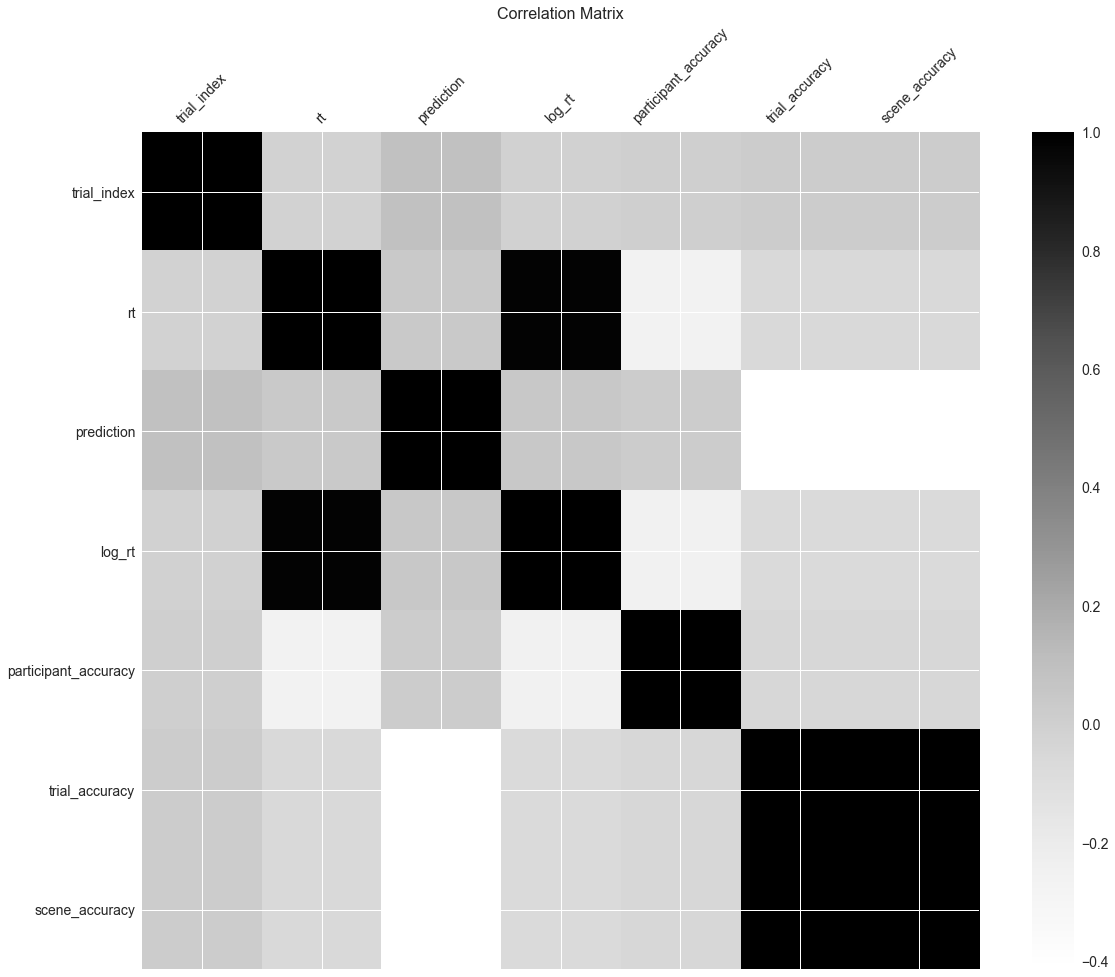

In [60]:
f = plt.figure(figsize=(19, 15))
plt.matshow(responses[(responses.trial_condition == "No") & (responses.correct == True)].corr(), fignum=f.number)
plt.xticks(range(responses.select_dtypes(['number']).shape[1]), responses.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(responses.select_dtypes(['number']).shape[1]), responses.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

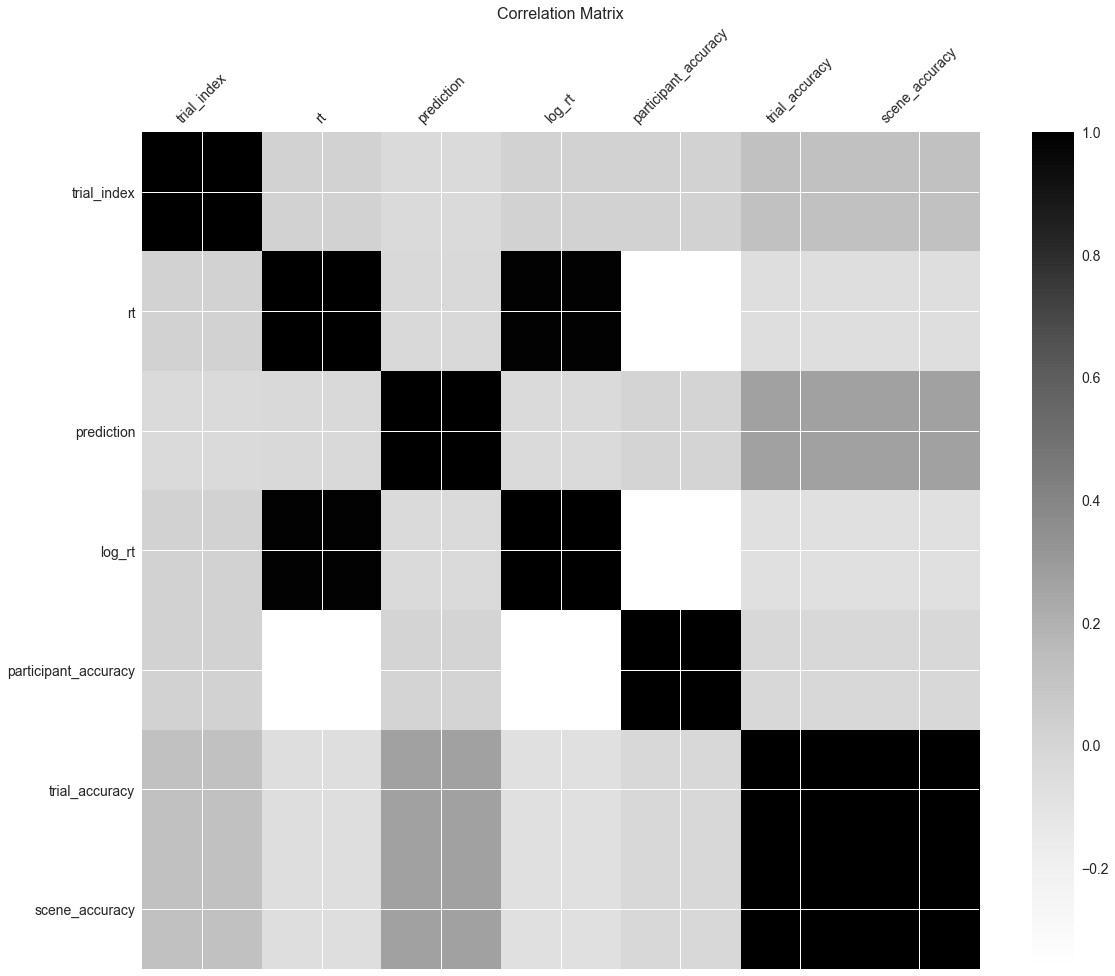

In [55]:
f = plt.figure(figsize=(19, 15))
plt.matshow(responses[(responses.trial_condition == "Yes") & (responses.correct == True)].corr(), fignum=f.number)
plt.xticks(range(responses.select_dtypes(['number']).shape[1]), responses.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(responses.select_dtypes(['number']).shape[1]), responses.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

## Analyses

- Number of participant responses per scene condition
- Number of scenes/stimuli per condition
- Number of participant responses across conditions
- Participant accuracy per condition
- Participant accuracy per trial
- Log-RT per participant
- Log-rt per scene
- Log-RT per scenes in No Condition
- Log-RT per scenes in Yes Condition
- Log-RT per Trial

#### Number of responses per scene condition

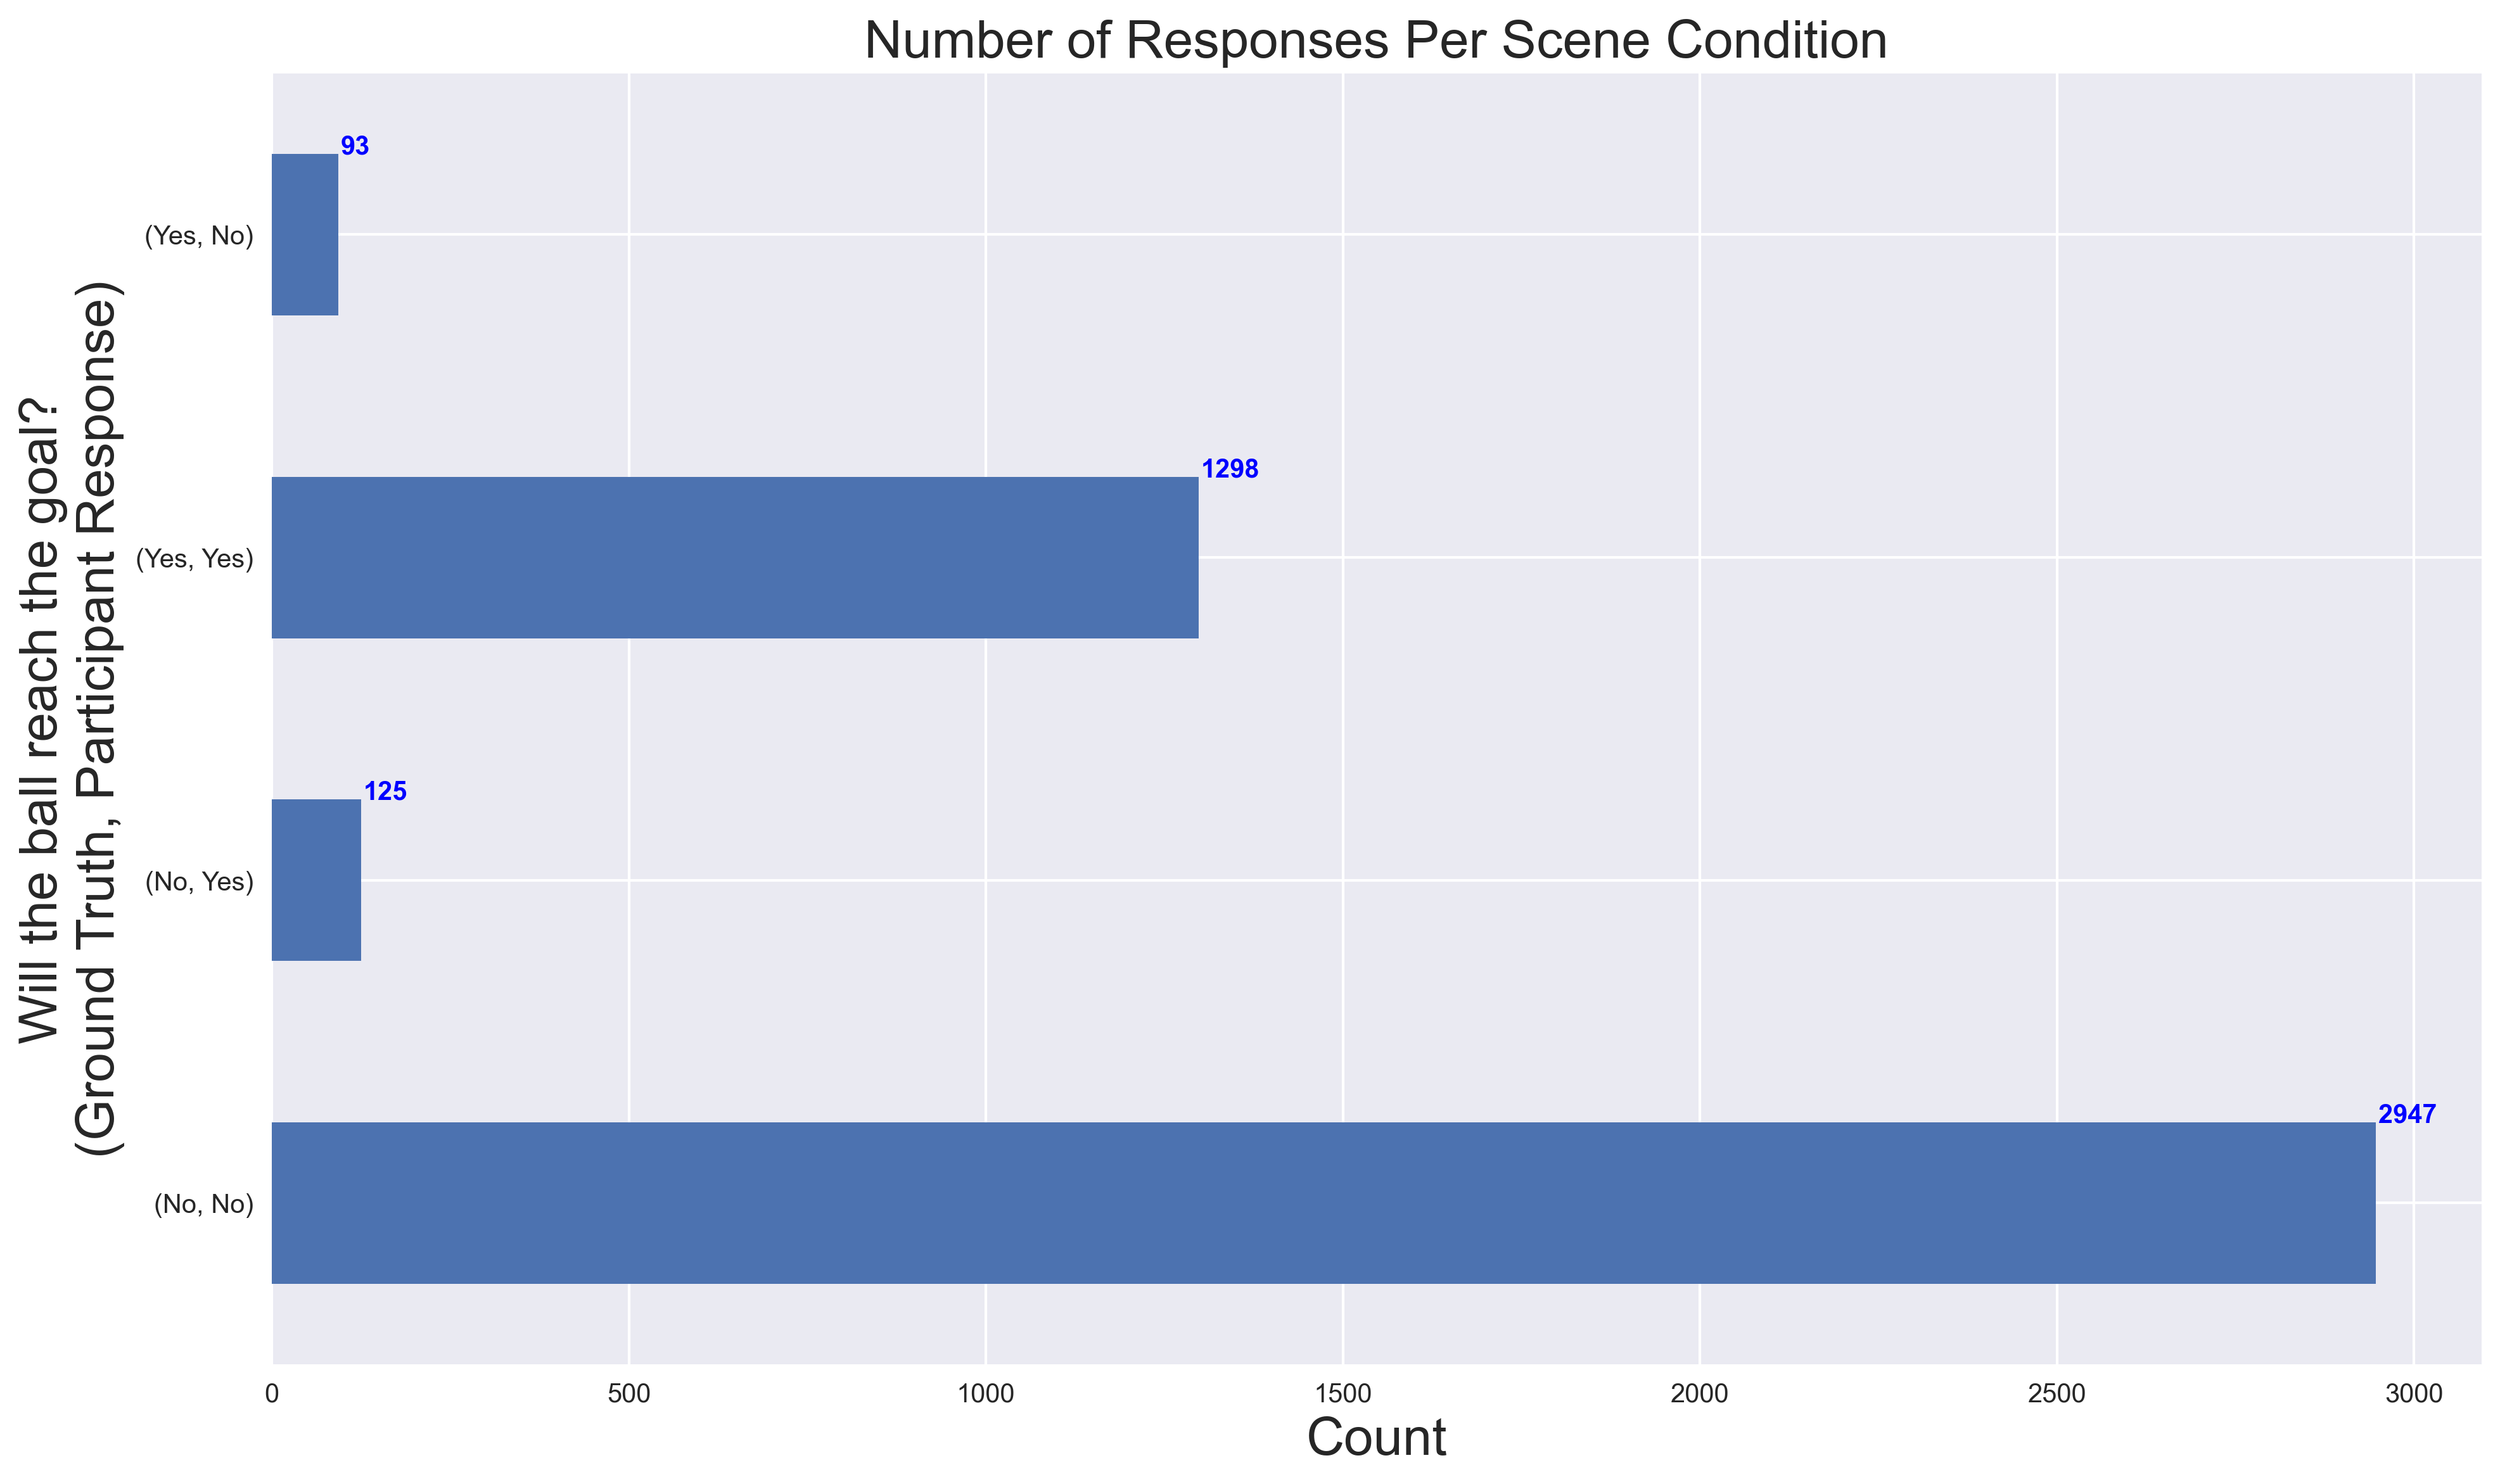

In [11]:
figure(figsize=(15, 9), dpi=300)
ax = responses.groupby("trial_condition").response.value_counts().plot.barh()
ax.set_xlabel("Count",fontsize=20);
ax.set_ylabel("Will the ball reach the goal?\n(Ground Truth, Participant Response)",fontsize=20);
ax.set_title("Number of Responses Per Scene Condition",fontsize=20)
for i, v in enumerate(responses.groupby("trial_condition").response.value_counts()):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')

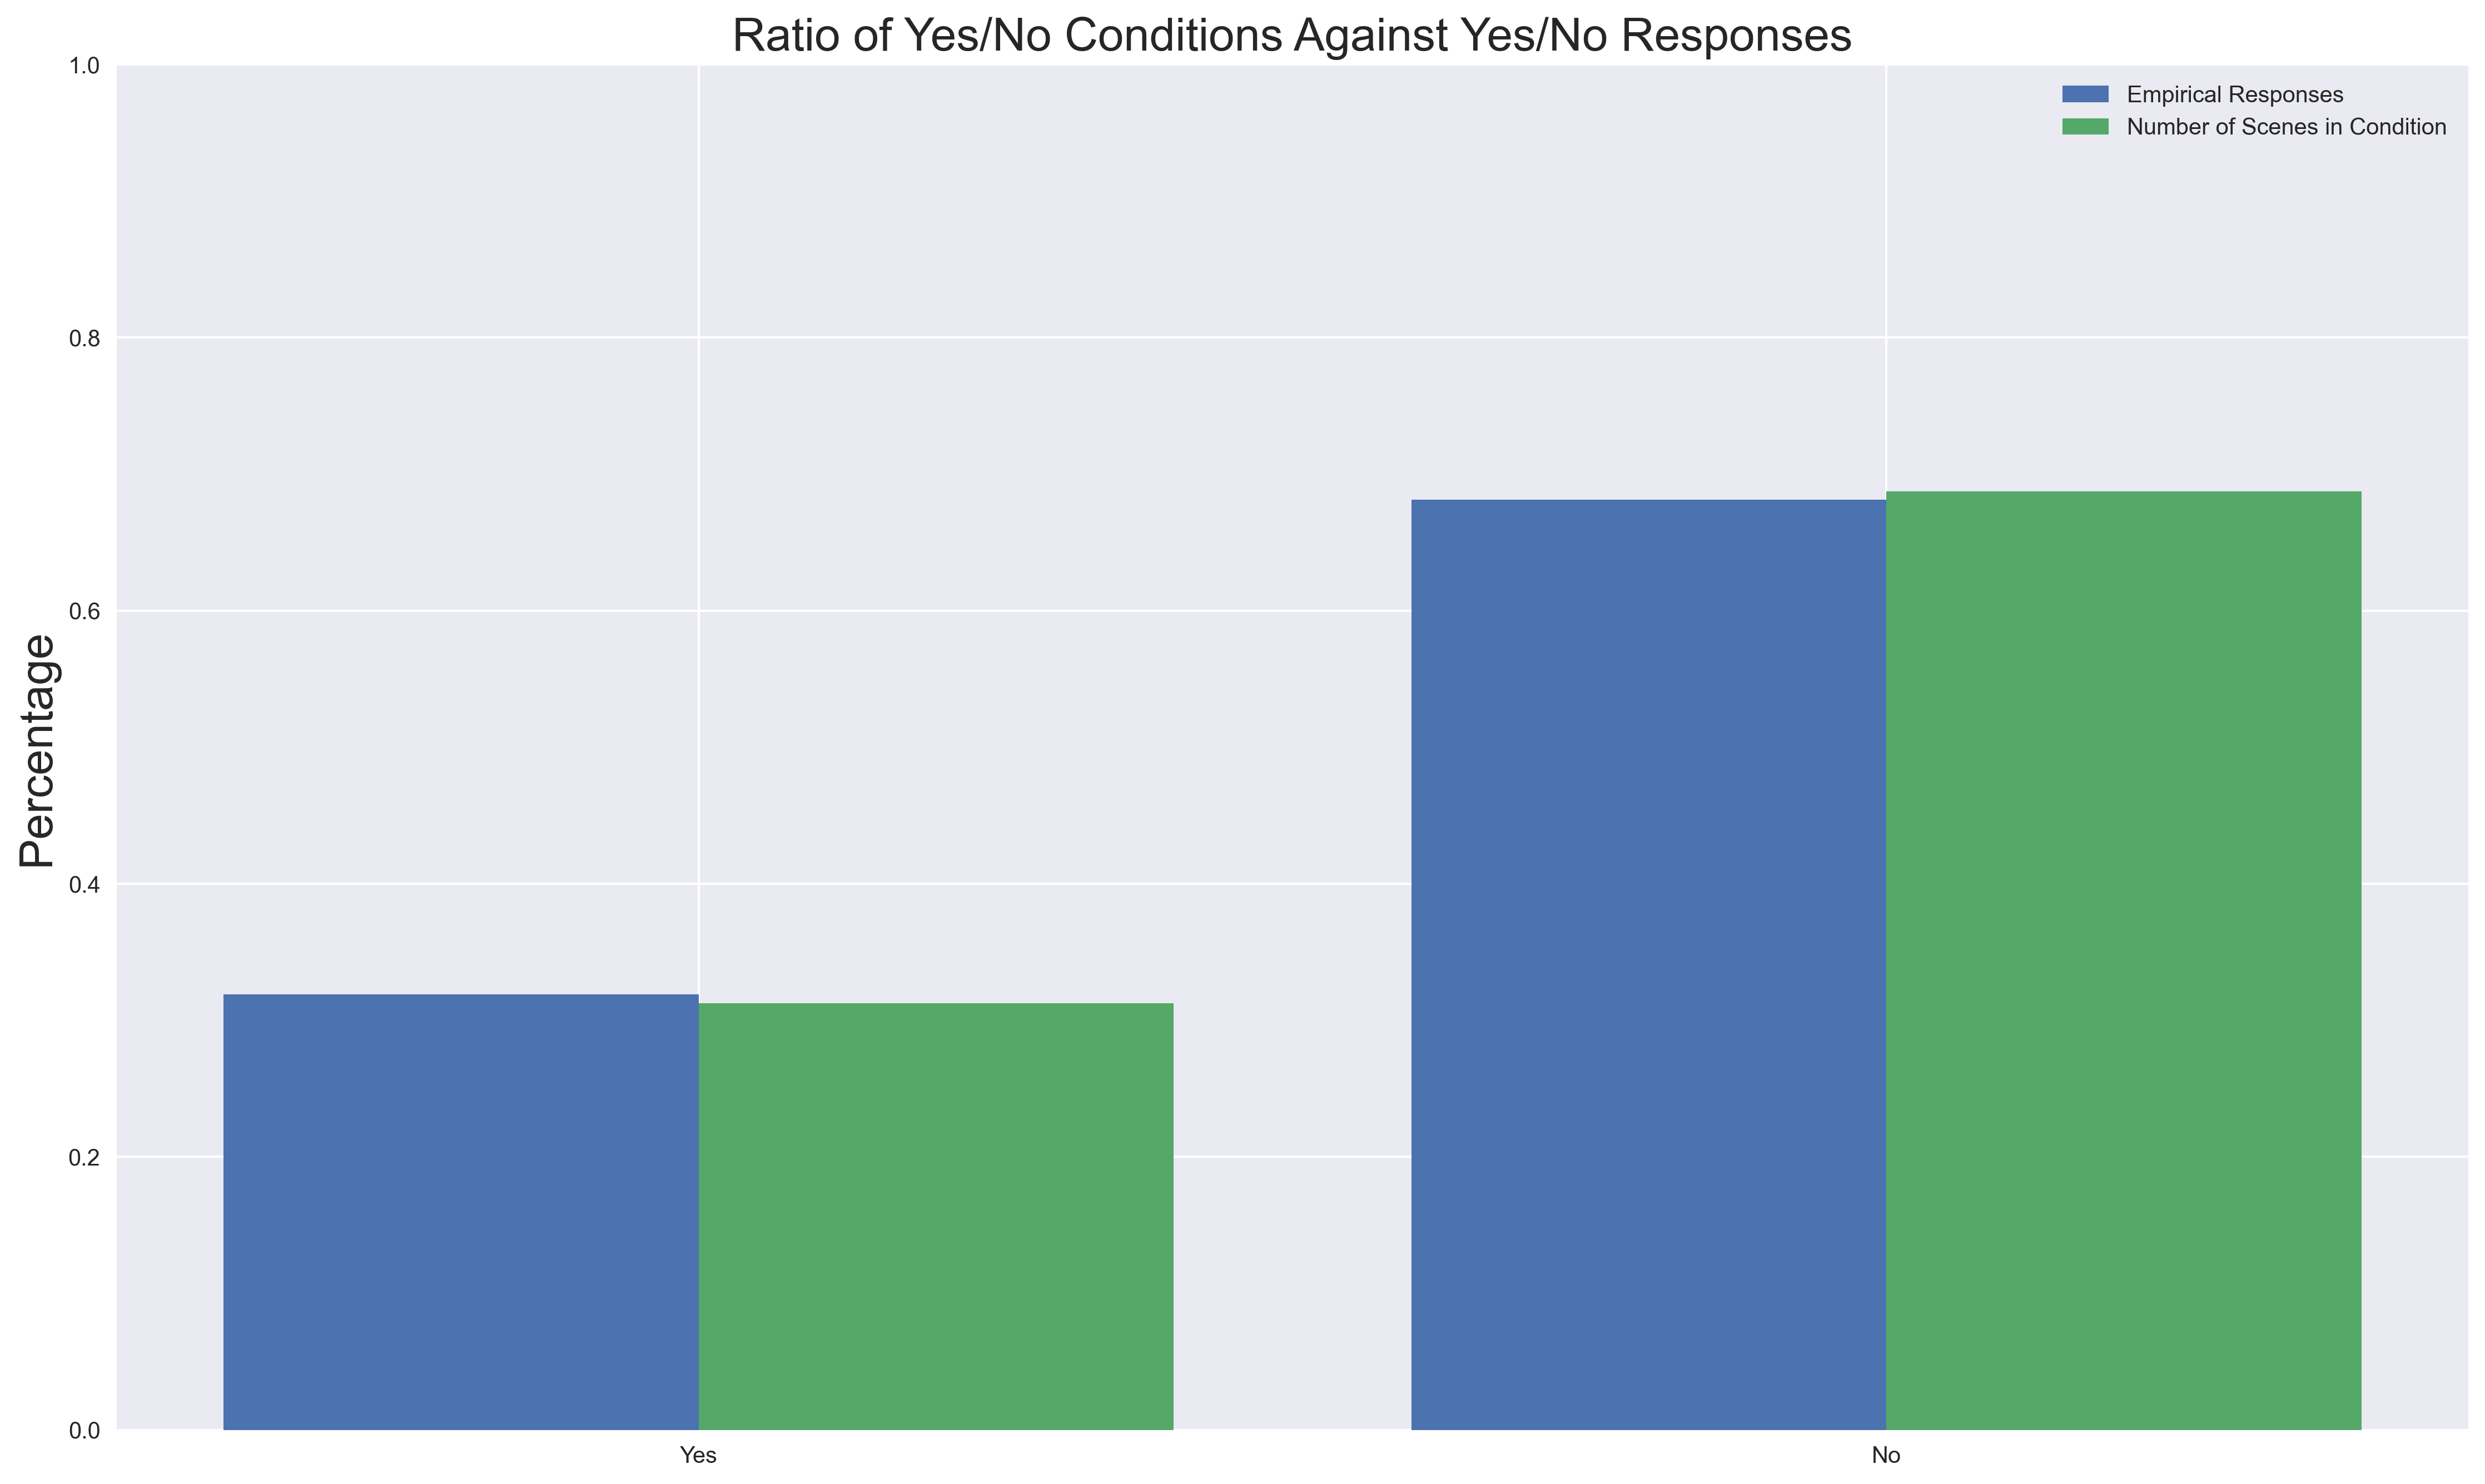

In [12]:
# What condition is each scene? (e.g. does the ball reach the goal or not)
conditions = responses.groupby("scene").trial_condition.apply(lambda x: list(x)[0])

# What did participants respond?
participants = responses.groupby("response").response.apply(list)

# Number of "Yes" scenes
yes_conditions = len(conditions[conditions == "Yes"])
# Number of "No" scenes
no_conditions = len(conditions[conditions == "No"])
total_conditions = yes_conditions+no_conditions
#Compute ratio
yes_conditions/=total_conditions
no_conditions/=total_conditions

# Number of "Yes" scenes
yes_participants = len(participants['Yes'])
# Number of "No" scenes
no_participants = len(participants['No'])
# Compute ratio
total_participants = yes_participants+no_participants
yes_participants/=total_participants
no_participants/=total_participants

labels = ["Yes","No"]
participant_counts = [yes_participants,no_participants]
condition_counts = [yes_conditions,no_conditions]

x = np.arange(len(labels))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 9),dpi=300)
rects1 = ax.bar(x - width/2, participant_counts, width, label='Empirical Responses')
rects2 = ax.bar(x + width/2, condition_counts, width, label='Number of Scenes in Condition')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage',fontsize=20)
ax.set_title('Ratio of Yes/No Conditions Against Yes/No Responses',fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
plt.ylim(0,1)
fig.tight_layout()
plt.show()

#### Number of scenes in each condition

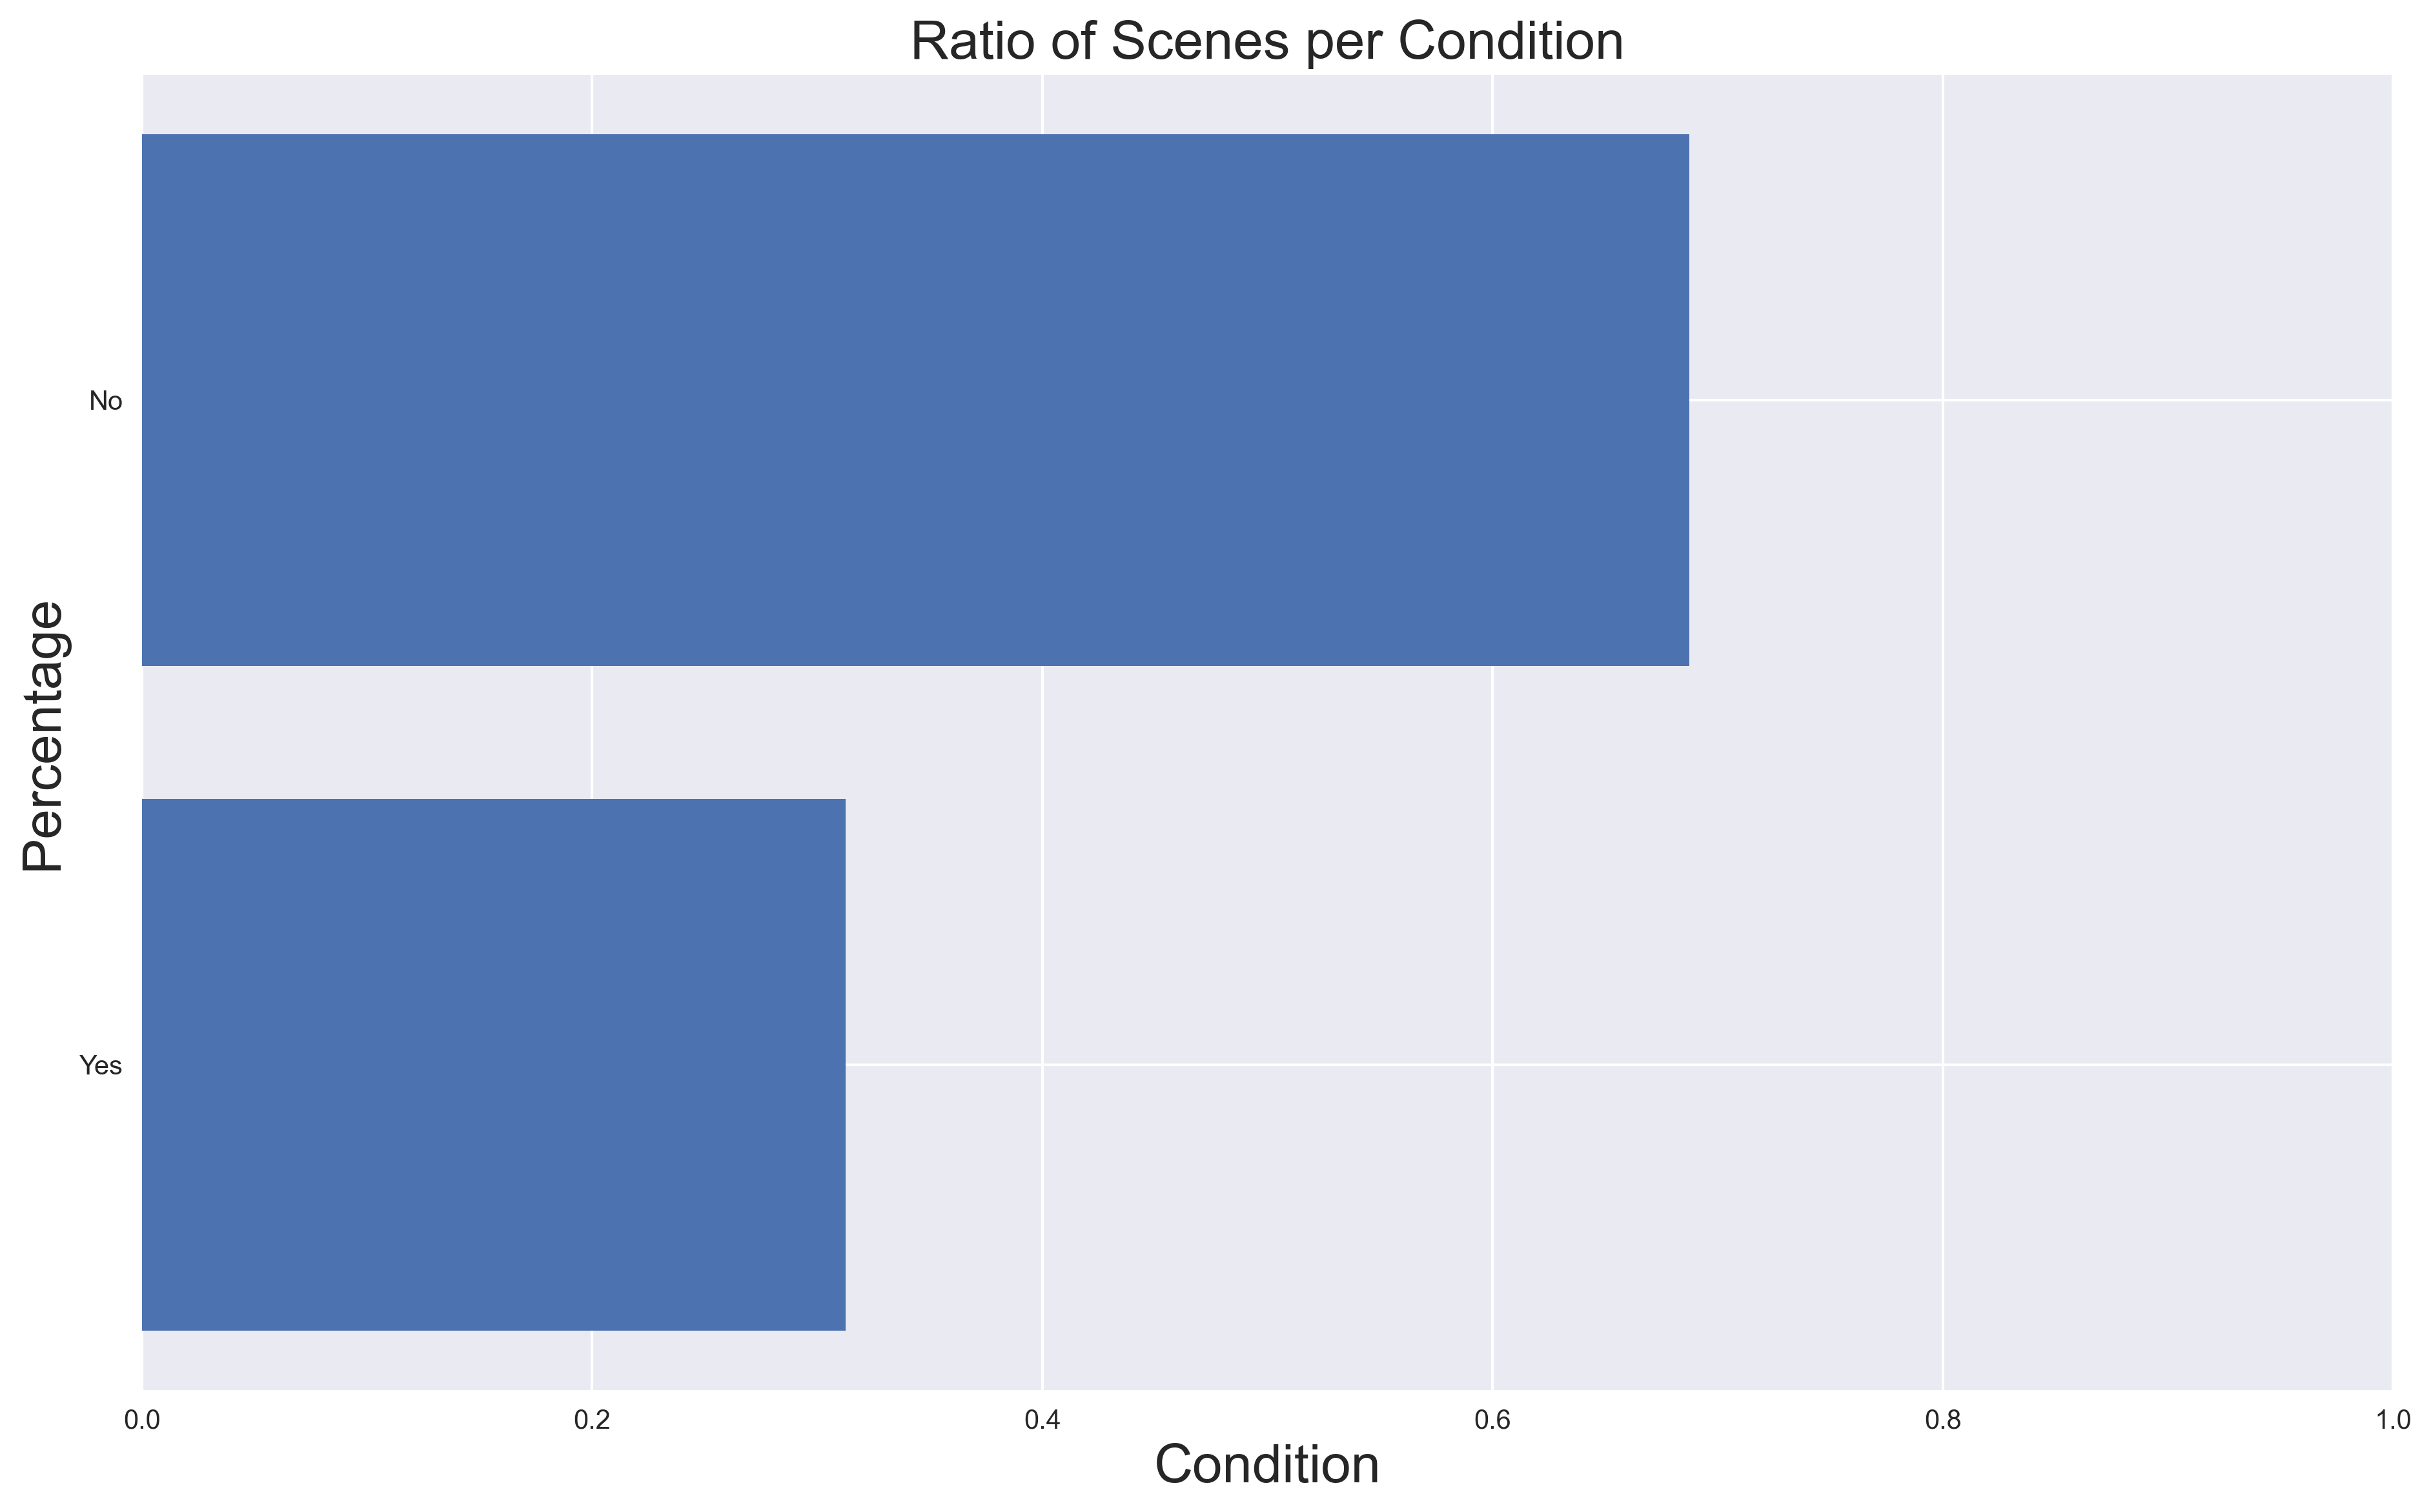

In [13]:
# What condition is each scene? (e.g. does the ball reach the goal or not)
y = responses.groupby("scene").trial_condition.apply(lambda x: list(x)[0])
# Number of "Yes" scenes
yes = len(y[y == "Yes"])
# # Number of "No" scenes
no = len(y[y == "No"])
total = yes+no

yes/=total
no/=total
figure(figsize=(15, 9), dpi=300)
plt.barh(["Yes","No"], [yes,no])
plt.xlim(0,1)
plt.title("Ratio of Scenes per Condition",fontsize=20)
plt.ylabel("Percentage",fontsize=20)
plt.xlabel("Condition",fontsize=20);

#### Number of responses across conditions

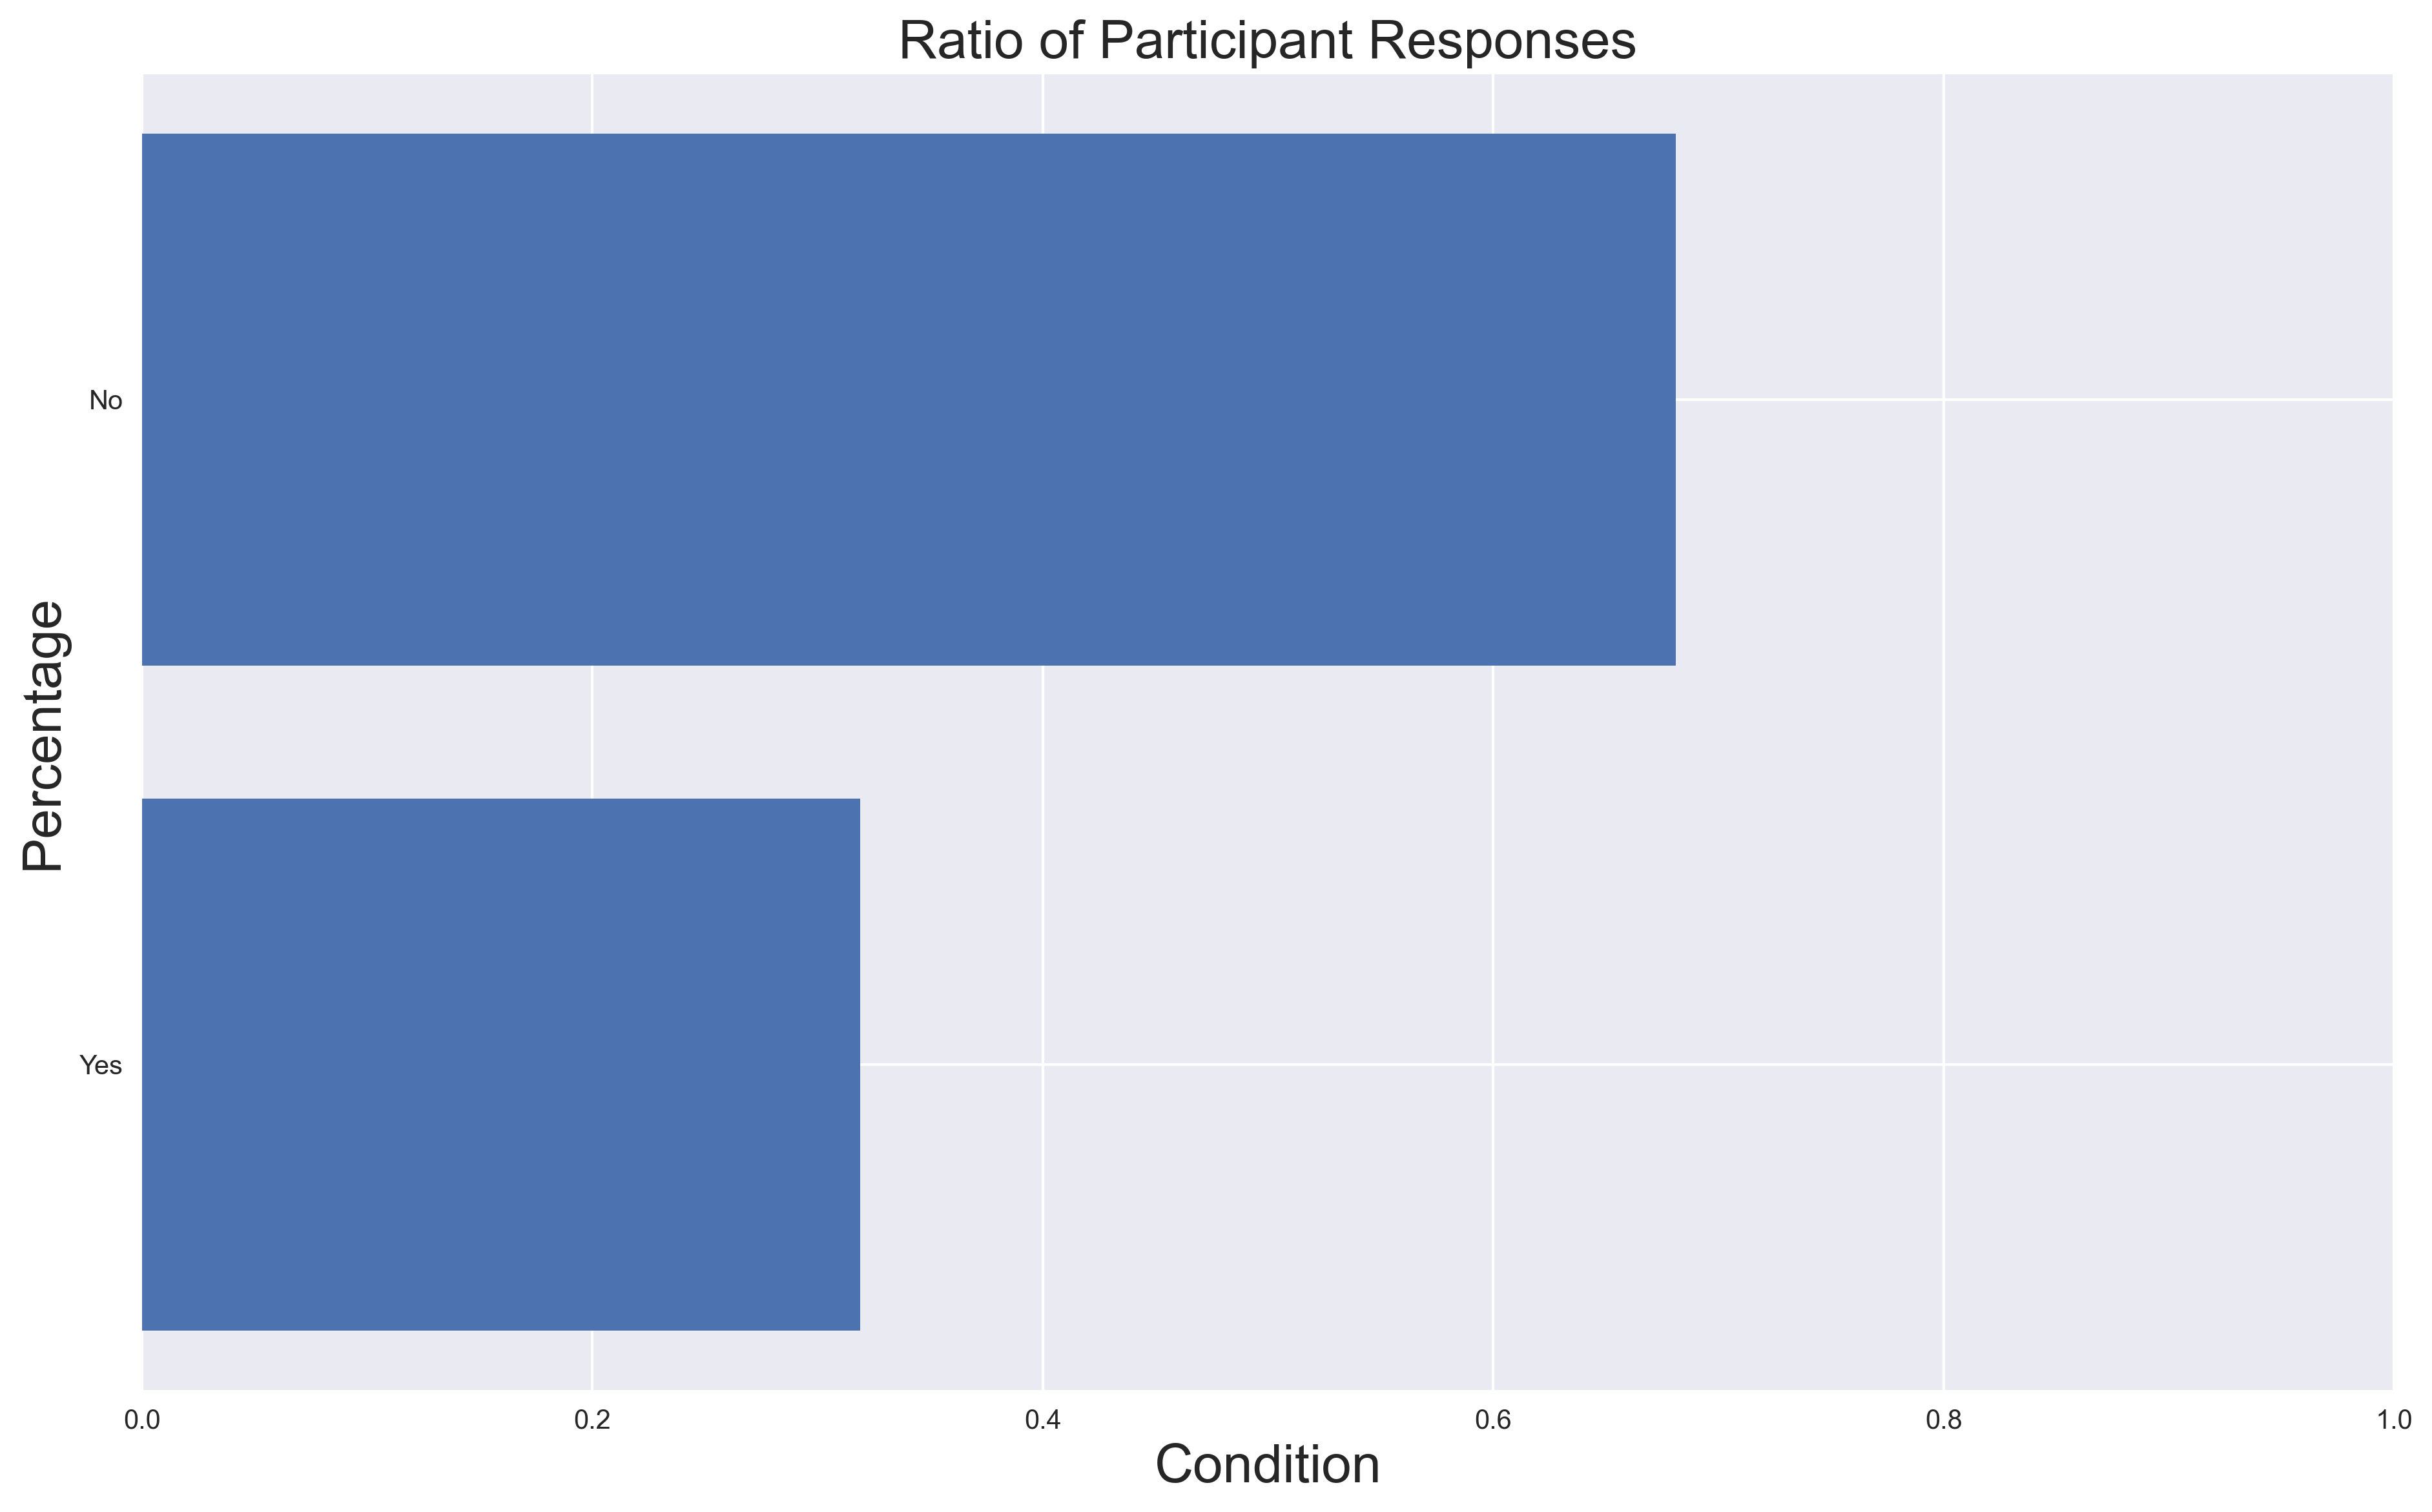

In [14]:
# What condition is each scene? (e.g. does the ball reach the goal or not)
y = responses.groupby("response").response.apply(list)

# Number of "Yes" scenes
yes = len(y['Yes'])
# Number of "No" scenes
no = len(y['No'])
total = yes+no

yes/=total
no/=total
figure(figsize=(15, 9), dpi=300)
plt.barh(["Yes","No"], [yes,no])
plt.xlim(0,1)
plt.title("Ratio of Participant Responses",fontsize=20)
plt.ylabel("Percentage",fontsize=20)
plt.xlabel("Condition",fontsize=20);

#### Overall accuracy per condition across participants

#### Accuracy per trial across participants

In [15]:
responses.participant_accuracy.describe()

count    4463.000000
mean        0.923256
std         0.076784
min         0.666667
25%         0.885417
50%         0.947917
75%         0.989583
max         1.000000
Name: participant_accuracy, dtype: float64

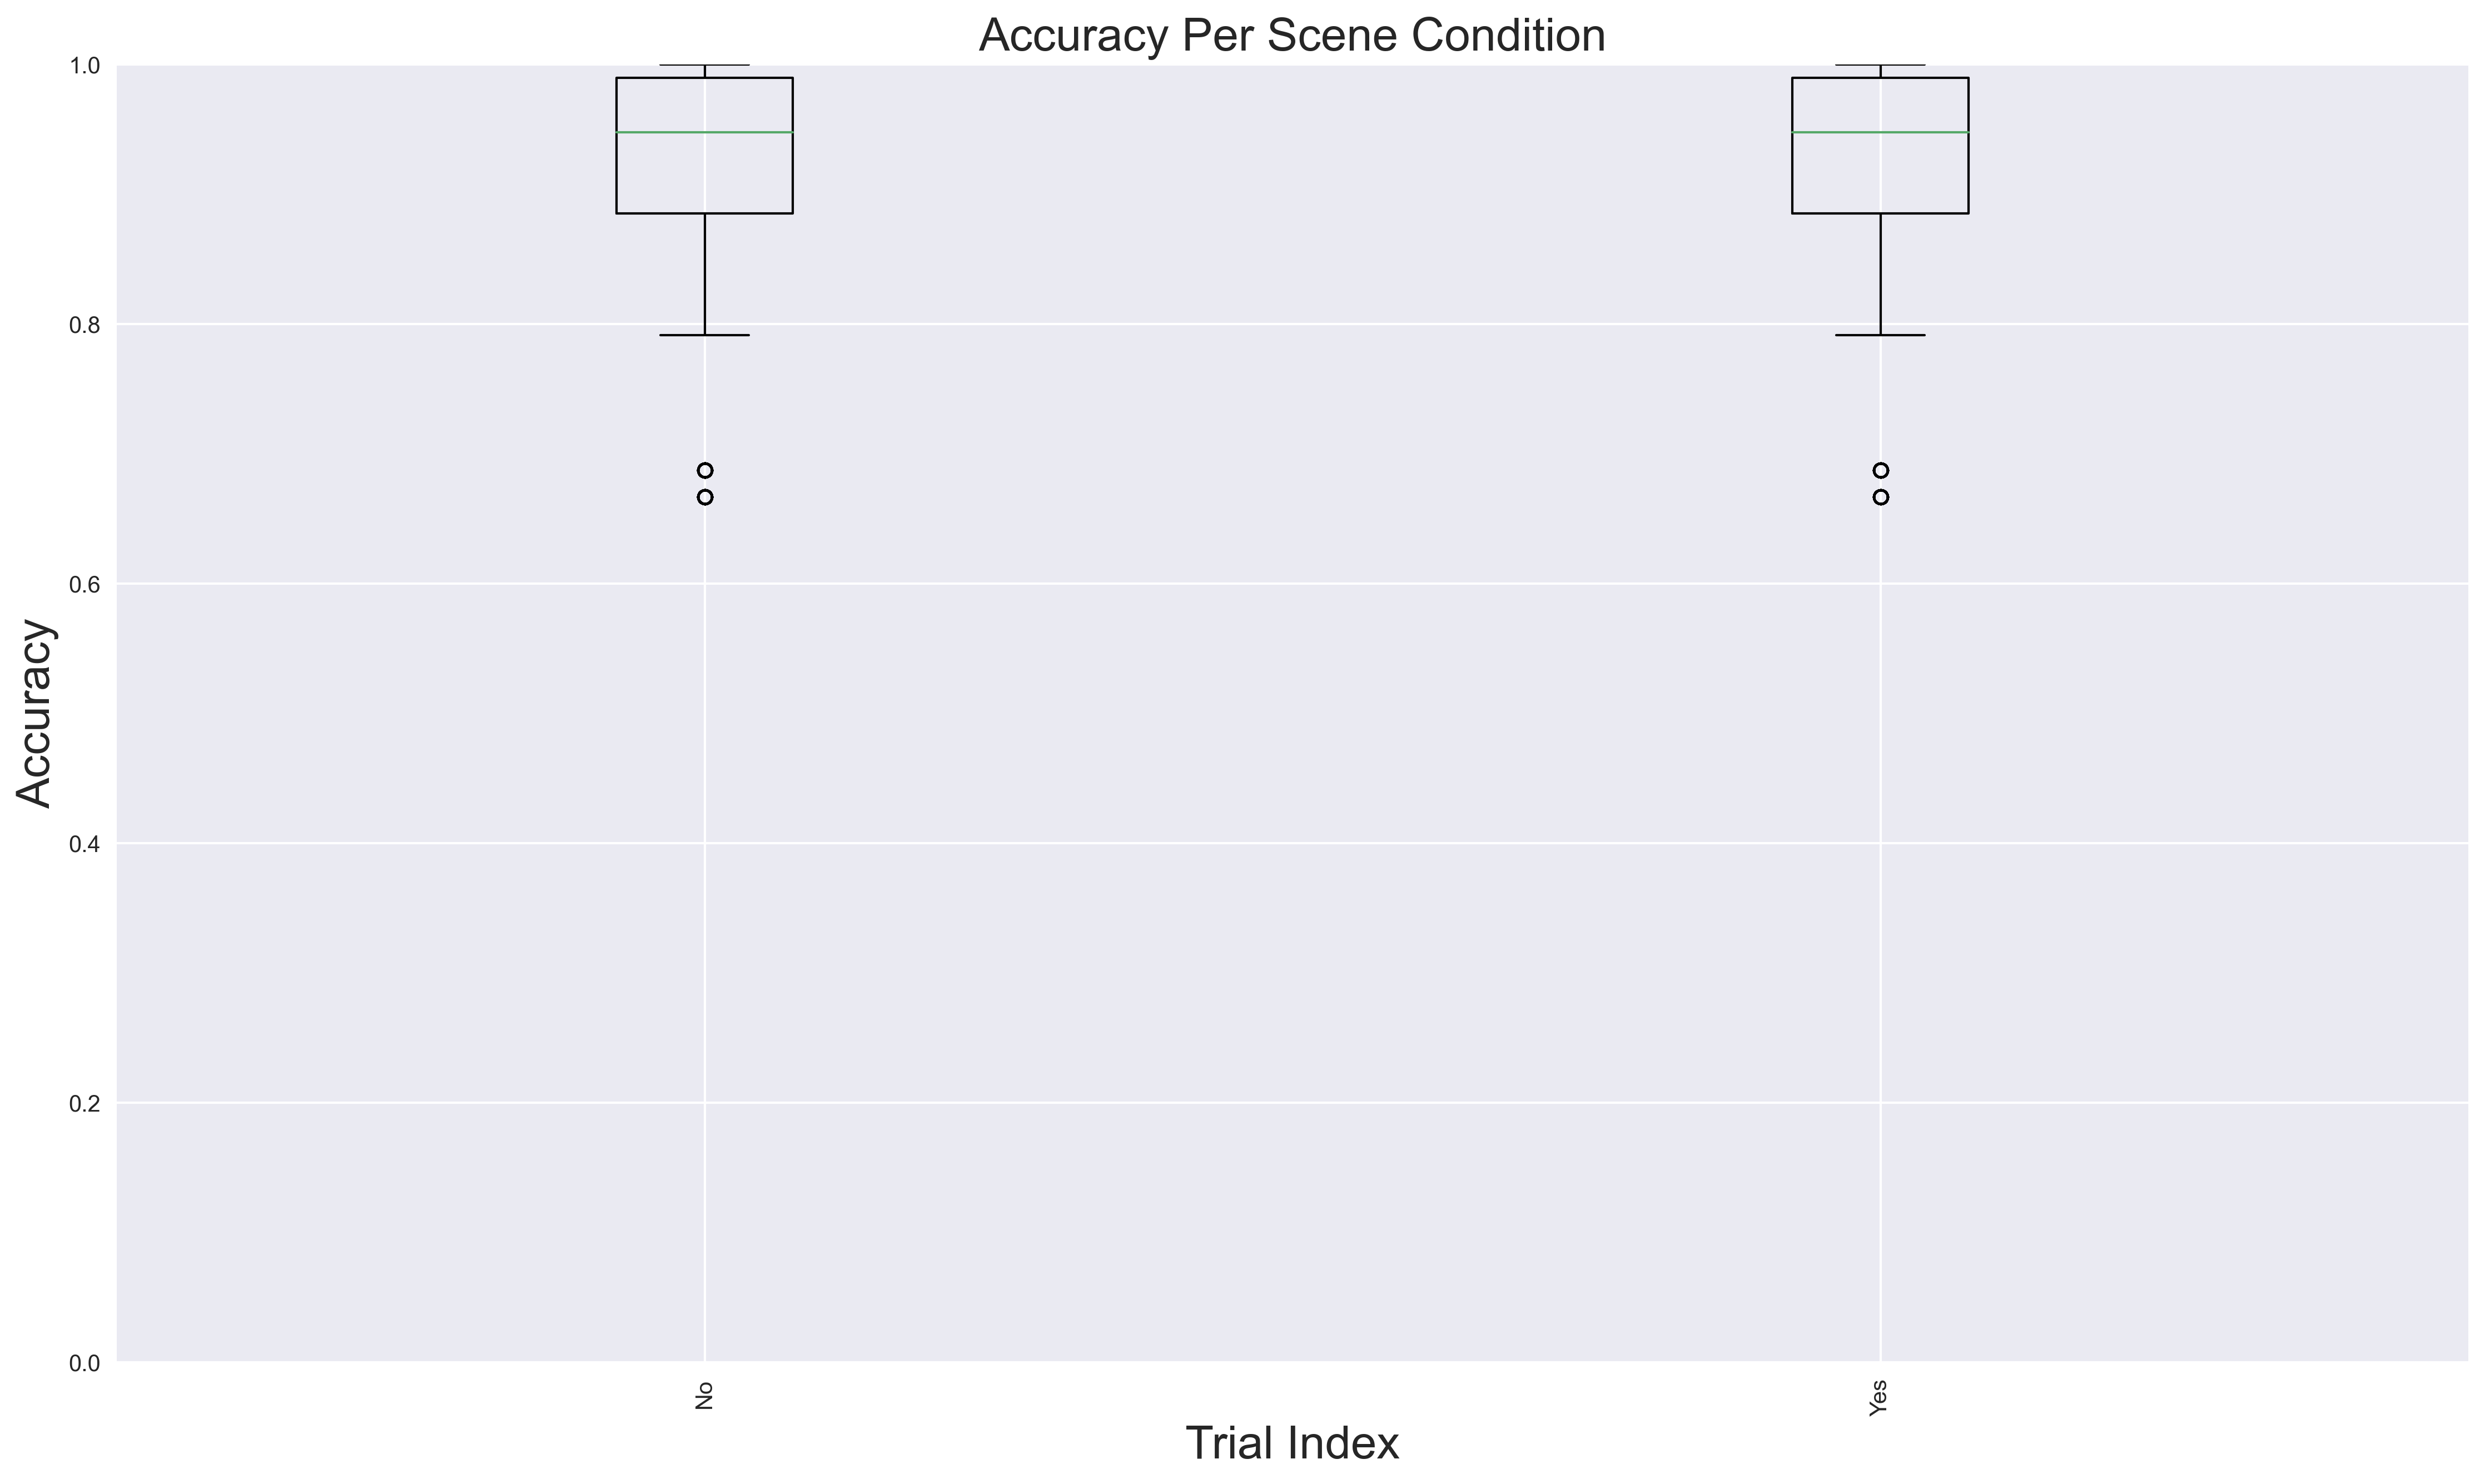

In [16]:
trial=responses.groupby("trial_condition").participant_accuracy.apply(list)
figure(figsize=(15, 9), dpi=300)

plt.boxplot(trial)
plt.xticks(rotation = 90)
plt.title("Accuracy Per Scene Condition",fontsize=20)
plt.ylim(0,1)
plt.xticks([1,2],["No","Yes"])
plt.xlabel("Trial Index",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
plt.tight_layout()
plt.show()

#### Accuracy per trial

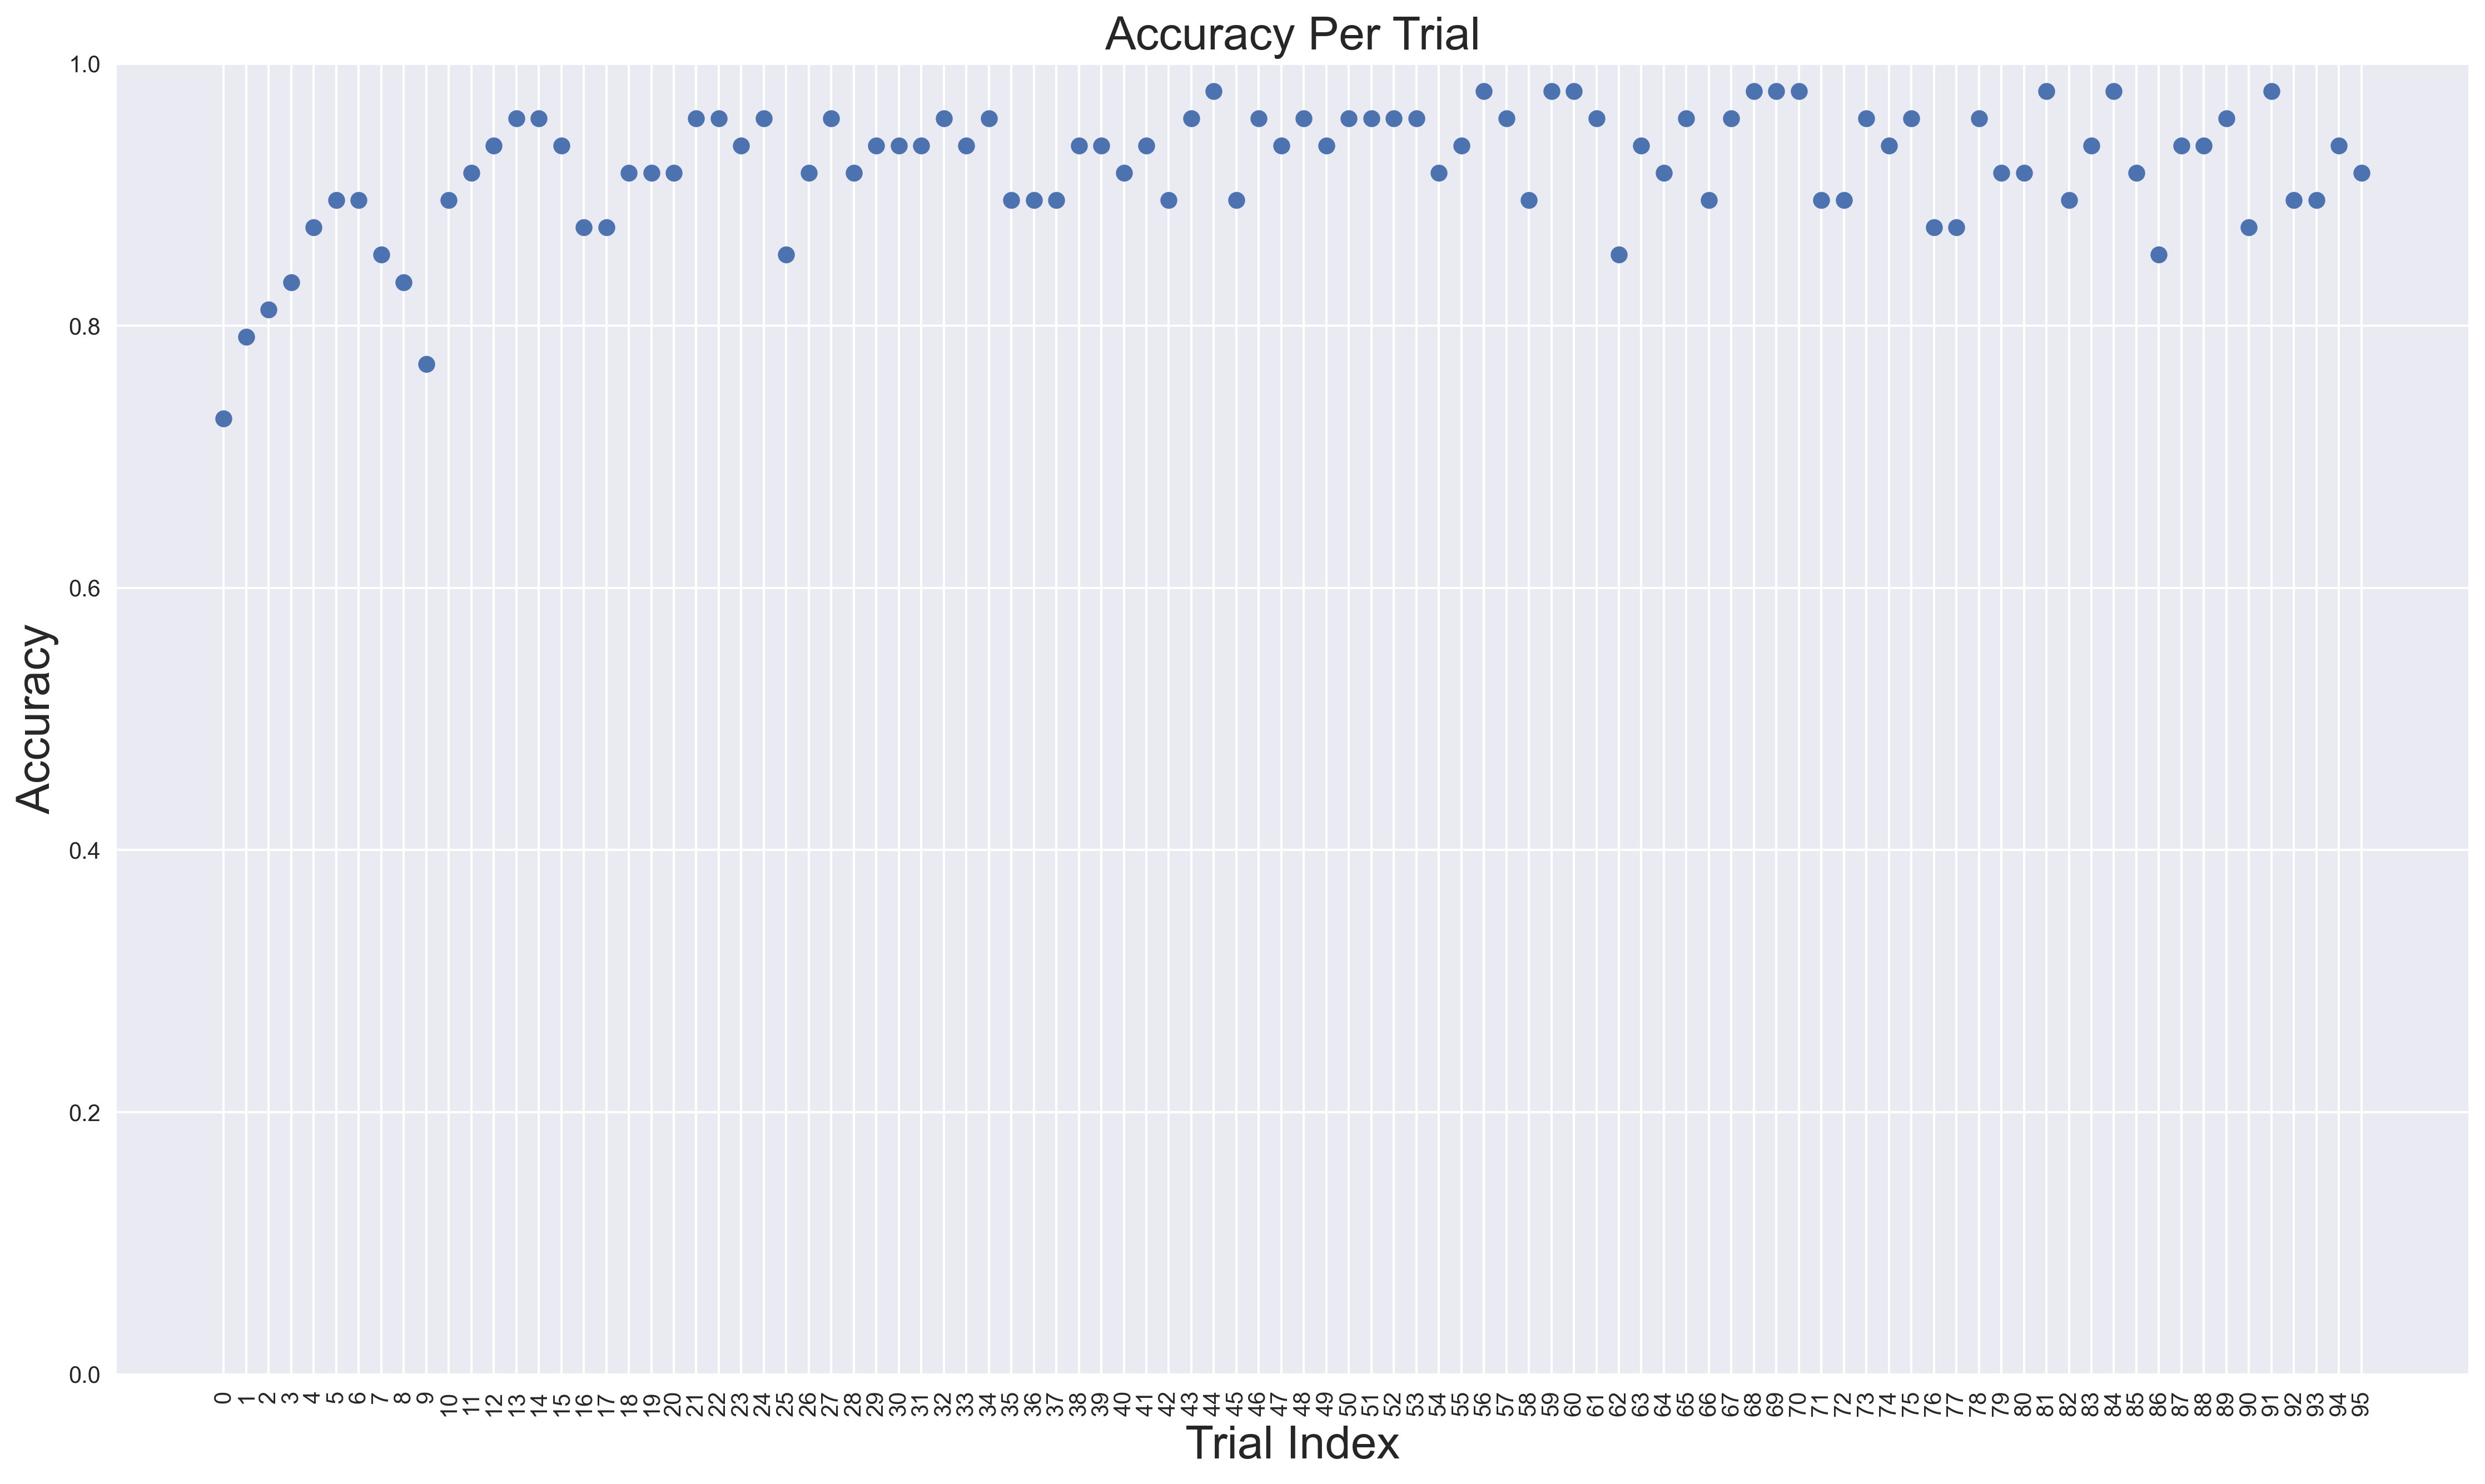

In [17]:
trial_y=responses.groupby("trial_index").trial_accuracy.mean()
trial_x=list(range(len(trial_y)))
figure(figsize=(15, 9), dpi=300)

plt.scatter(trial_x,trial_y)
plt.xticks(rotation = 90)
plt.title("Accuracy Per Trial",fontsize=20)
plt.ylim(0,1)
plt.xticks(trial_x,trial_x)
plt.xlabel("Trial Index",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
plt.tight_layout()
plt.show()

#### Accuracy per scene

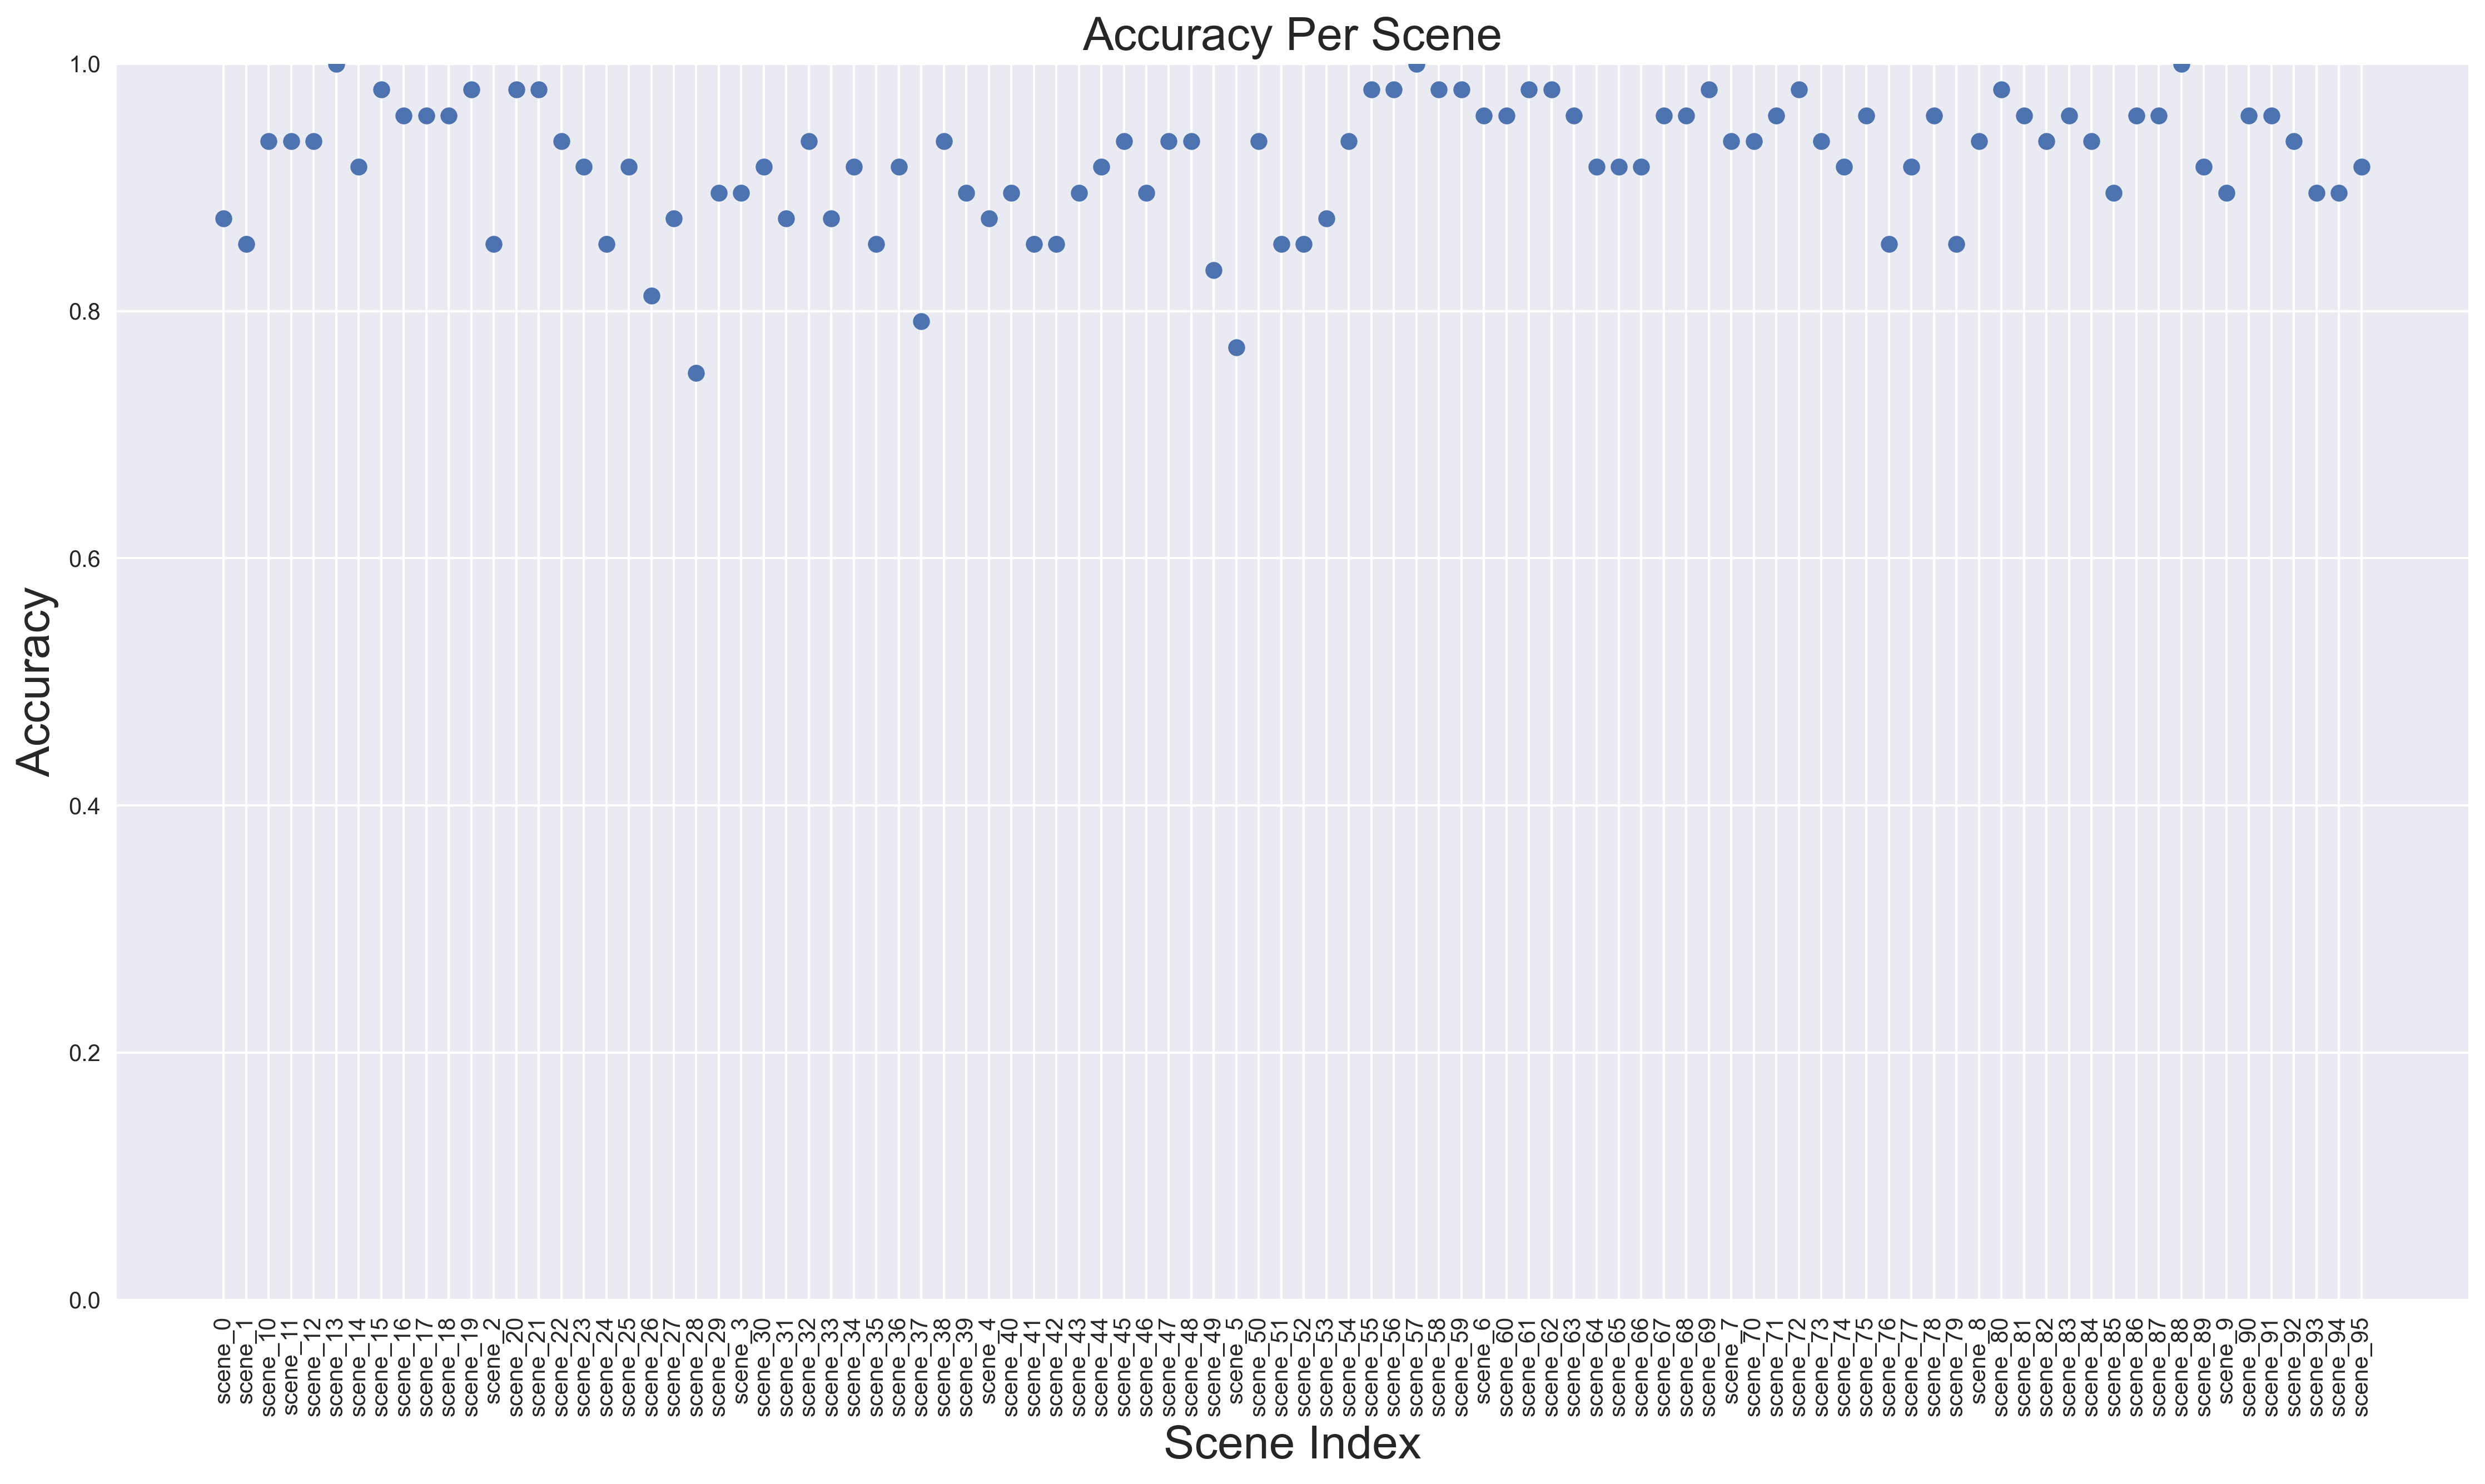

In [18]:
trial_y=responses.groupby("scene").scene_accuracy.mean()
trial_x=list(range(len(trial_y)))
trial_x_ticks = trial_y.index
figure(figsize=(15, 9), dpi=300)

plt.scatter(trial_x,trial_y)
plt.xticks(rotation = 90)
plt.title("Accuracy Per Scene",fontsize=20)
plt.ylim(0,1)
plt.xticks(trial_x,trial_x_ticks)
plt.xlabel("Scene Index",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
plt.tight_layout()
plt.show()

In [41]:
bad_scenes=responses[responses.scene_accuracy < 0.85]
bad_scenes.groupby('scene').scene.apply(list)

scene
scene_26    [scene_26, scene_26, scene_26, scene_26, scene...
scene_28    [scene_28, scene_28, scene_28, scene_28, scene...
scene_37    [scene_37, scene_37, scene_37, scene_37, scene...
scene_49    [scene_49, scene_49, scene_49, scene_49, scene...
scene_5     [scene_5, scene_5, scene_5, scene_5, scene_5, ...
Name: scene, dtype: object

#### Where were some scenes shown?

In [19]:
responses.groupby("scene").correct.value_counts()['scene_18']


correct
True    46
Name: correct, dtype: int64

#### Log-RT per participant

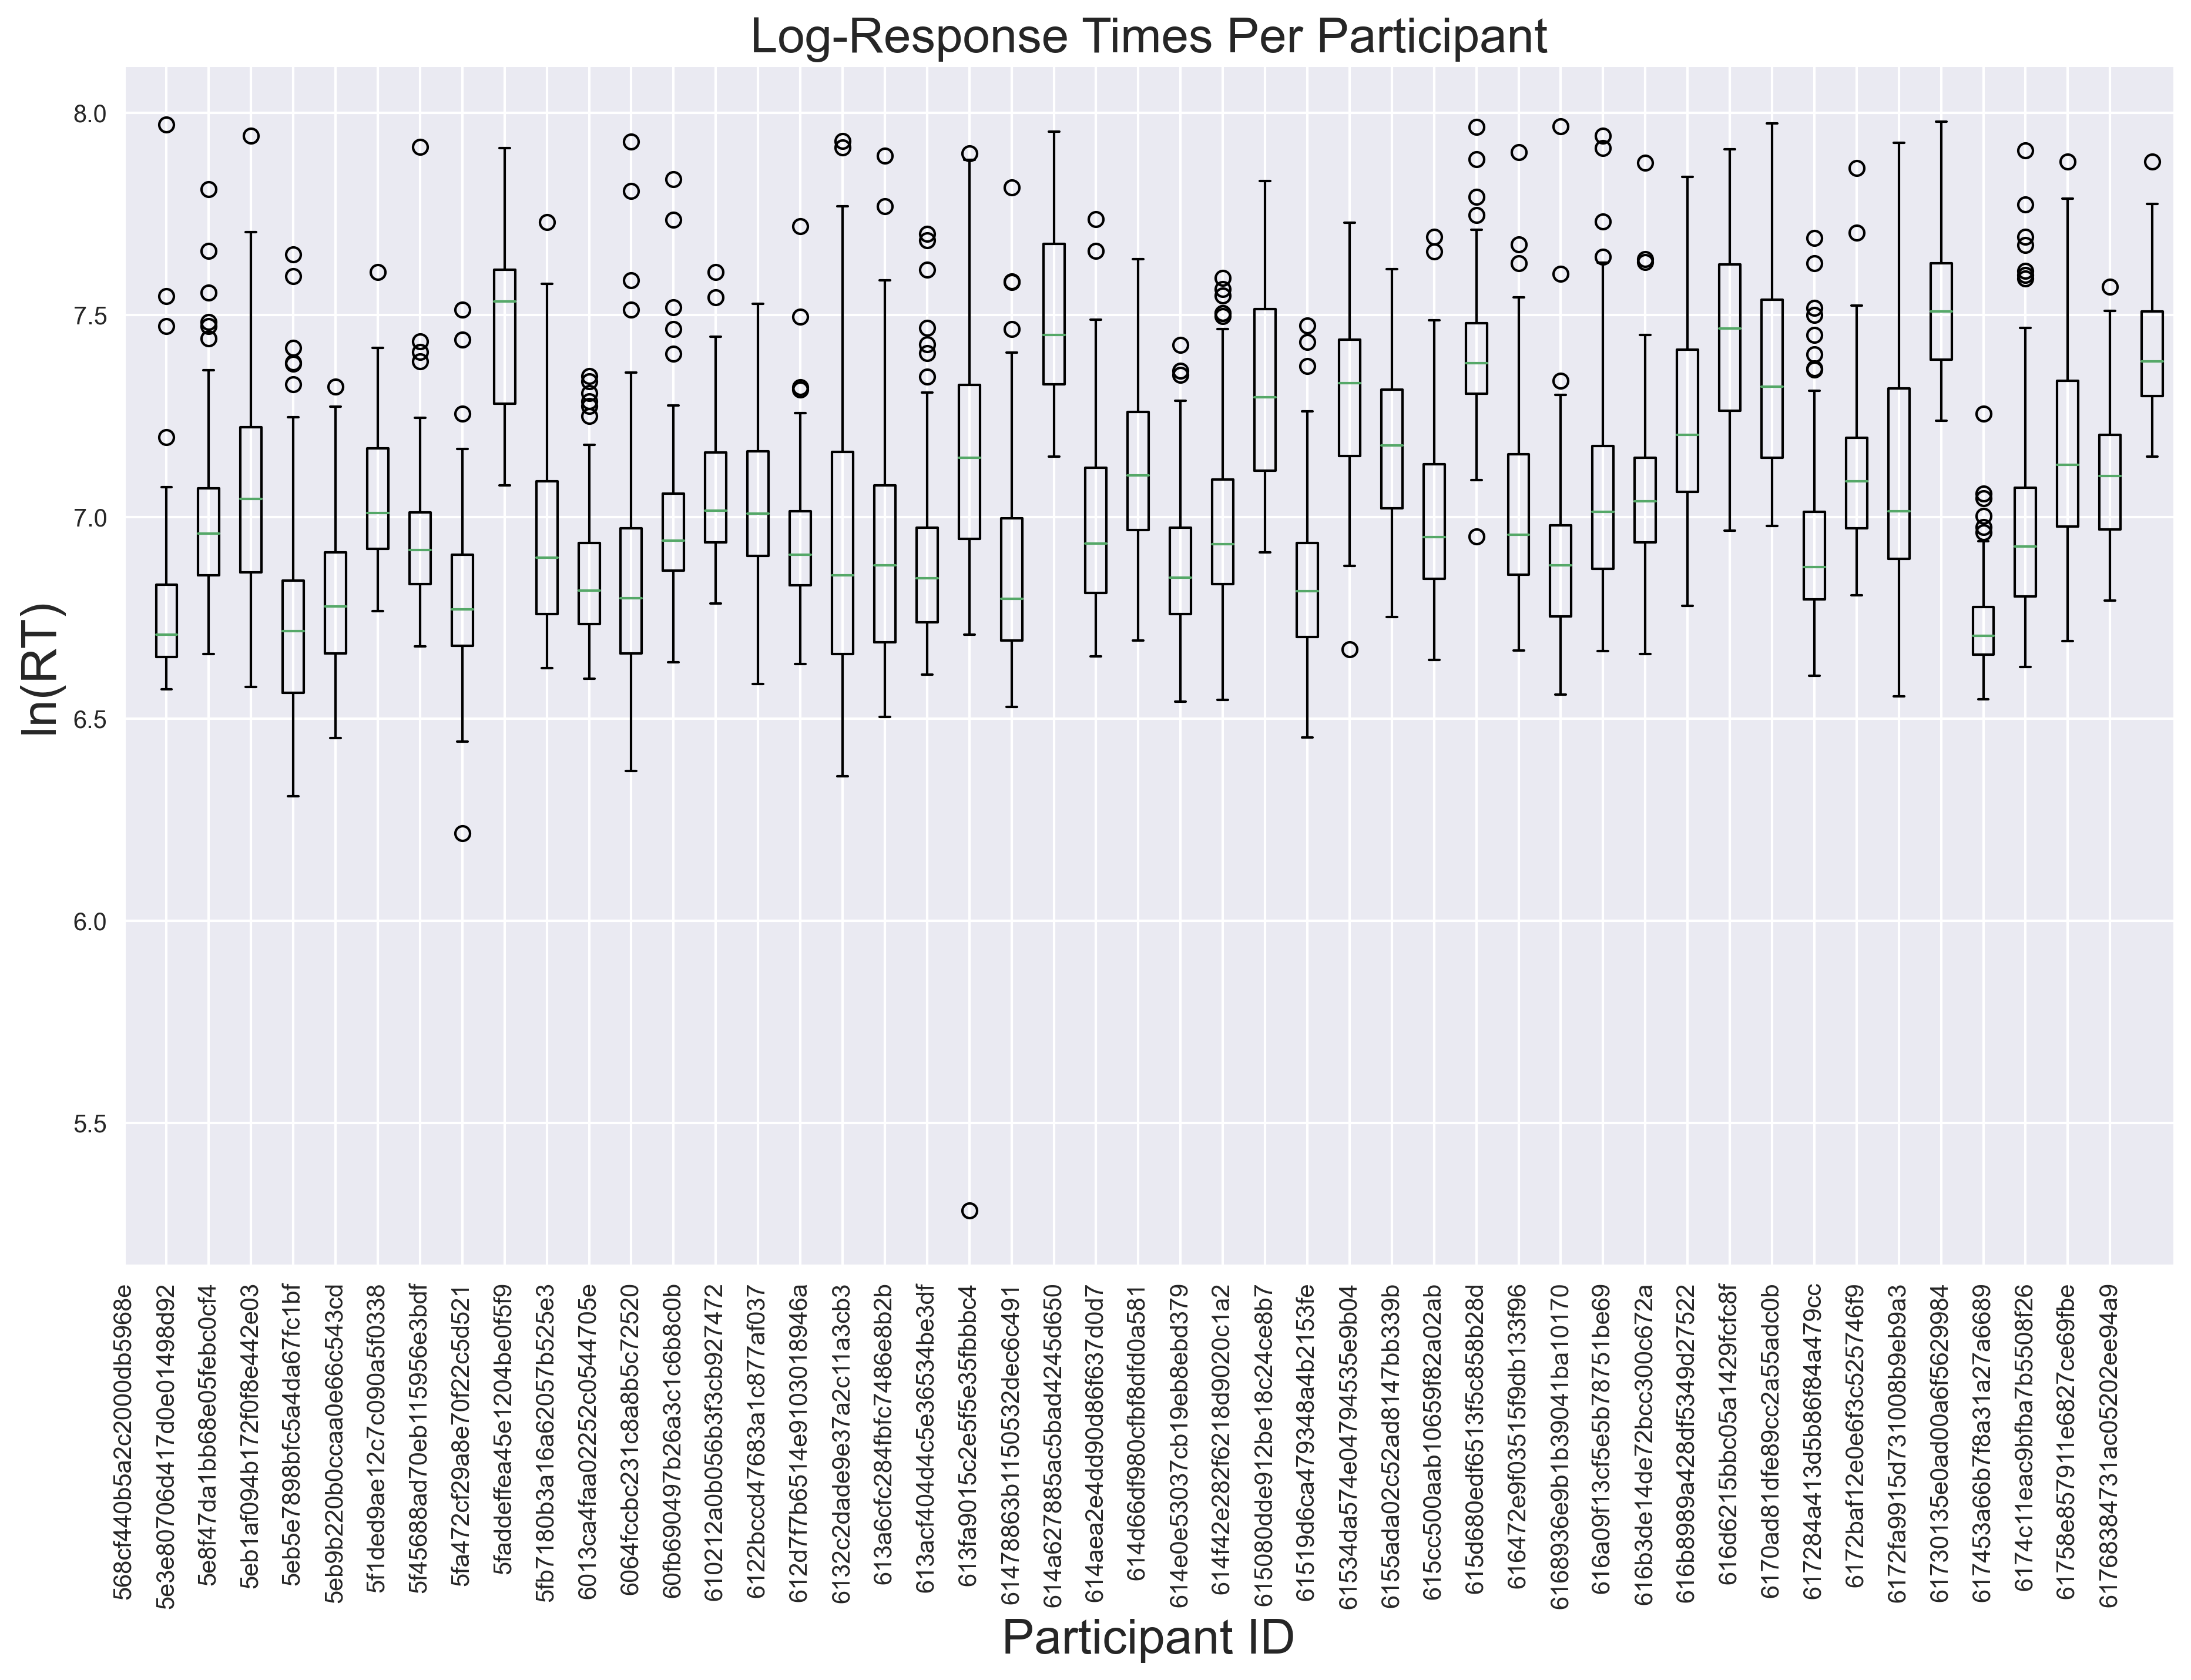

In [20]:
figure(figsize=(15, 9), dpi=300)
plt.boxplot(responses.groupby('subject_id').log_rt.apply(list))
plt.title("Log-Response Times Per Participant",fontsize=20)
plt.xlabel("Participant ID",fontsize=20)
plt.ylabel("ln(RT)",fontsize=20)
plt.xticks(list(range(len(responses.groupby('subject_id').log_rt.apply(list)))), 
           responses.groupby('subject_id').log_rt.apply(list).index,
           rotation=90);

## Normality tests

### Histograms

#### Cumulative Log RT

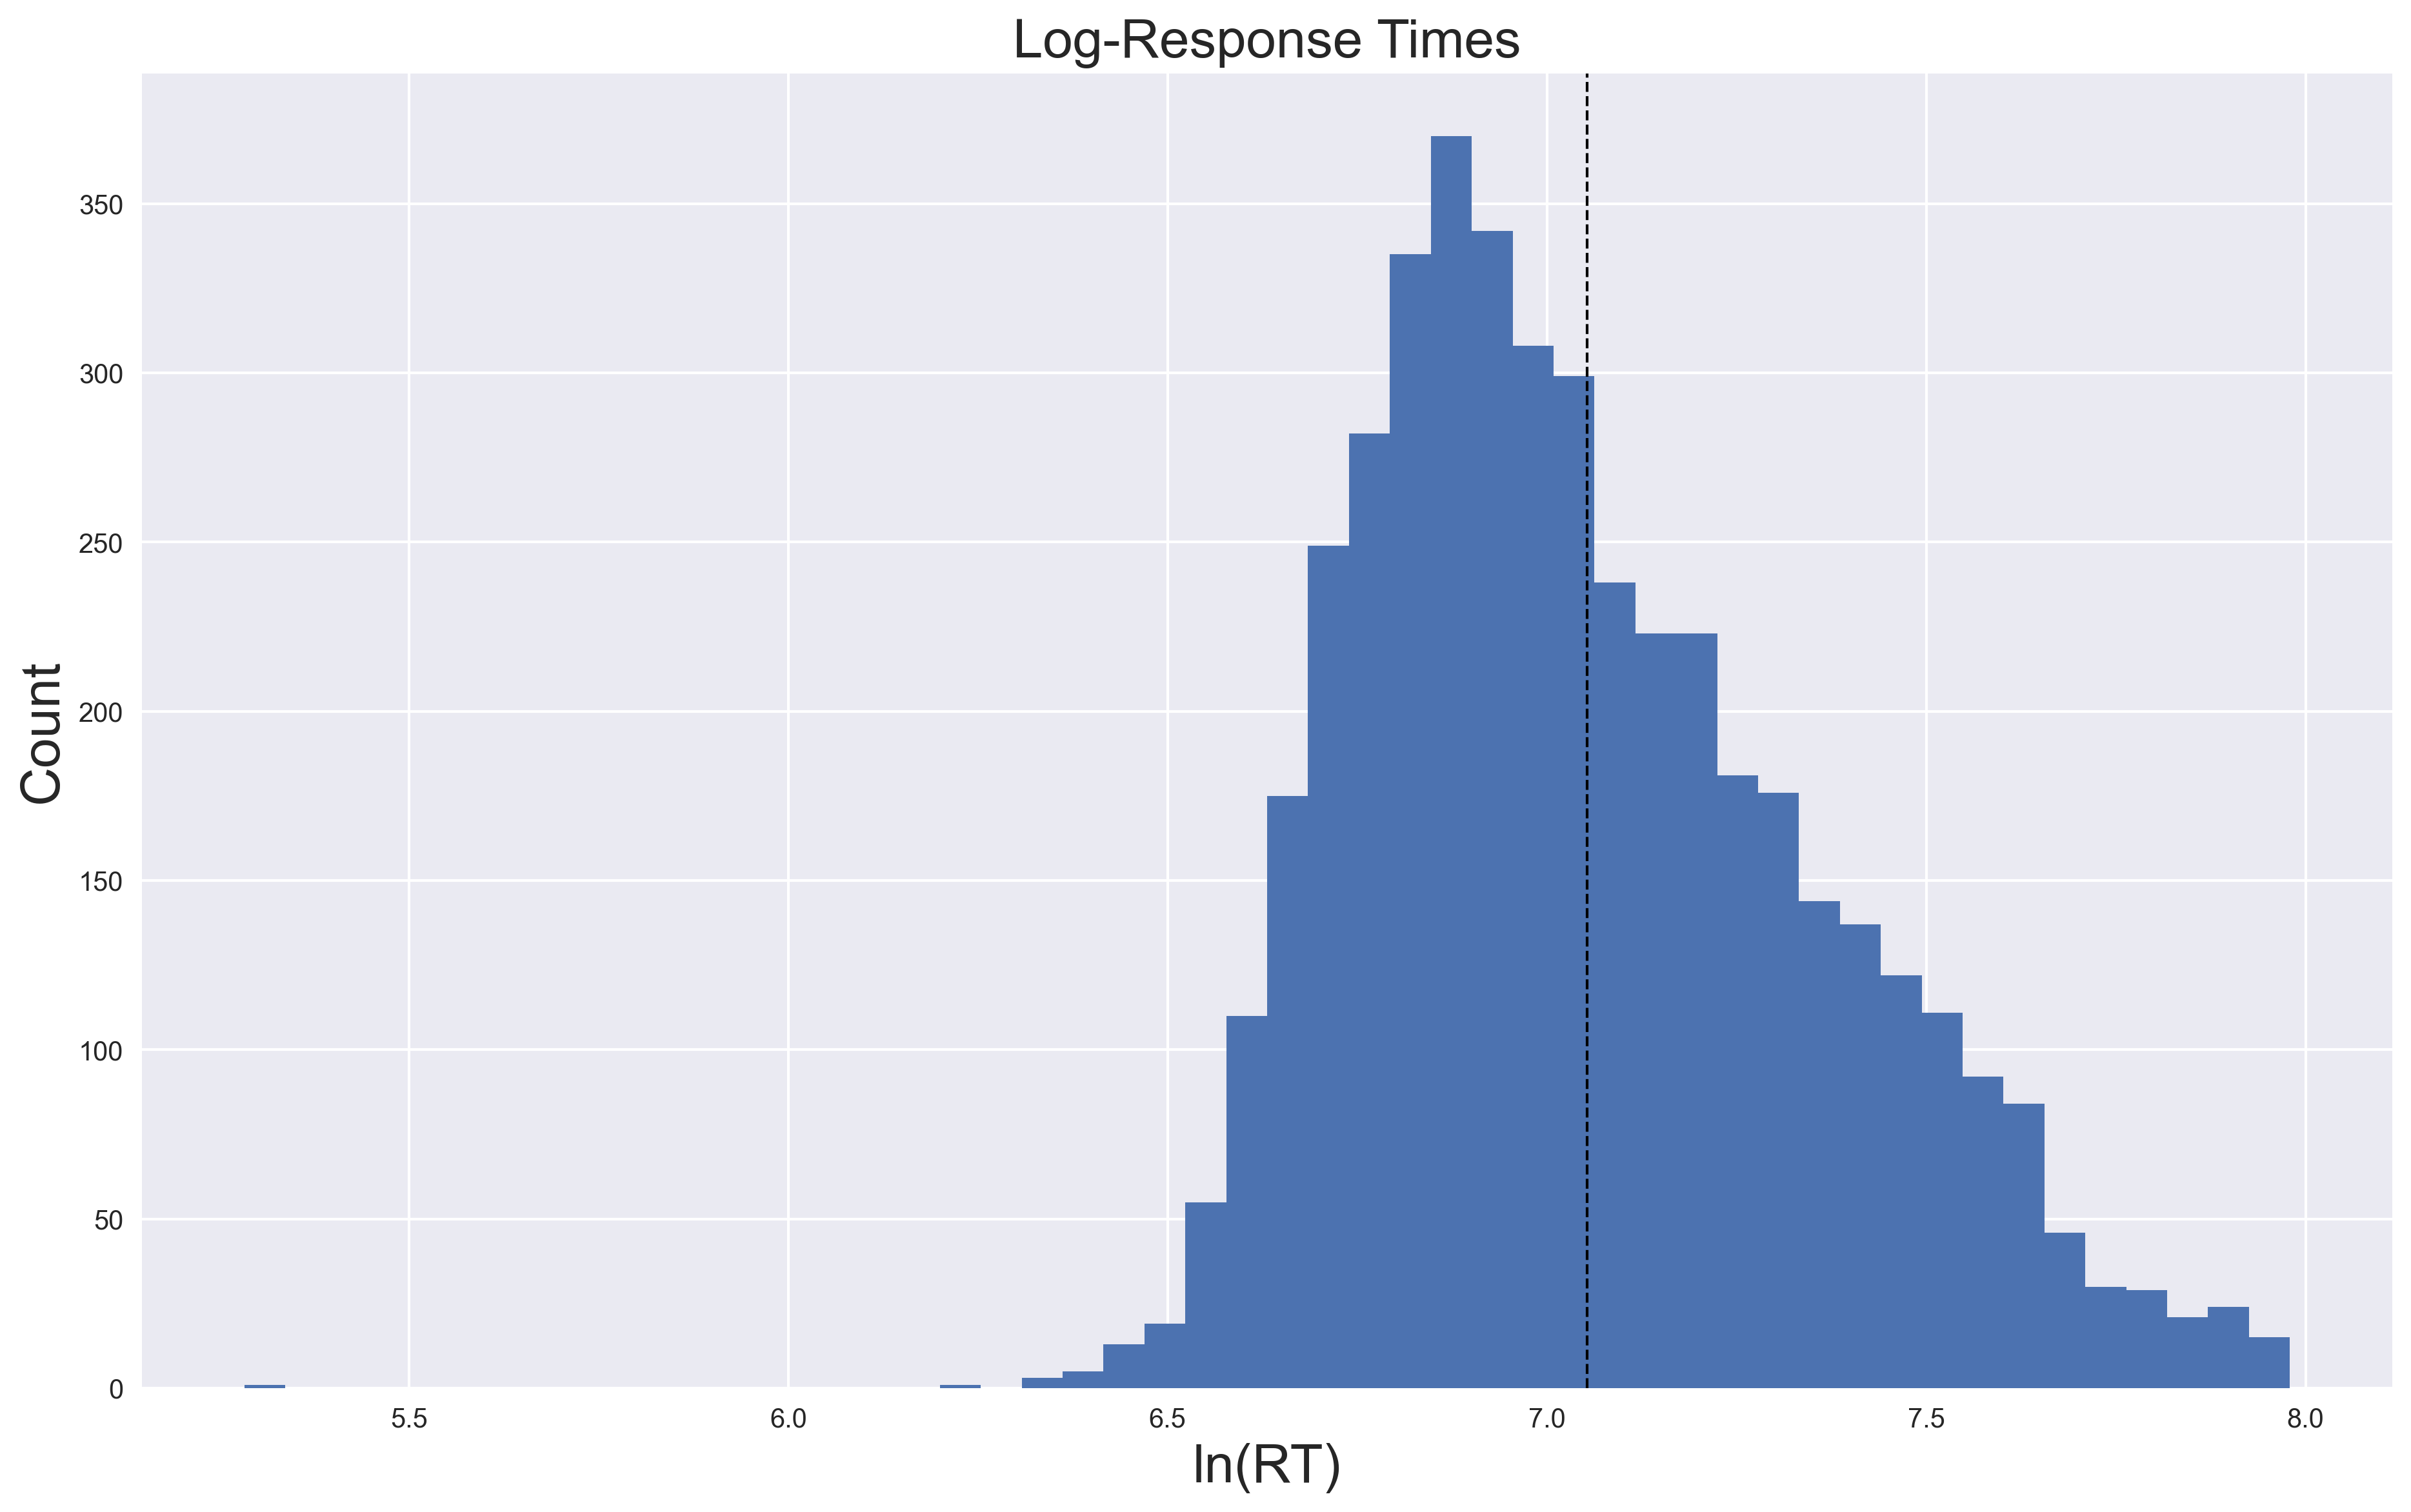

In [22]:
figure(figsize=(15, 9), dpi=300)
plt.hist(responses.log_rt, bins=50)
plt.axvline(responses.log_rt.mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Log-Response Times",fontsize=20)
plt.xlabel("ln(RT)",fontsize=20)
plt.ylabel("Count",fontsize=20)
plt.show()

### QQ Plots

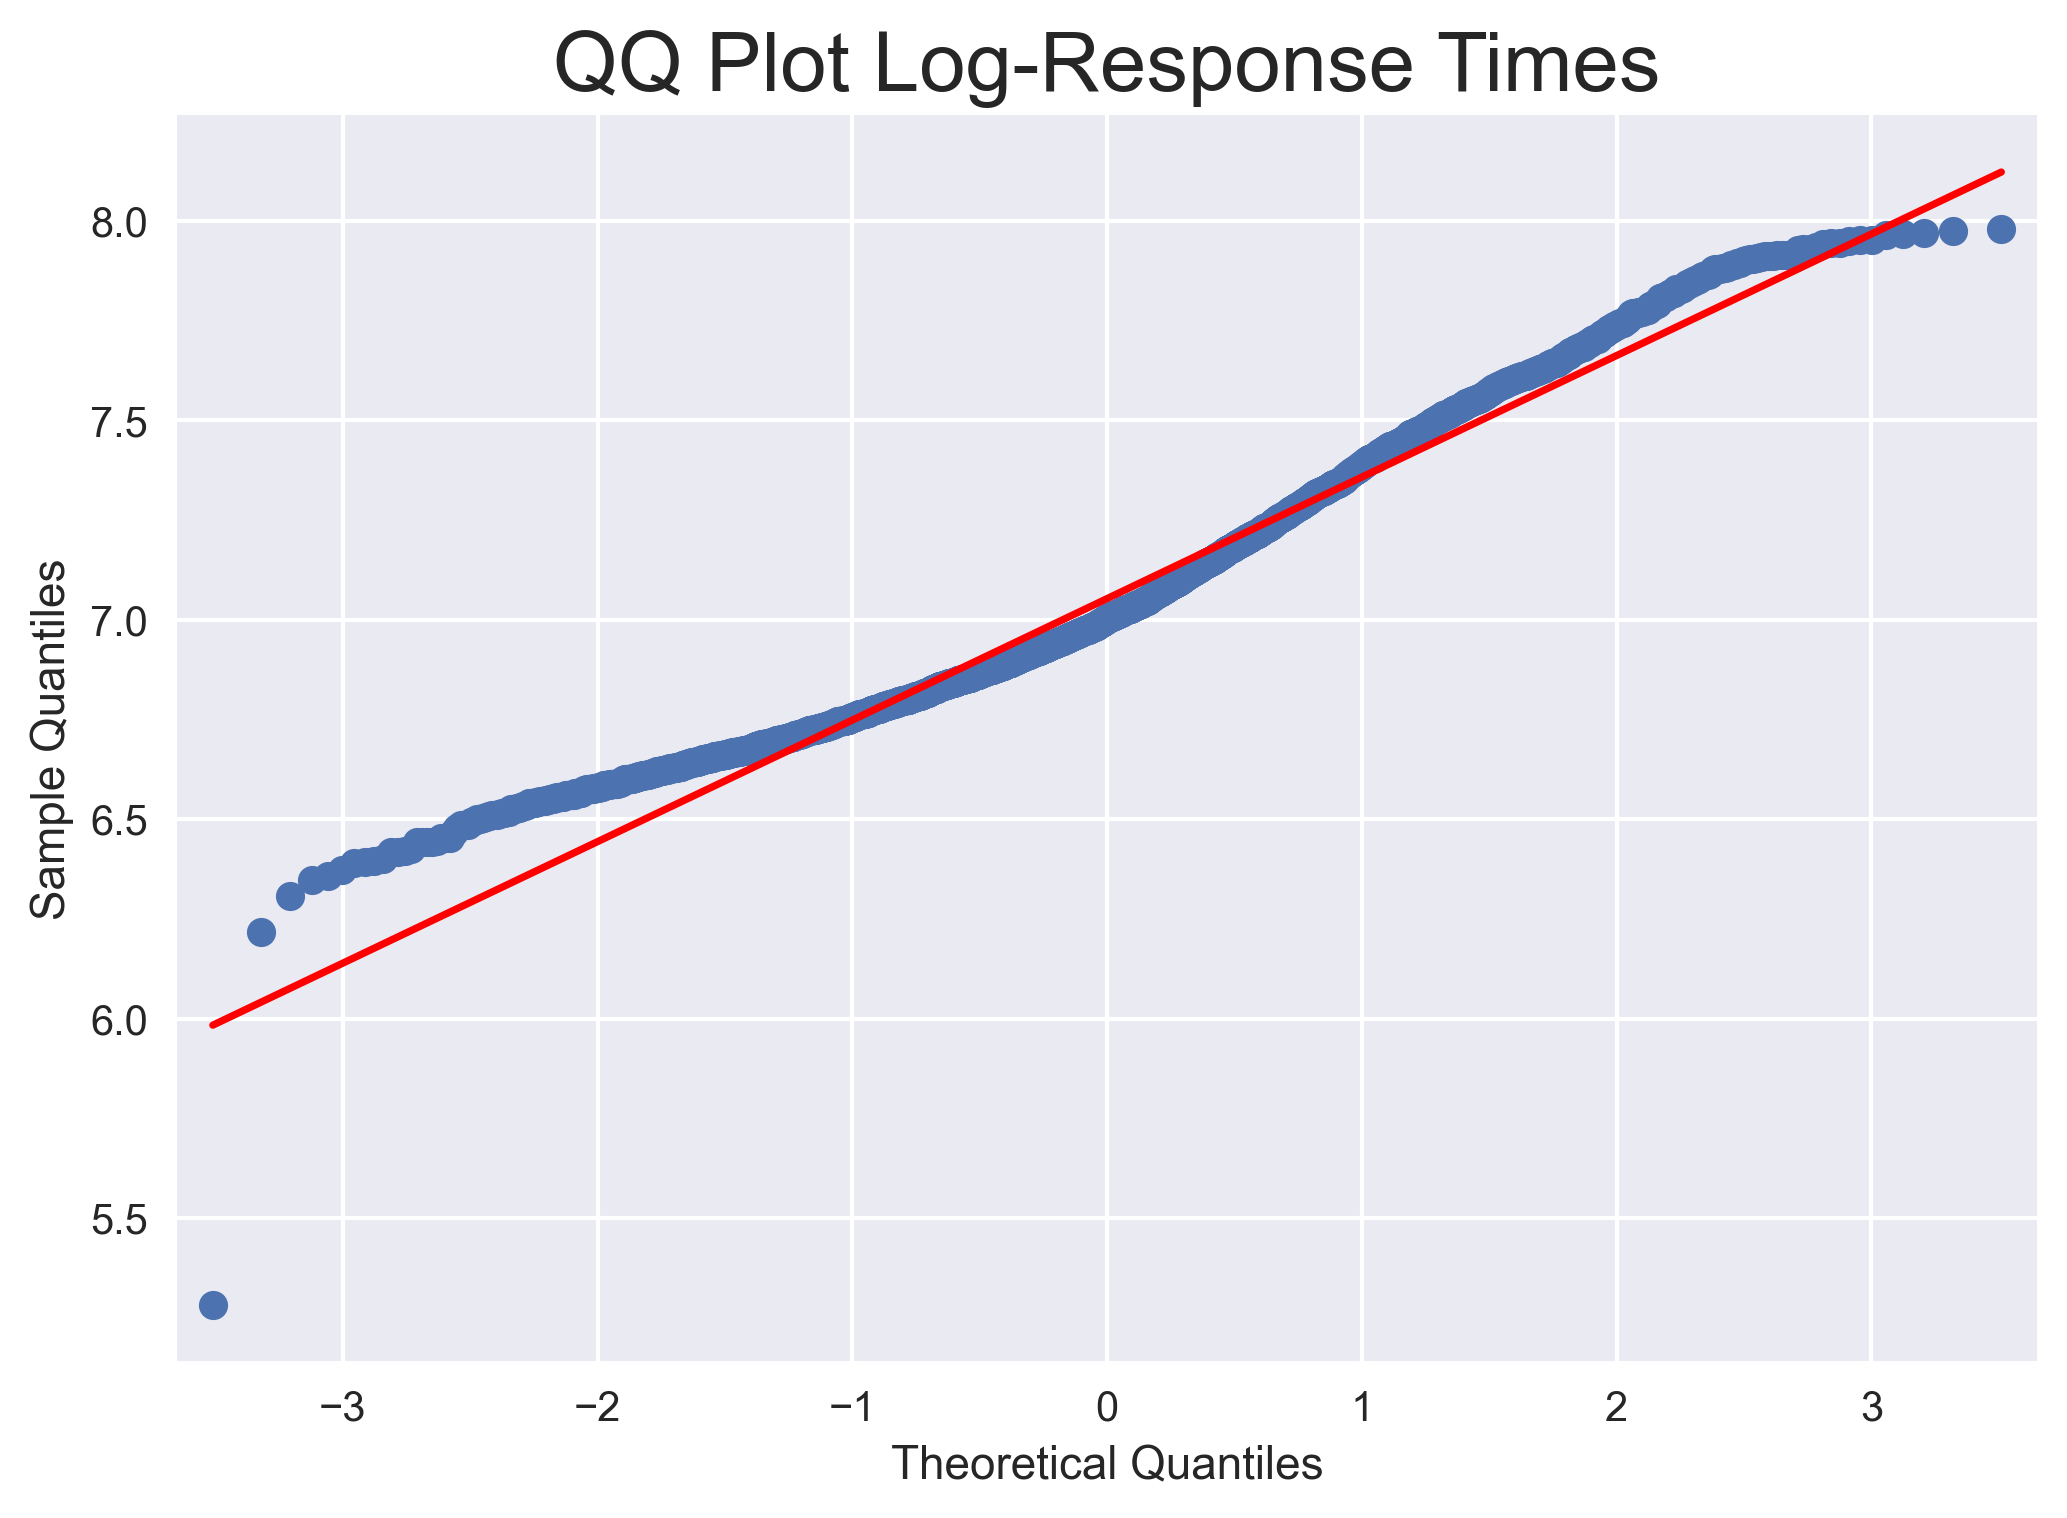

In [24]:
fig = qqplot(responses.log_rt, line='s');
fig.figsize = (15, 9)
fig.dpi = 300
plt.title("QQ Plot Log-Response Times",fontsize=20)
plt.show()

## Analysis

### Boxplots

#### Log RT Per Participant

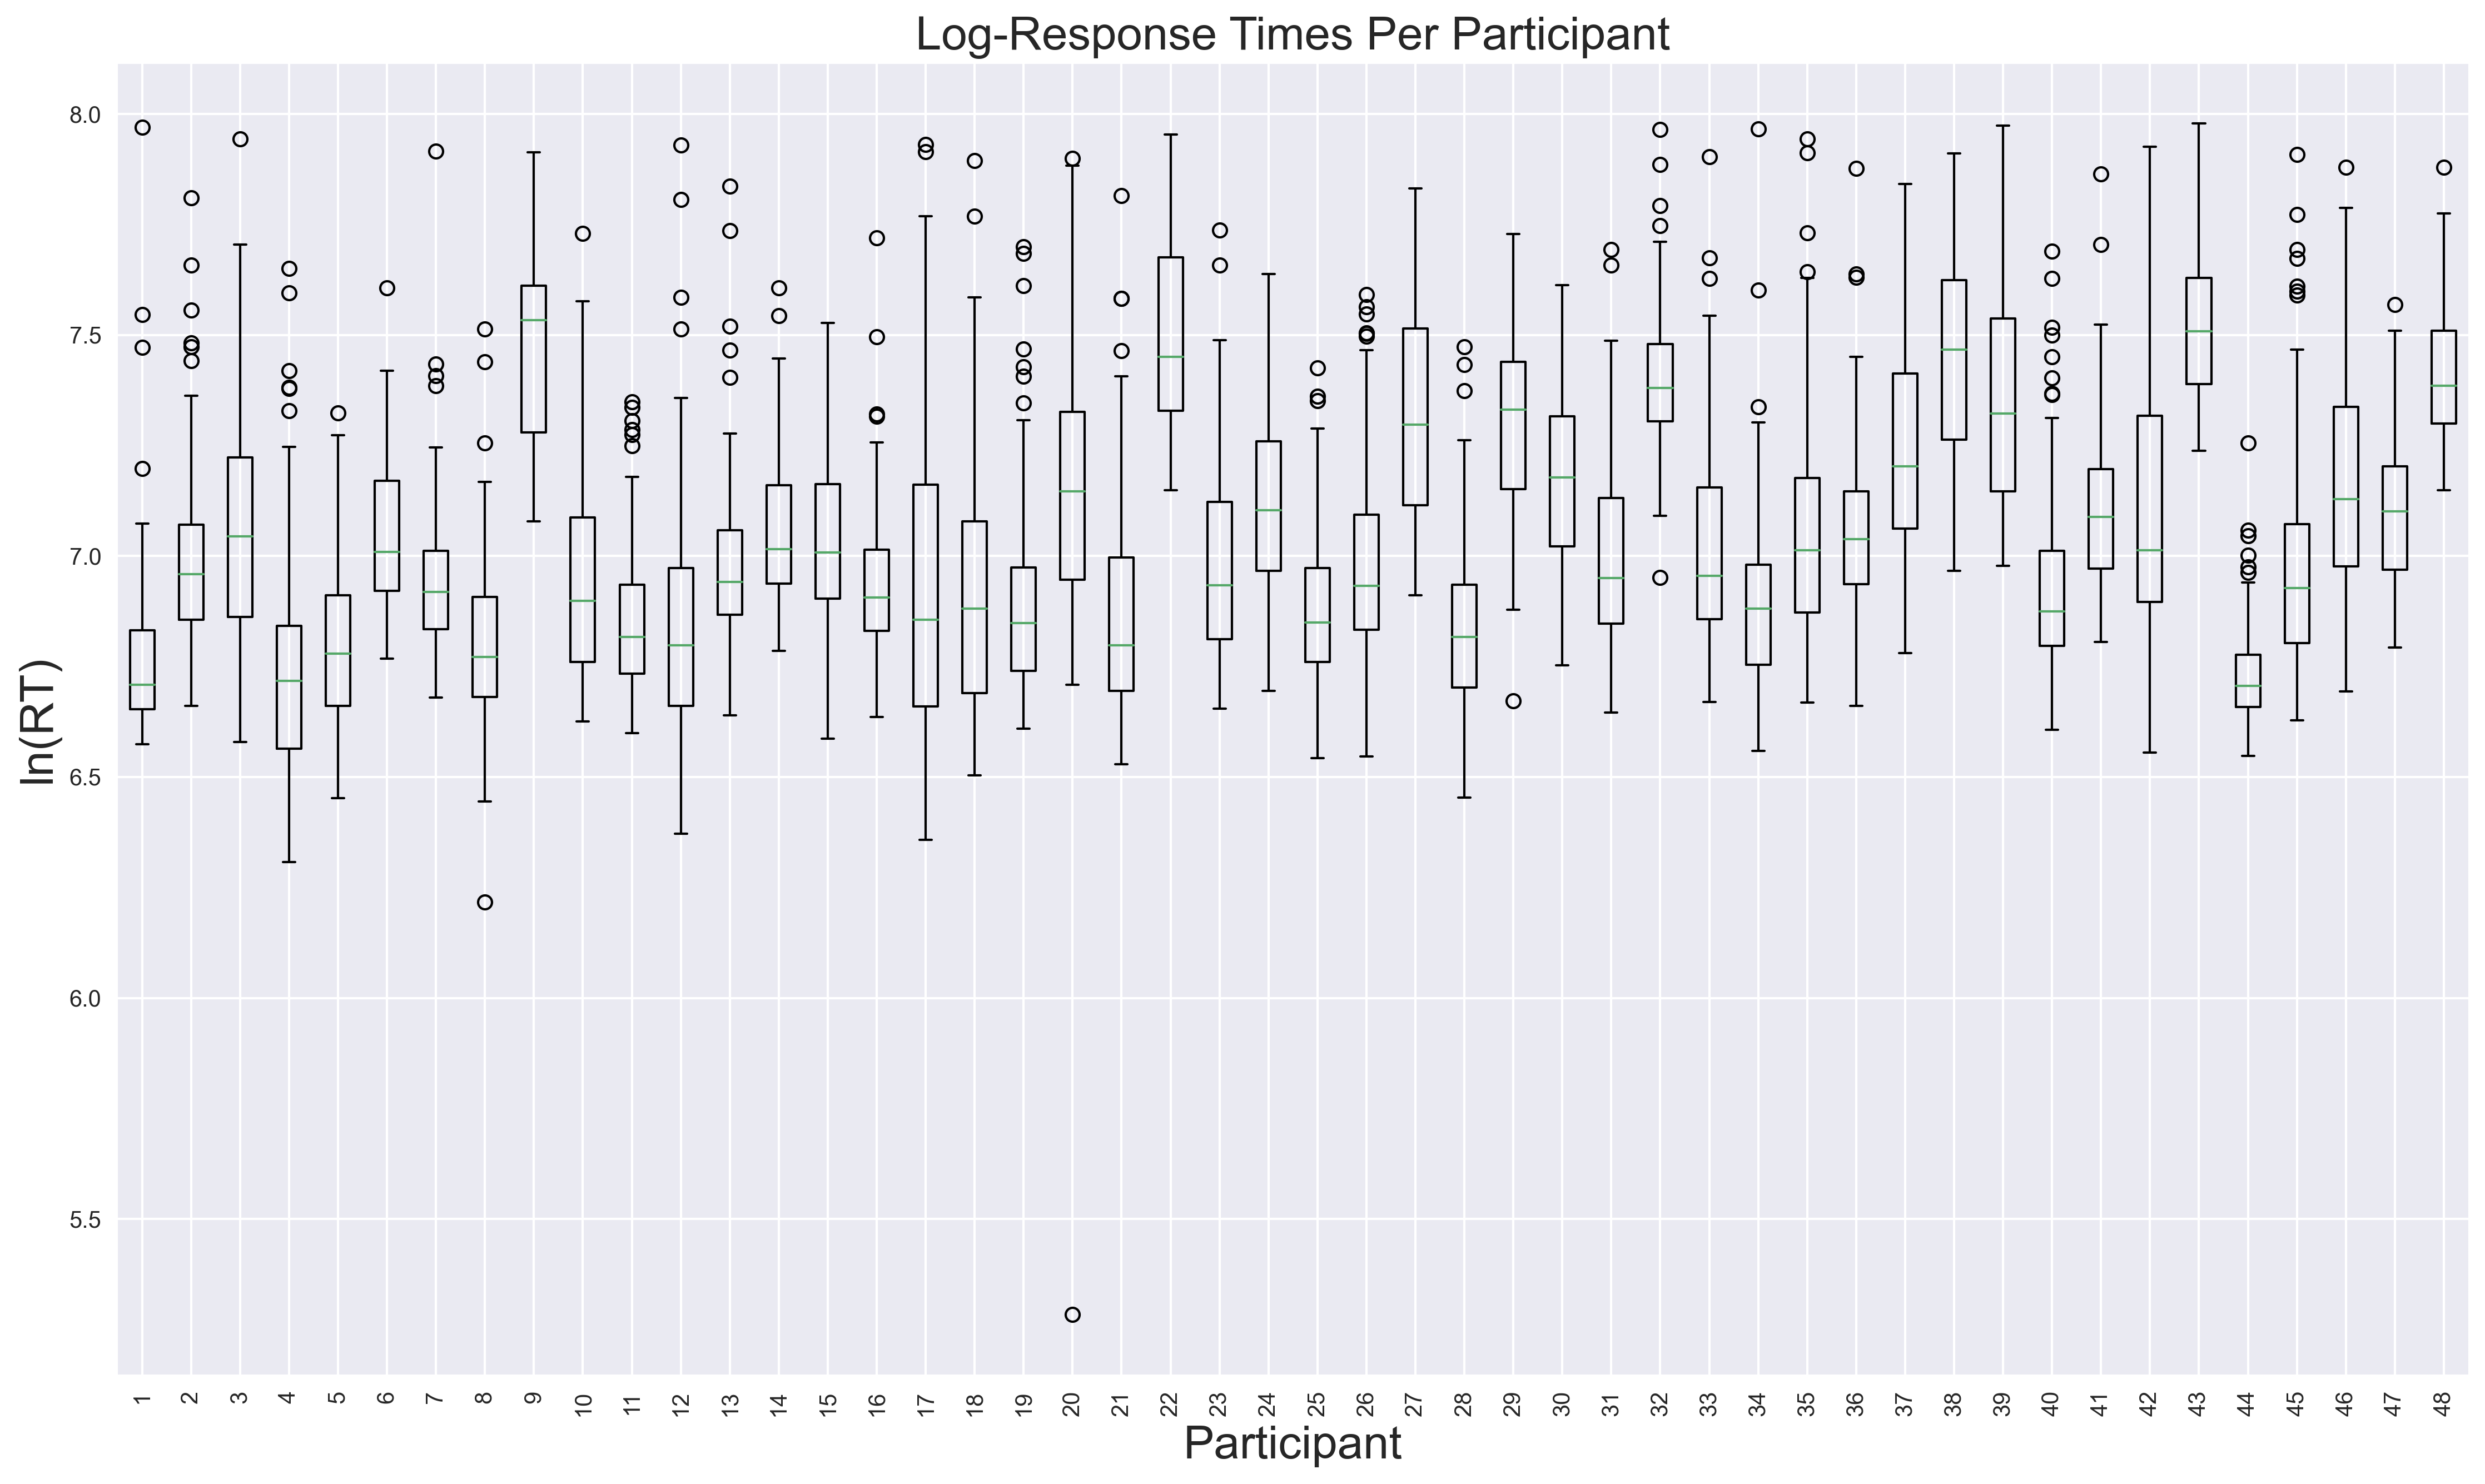

In [26]:
figure(figsize=(15, 9), dpi=300)
plt.boxplot(responses.groupby(["subject_id"]).log_rt.apply(list))
plt.title("Log-Response Times Per Participant",fontsize=20)
plt.ylabel("ln(RT)",fontsize=20)
plt.xlabel("Participant",fontsize=20)
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

#### Log RT Per Scene

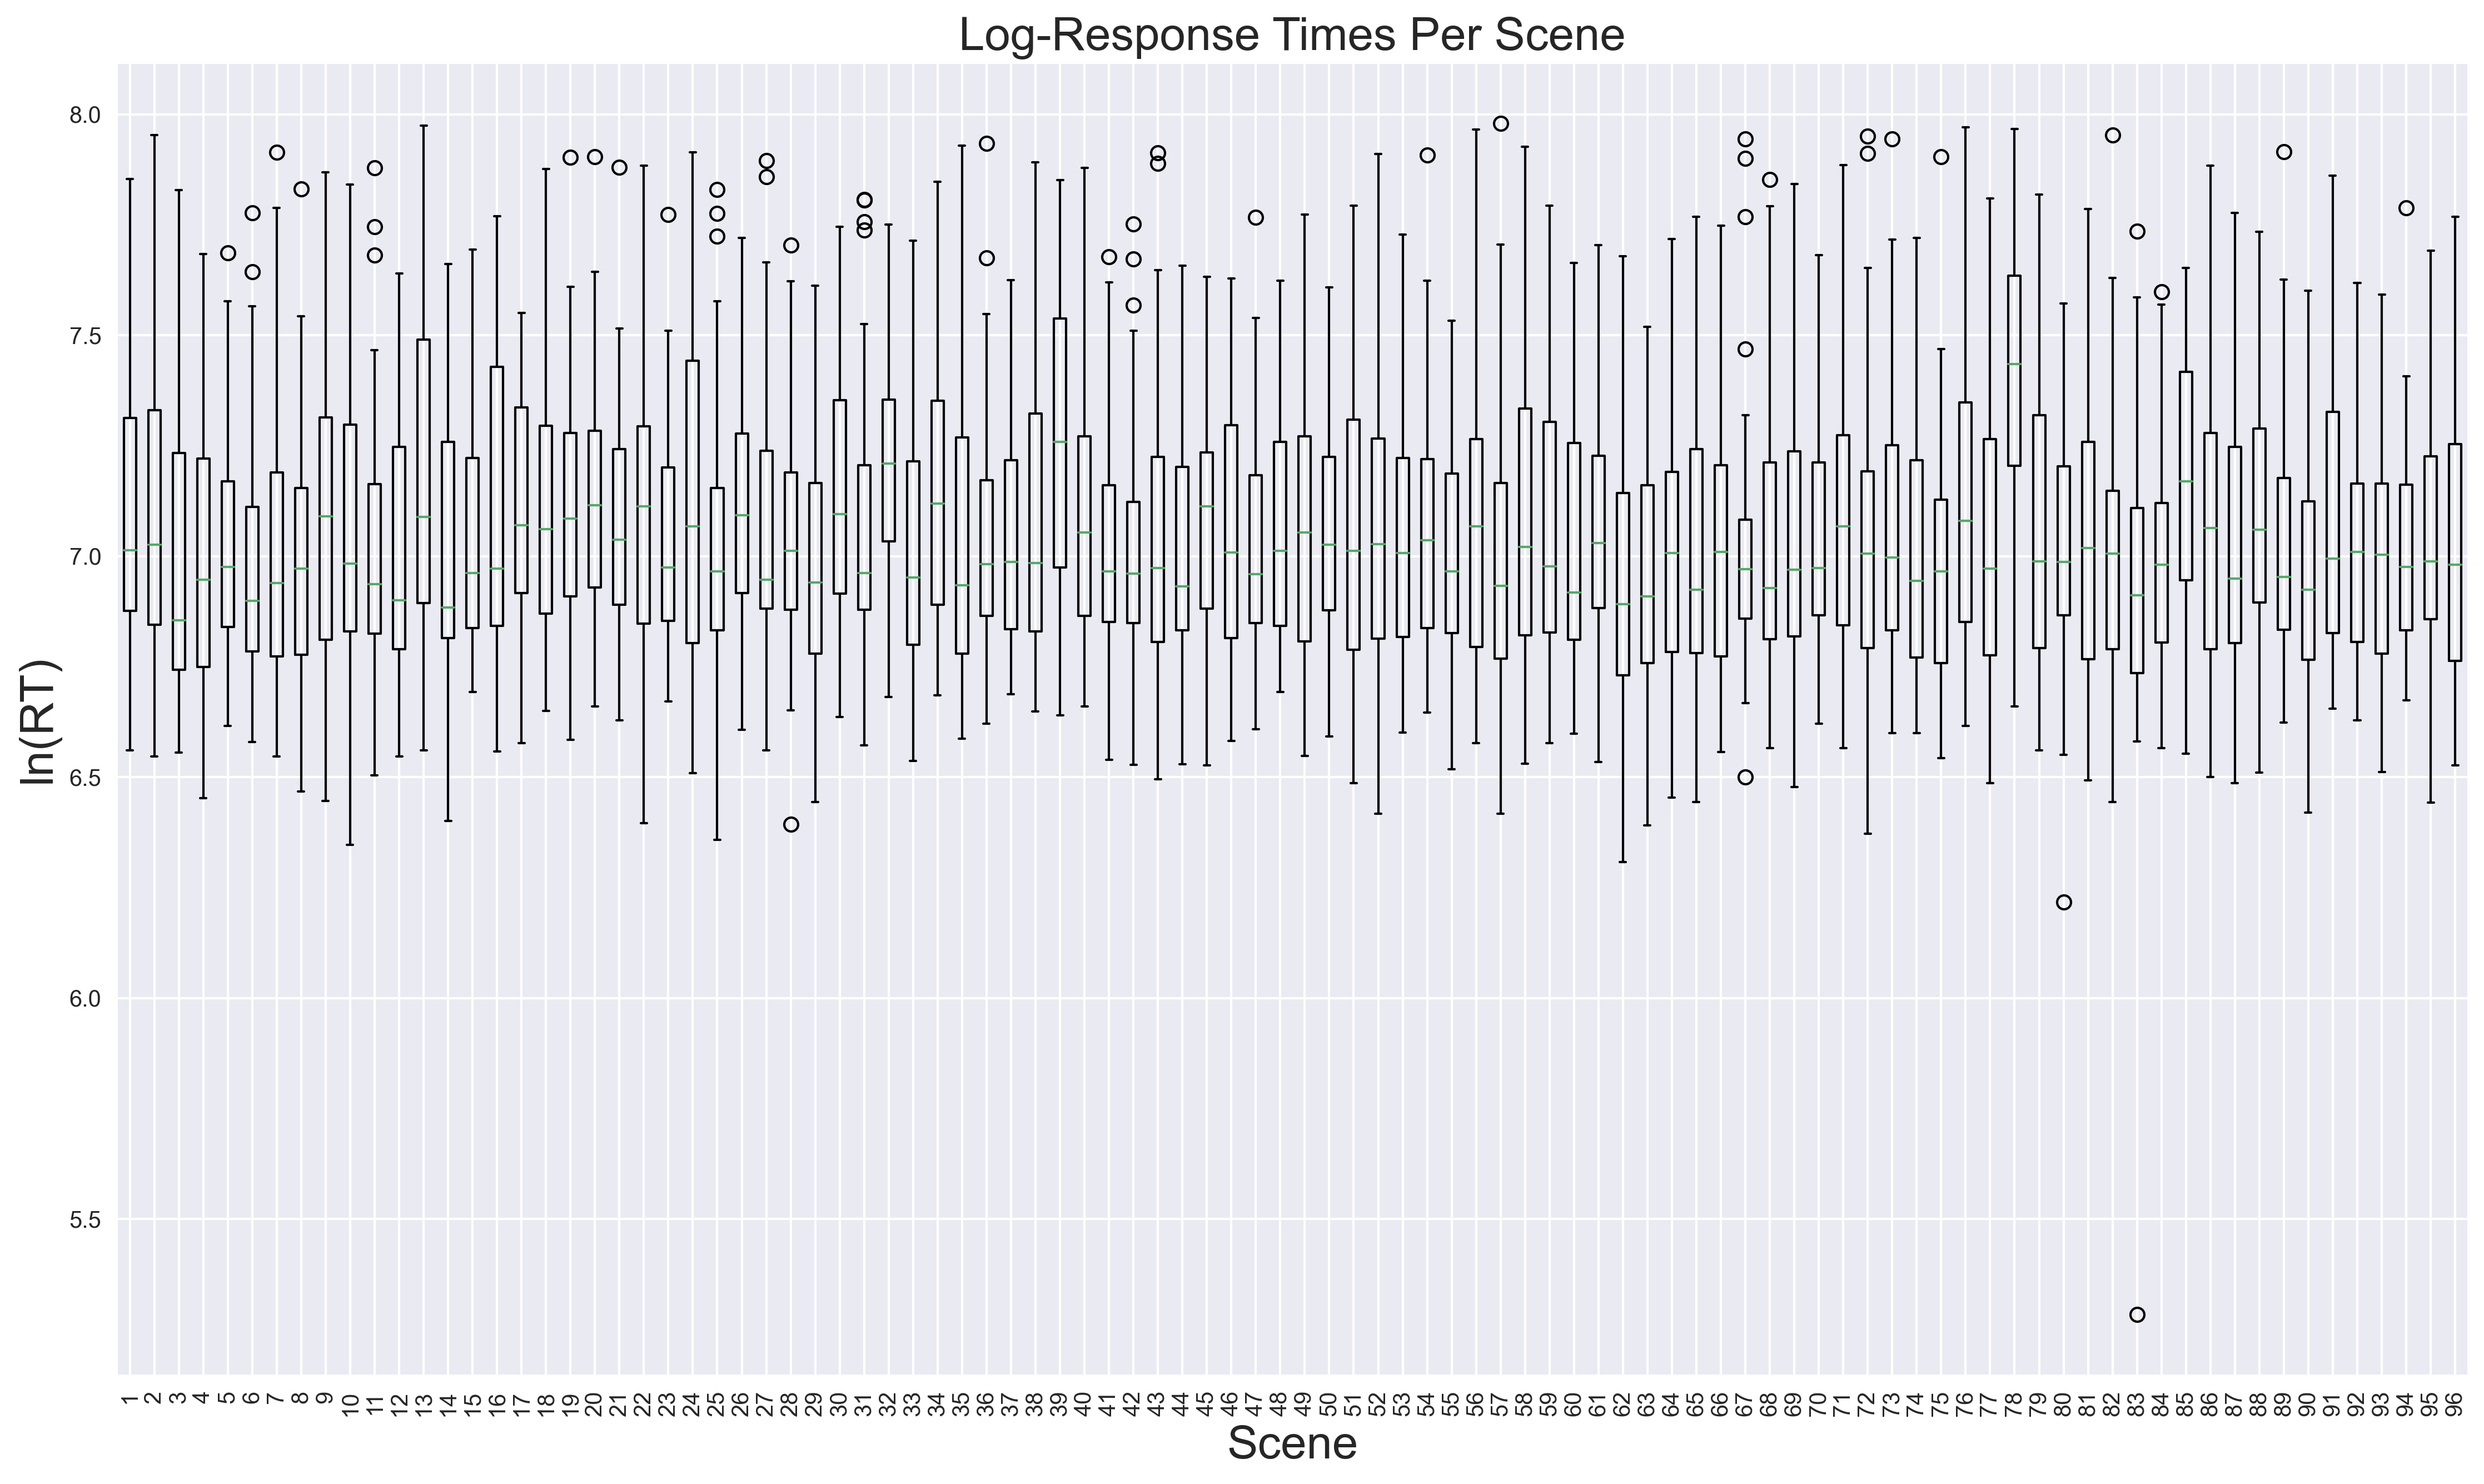

In [27]:
figure(figsize=(15, 9), dpi=300)
plt.boxplot(responses.groupby(["scene"]).log_rt.apply(list))
plt.title("Log-Response Times Per Scene",fontsize=20)
plt.ylabel("ln(RT)",fontsize=20)
plt.xlabel("Scene",fontsize=20)
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

In [28]:
responses[responses.trial_condition == "No"].groupby(["scene"]).trial_condition.value_counts()['scene_22']

trial_condition
No    48
Name: trial_condition, dtype: int64

#### Log RT for No Condition

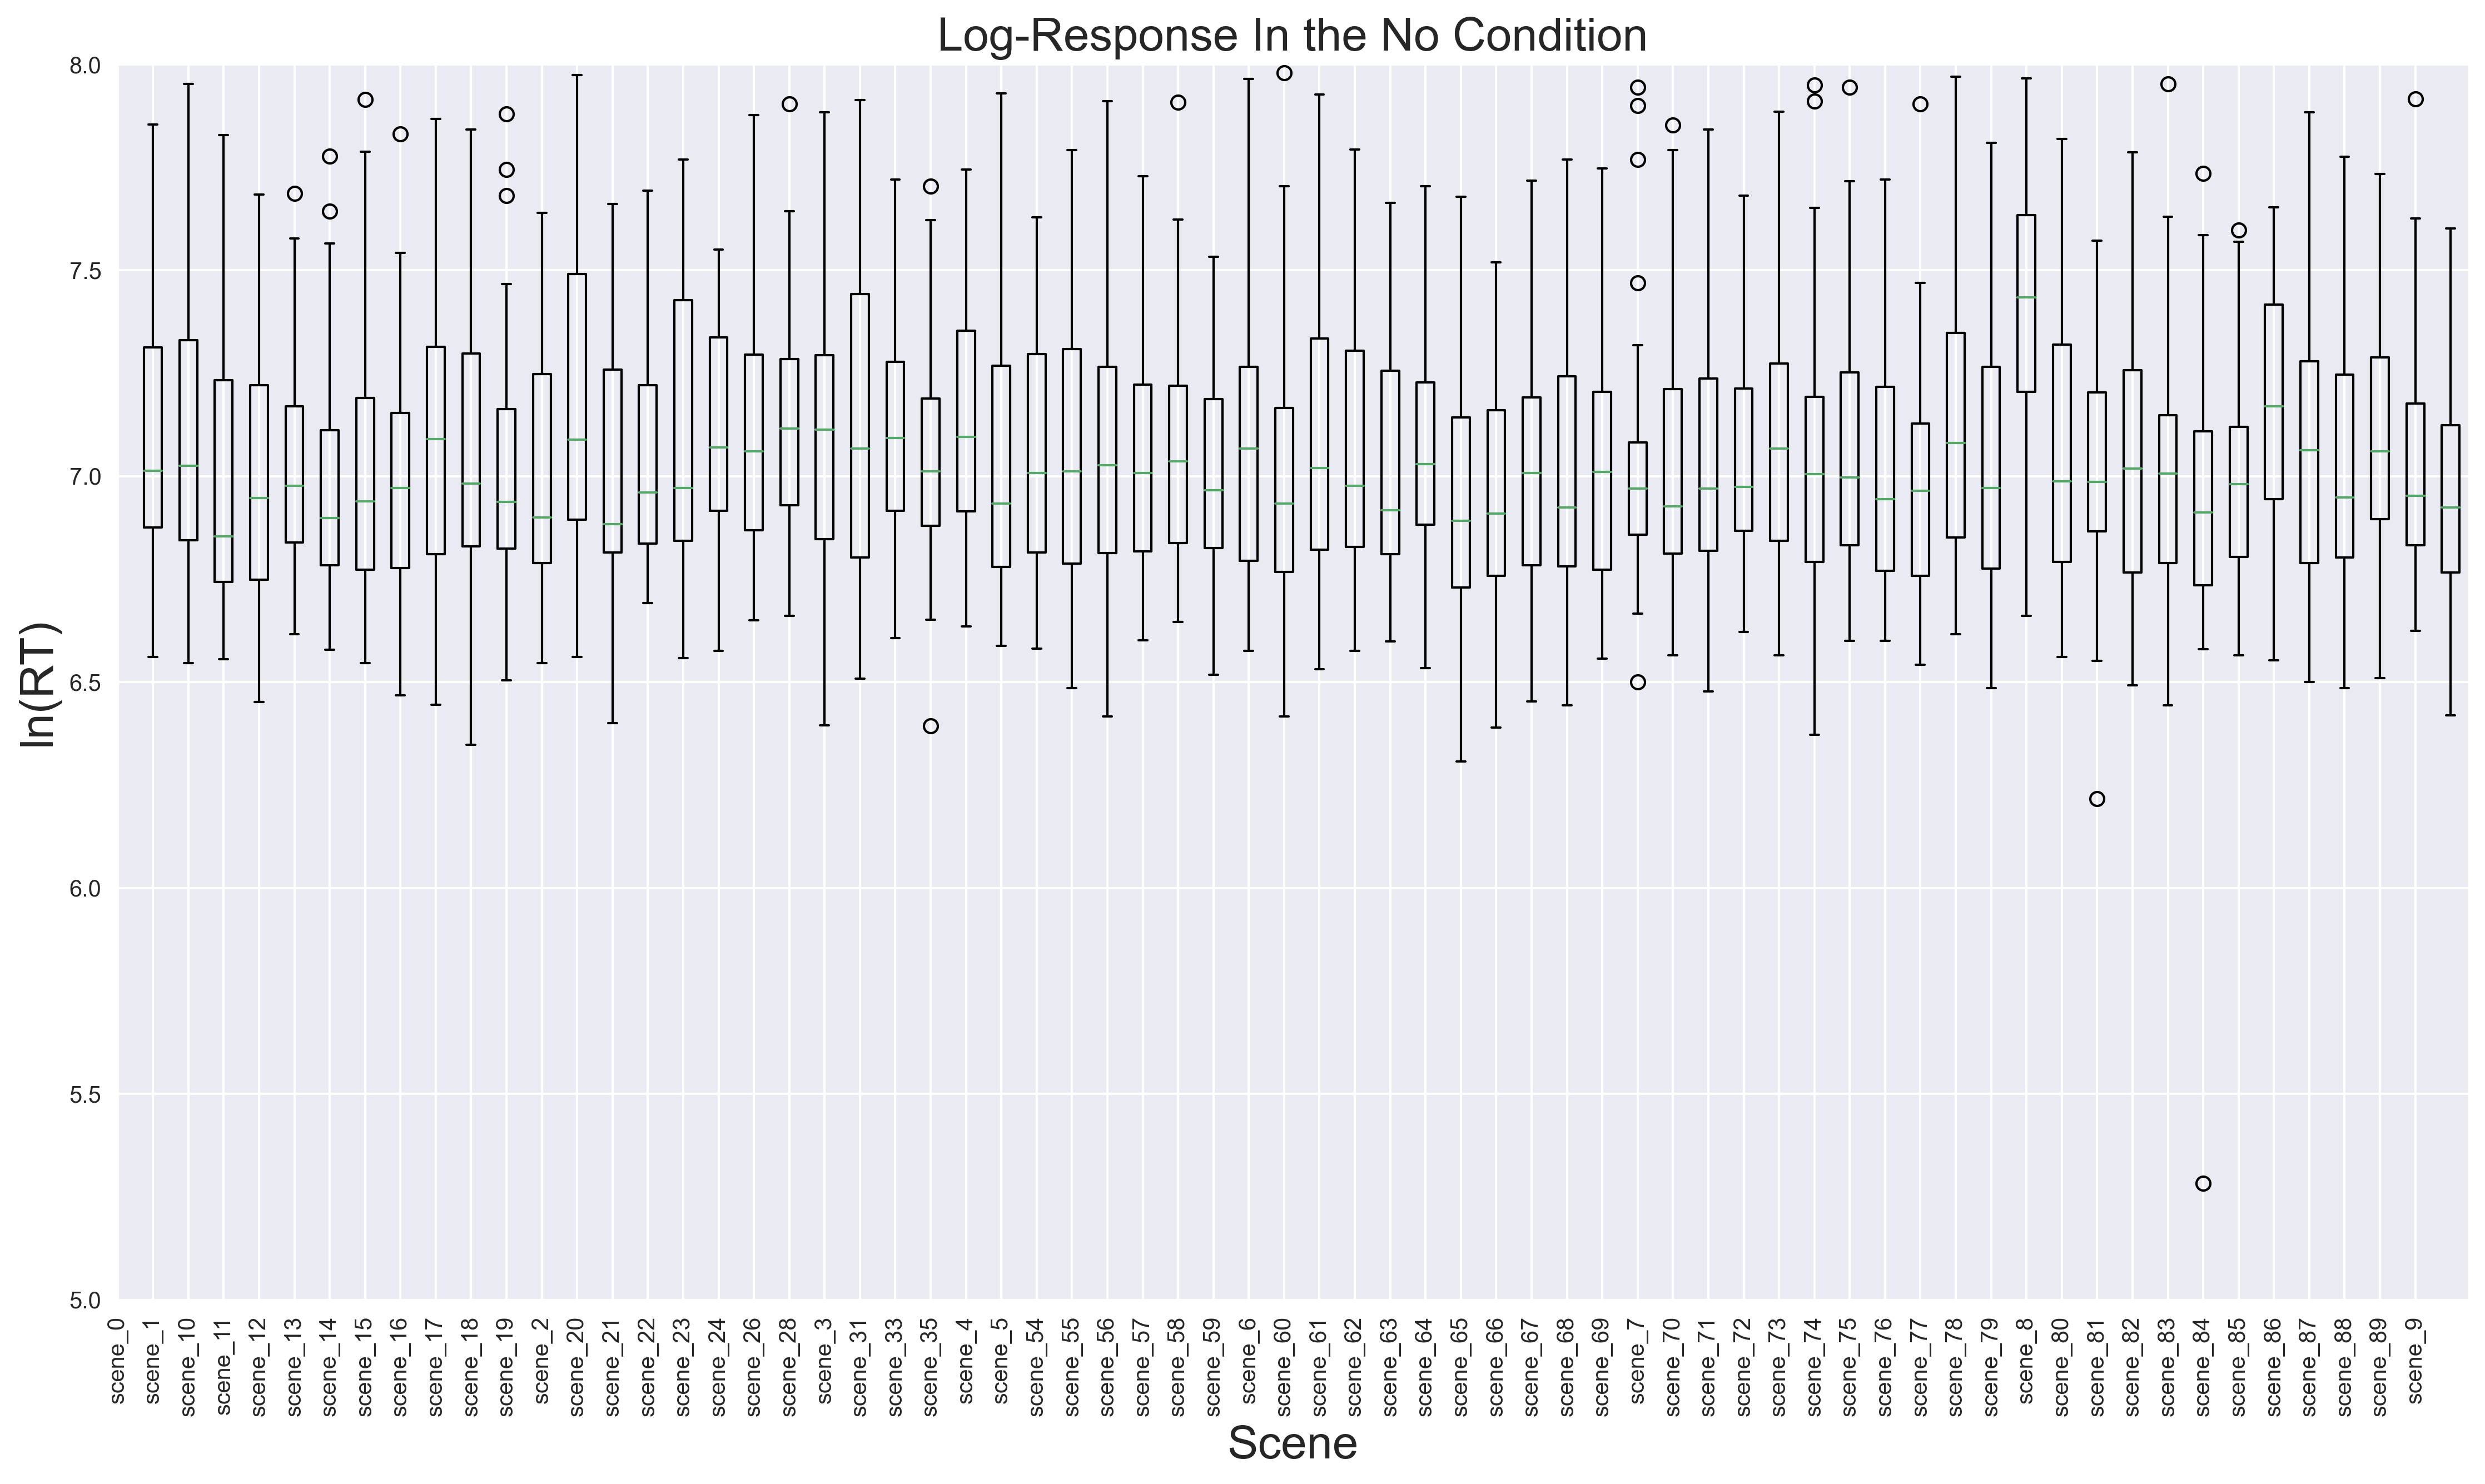

In [29]:
figure(figsize=(15, 9), dpi=300)
no_trials=responses[responses["trial_condition"]=="No"]

plt.boxplot(no_trials.groupby("scene").log_rt.apply(list))
# plt.scatter(no_trials.scene, 
#             no_trials.log_rt, 
#             s=4)
plt.title("Log-Response In the No Condition",fontsize=20)
plt.ylabel("ln(RT)",fontsize=20)
plt.xlabel("Scene",fontsize=20)
plt.xticks(list(range(len(list(no_trials.groupby(["scene"]).log_rt.apply(list).index)))), 
           list(no_trials.groupby(["scene"]).log_rt.apply(list).index), 
           rotation = 90)
plt.ylim(5,8)
plt.tight_layout()
plt.show()

#### Log RT for Yes Condition

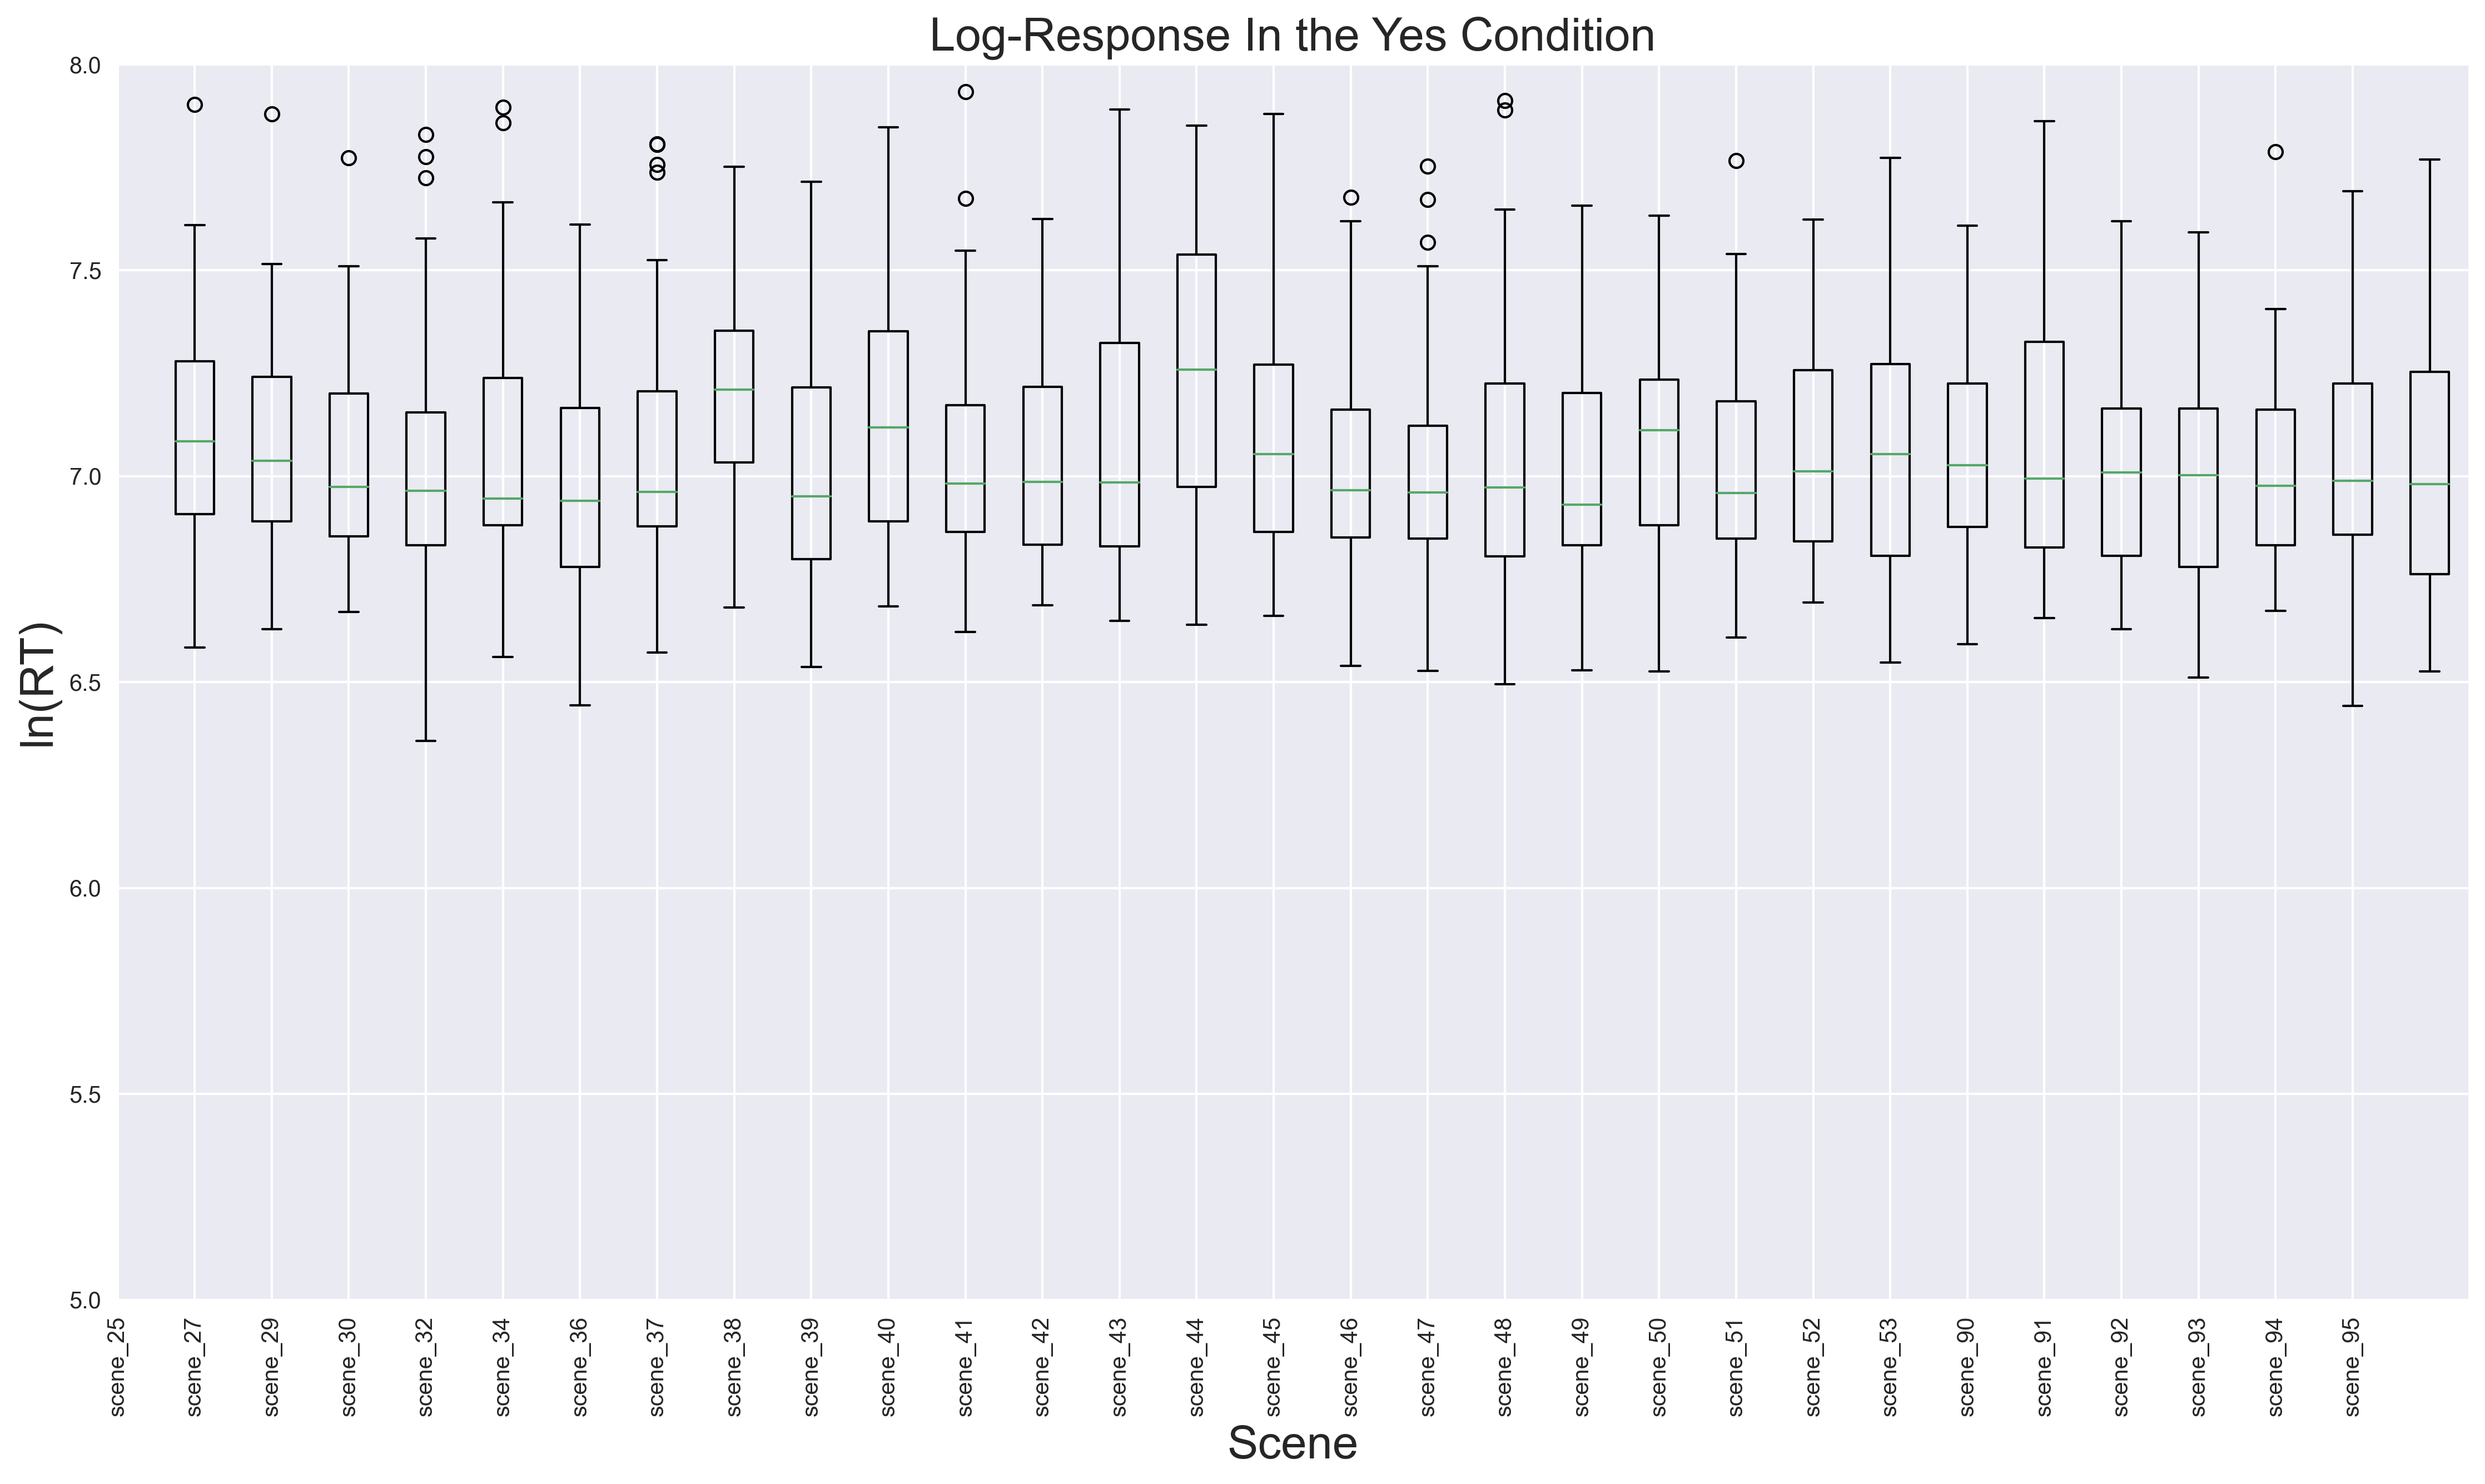

In [30]:
figure(figsize=(15, 9), dpi=300)
yes_trials=responses[responses["trial_condition"]=="Yes"]

plt.boxplot(yes_trials.groupby("scene").log_rt.apply(list))
plt.title("Log-Response In the Yes Condition",fontsize=20)
plt.ylabel("ln(RT)",fontsize=20)
plt.xlabel("Scene",fontsize=20)
plt.xticks(list(range(len(list(yes_trials.groupby("scene").log_rt.apply(list).index)))), 
           list(yes_trials.groupby("scene").log_rt.apply(list).index), 
           rotation = 90)
plt.ylim(5,8)
plt.tight_layout()
plt.show()

#### Z-Test on No/Yes Means

In [31]:
from statsmodels.stats.weightstats import ztest


no = list(responses[responses["trial_condition"]=="No"].groupby('subject_id').log_rt.mean())
yes = list(responses[responses["trial_condition"]=="Yes"].groupby('subject_id').log_rt.mean())
yes_mean = sum(yes)/len(yes)

print('mean=%.2f stdv=%.2f' % (np.mean(no), np.std(no)))
print('mean=%.2f stdv=%.2f' % (np.mean(yes), np.std(yes)))

ztest_score, p_value= ztest(no,value = yes_mean, alternative='two-sided')
print(p_value)
print(ztest_score)

mean=7.06 stdv=0.21
mean=7.06 stdv=0.21
0.8558103950693304
-0.1817099014981183


#### Cumulative Log RT Per Trial

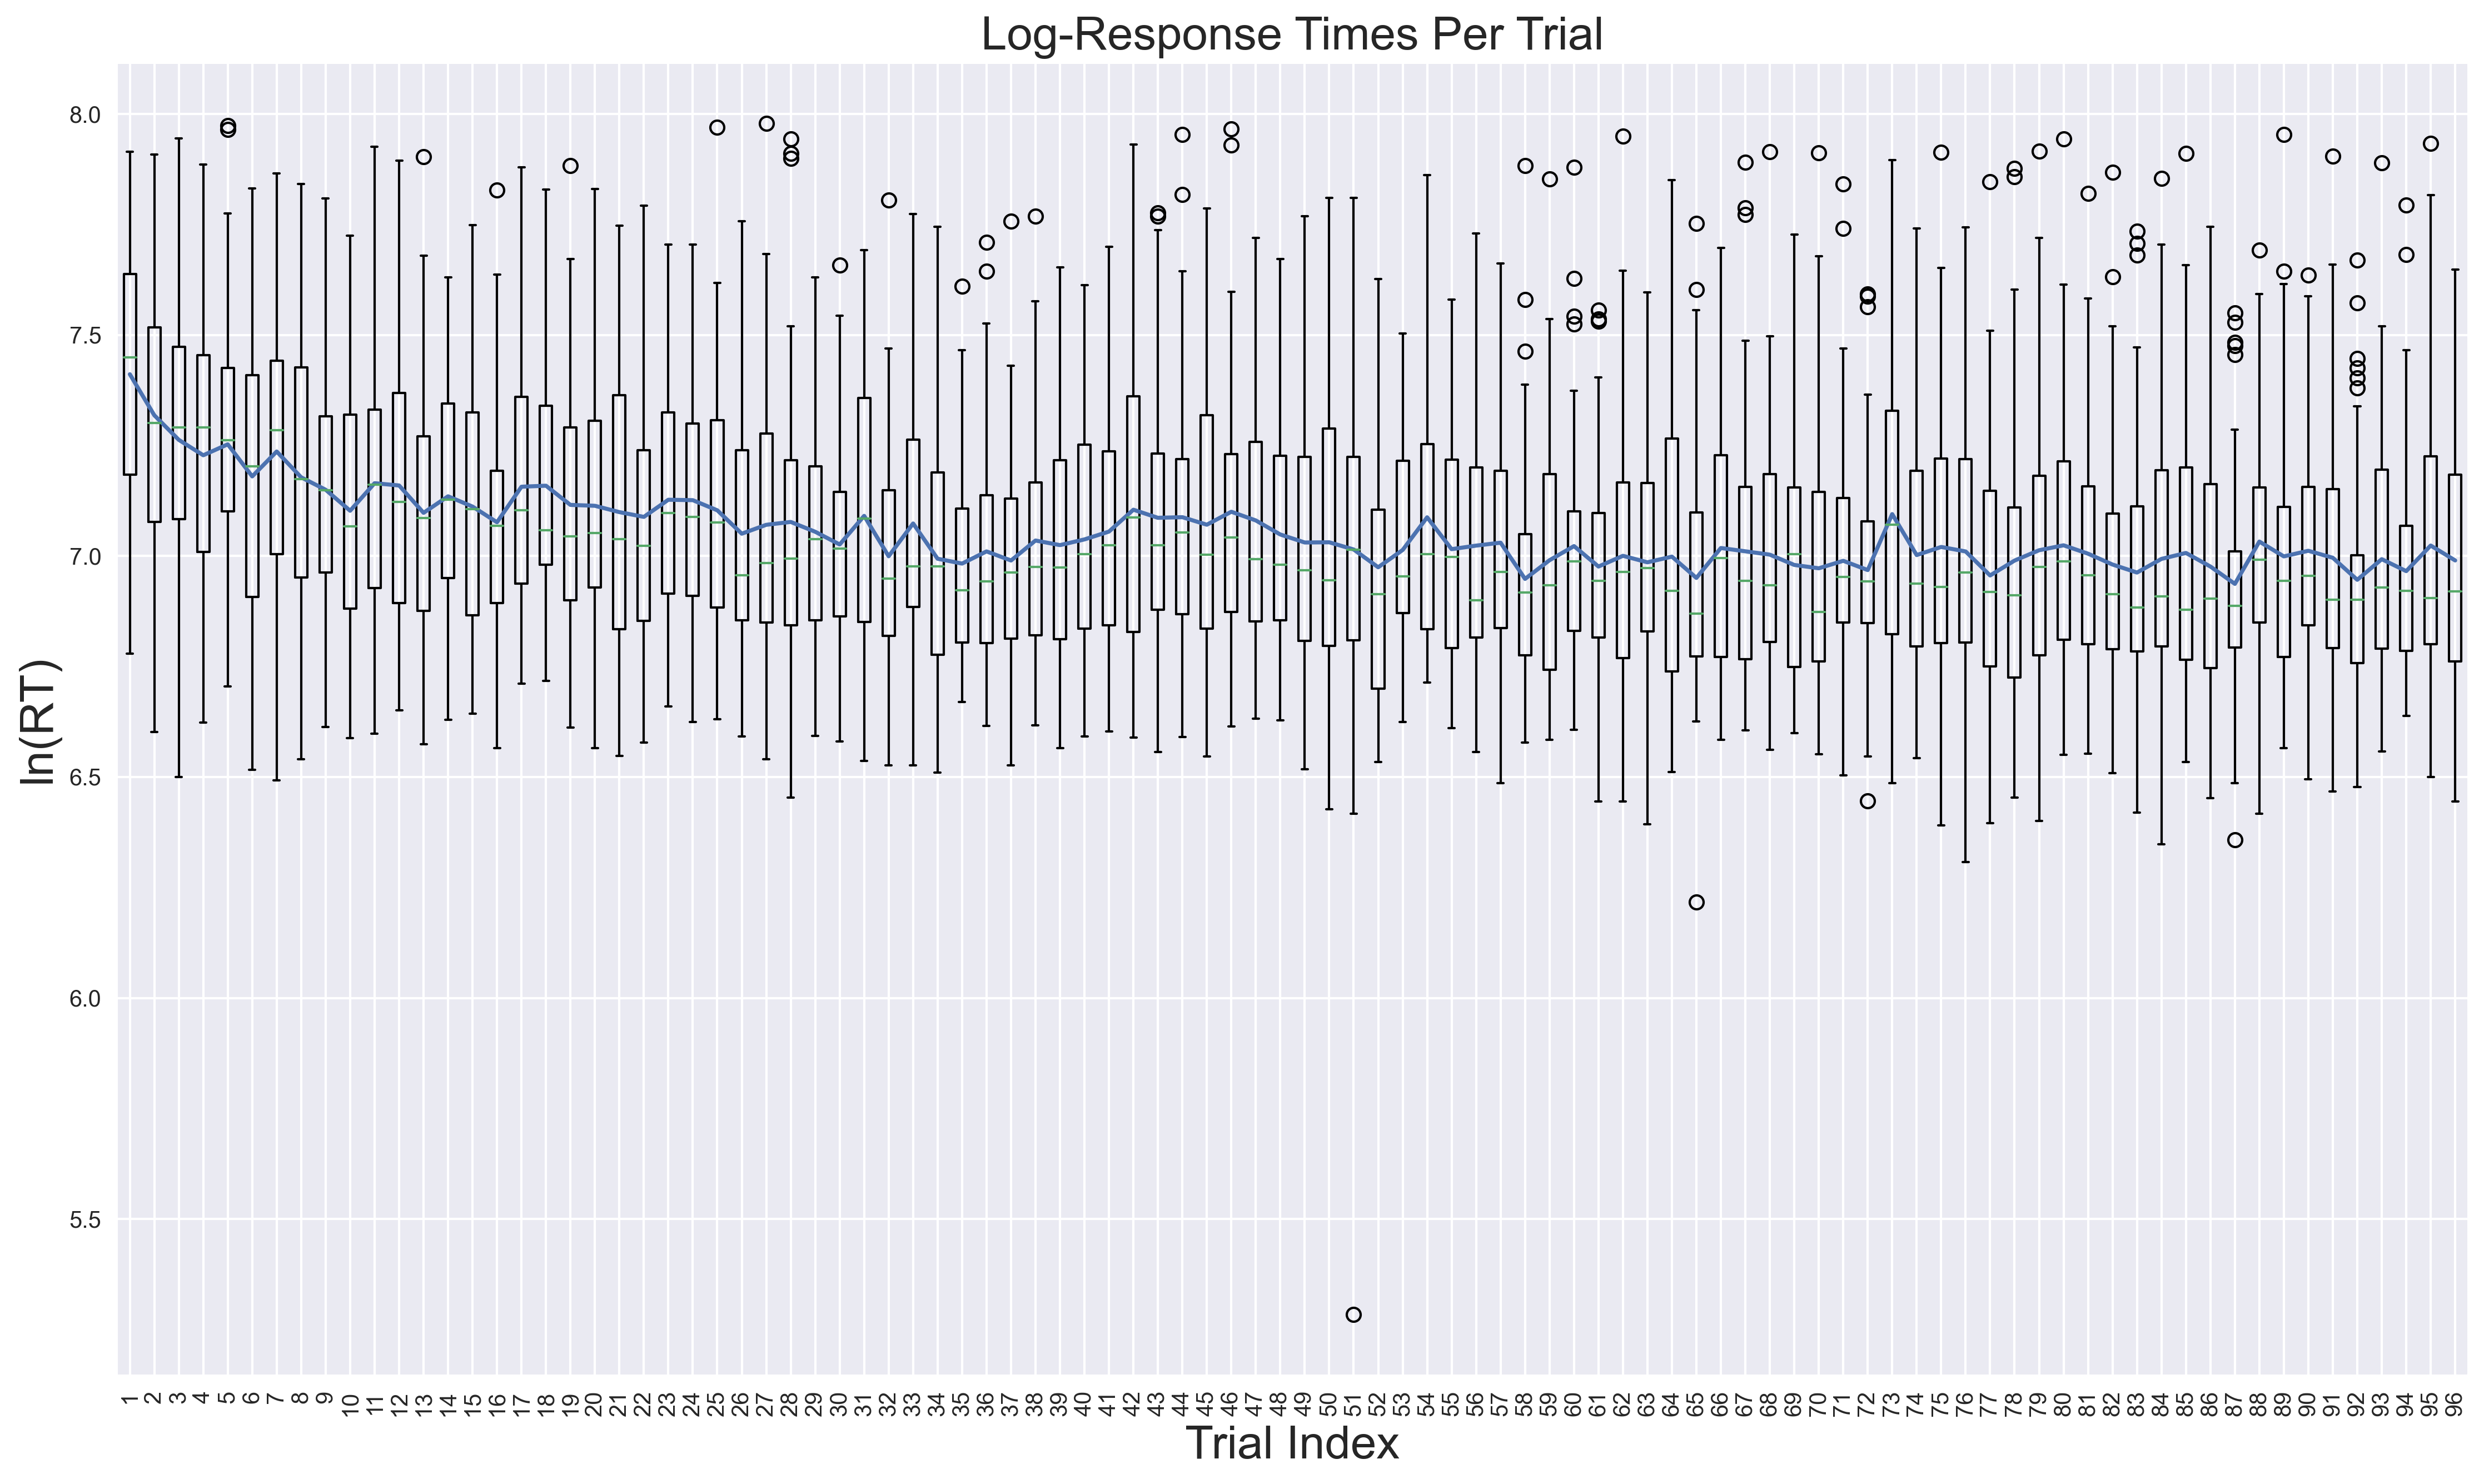

In [32]:
trial = responses.groupby("trial_index").log_rt.apply(list)
rtt=responses.groupby(["trial_index"]).log_rt.describe()["mean"]
rtt.index = list(range(1,len(rtt.index)+1))
figure(figsize=(15, 9), dpi=300)

plt.boxplot(trial)
plt.plot(rtt)
plt.xticks(rotation = 90)
plt.title("Log-Response Times Per Trial",fontsize=20)
plt.xlabel("Trial Index",fontsize=20)
plt.ylabel("ln(RT)",fontsize=20)
plt.tight_layout()
plt.show()

### Histograms

#### Number of people correctly responding on Yes trials

trial_condition  correct
No               True       2947
                 False       125
Yes              True       1298
                 False        93
Name: correct, dtype: int64


Text(0.5, 0, 'Response')

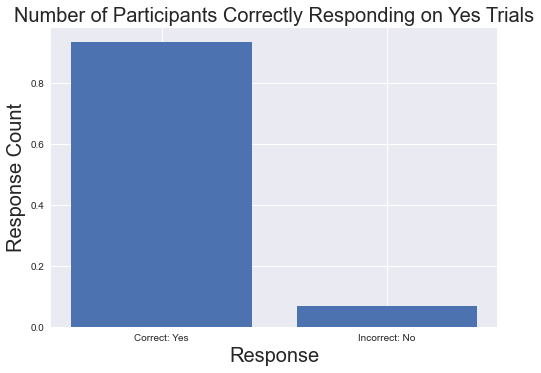

In [33]:
# How many people got the "Yes" trials correct?
y=responses.groupby("trial_condition").correct.value_counts()
print(y)
no = y['No']
yes = y['Yes']

no_correct = no[True] / (no[True]+no[False])
no_wrong = no[False] / (no[True]+no[False])

yes_correct = yes[True] / (yes[True]+yes[False])
yes_wrong = yes[False] / (yes[True]+yes[False])

plt.bar(["Correct: Yes","Incorrect: No"], [yes_correct,yes_wrong])
plt.title("Number of Participants Correctly Responding on Yes Trials",fontsize=20)
plt.ylabel("Response Count",fontsize=20)
plt.xlabel("Response",fontsize=20)

#### Number of people correctly responding on No trials

Text(0, 0.5, 'Response Count')

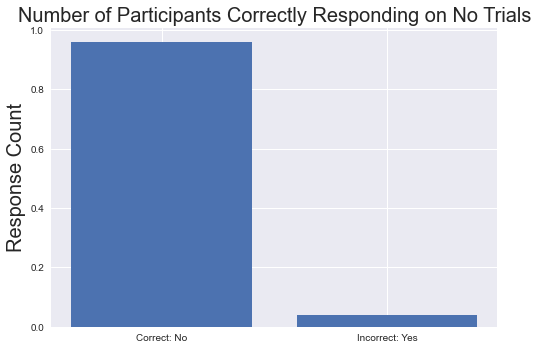

In [34]:
plt.bar(["Correct: No","Incorrect: Yes"], [no_correct,no_wrong])
plt.title("Number of Participants Correctly Responding on No Trials",fontsize=20)
plt.ylabel("Response Count",fontsize=20)

#### Log-Response Times Per Response Given

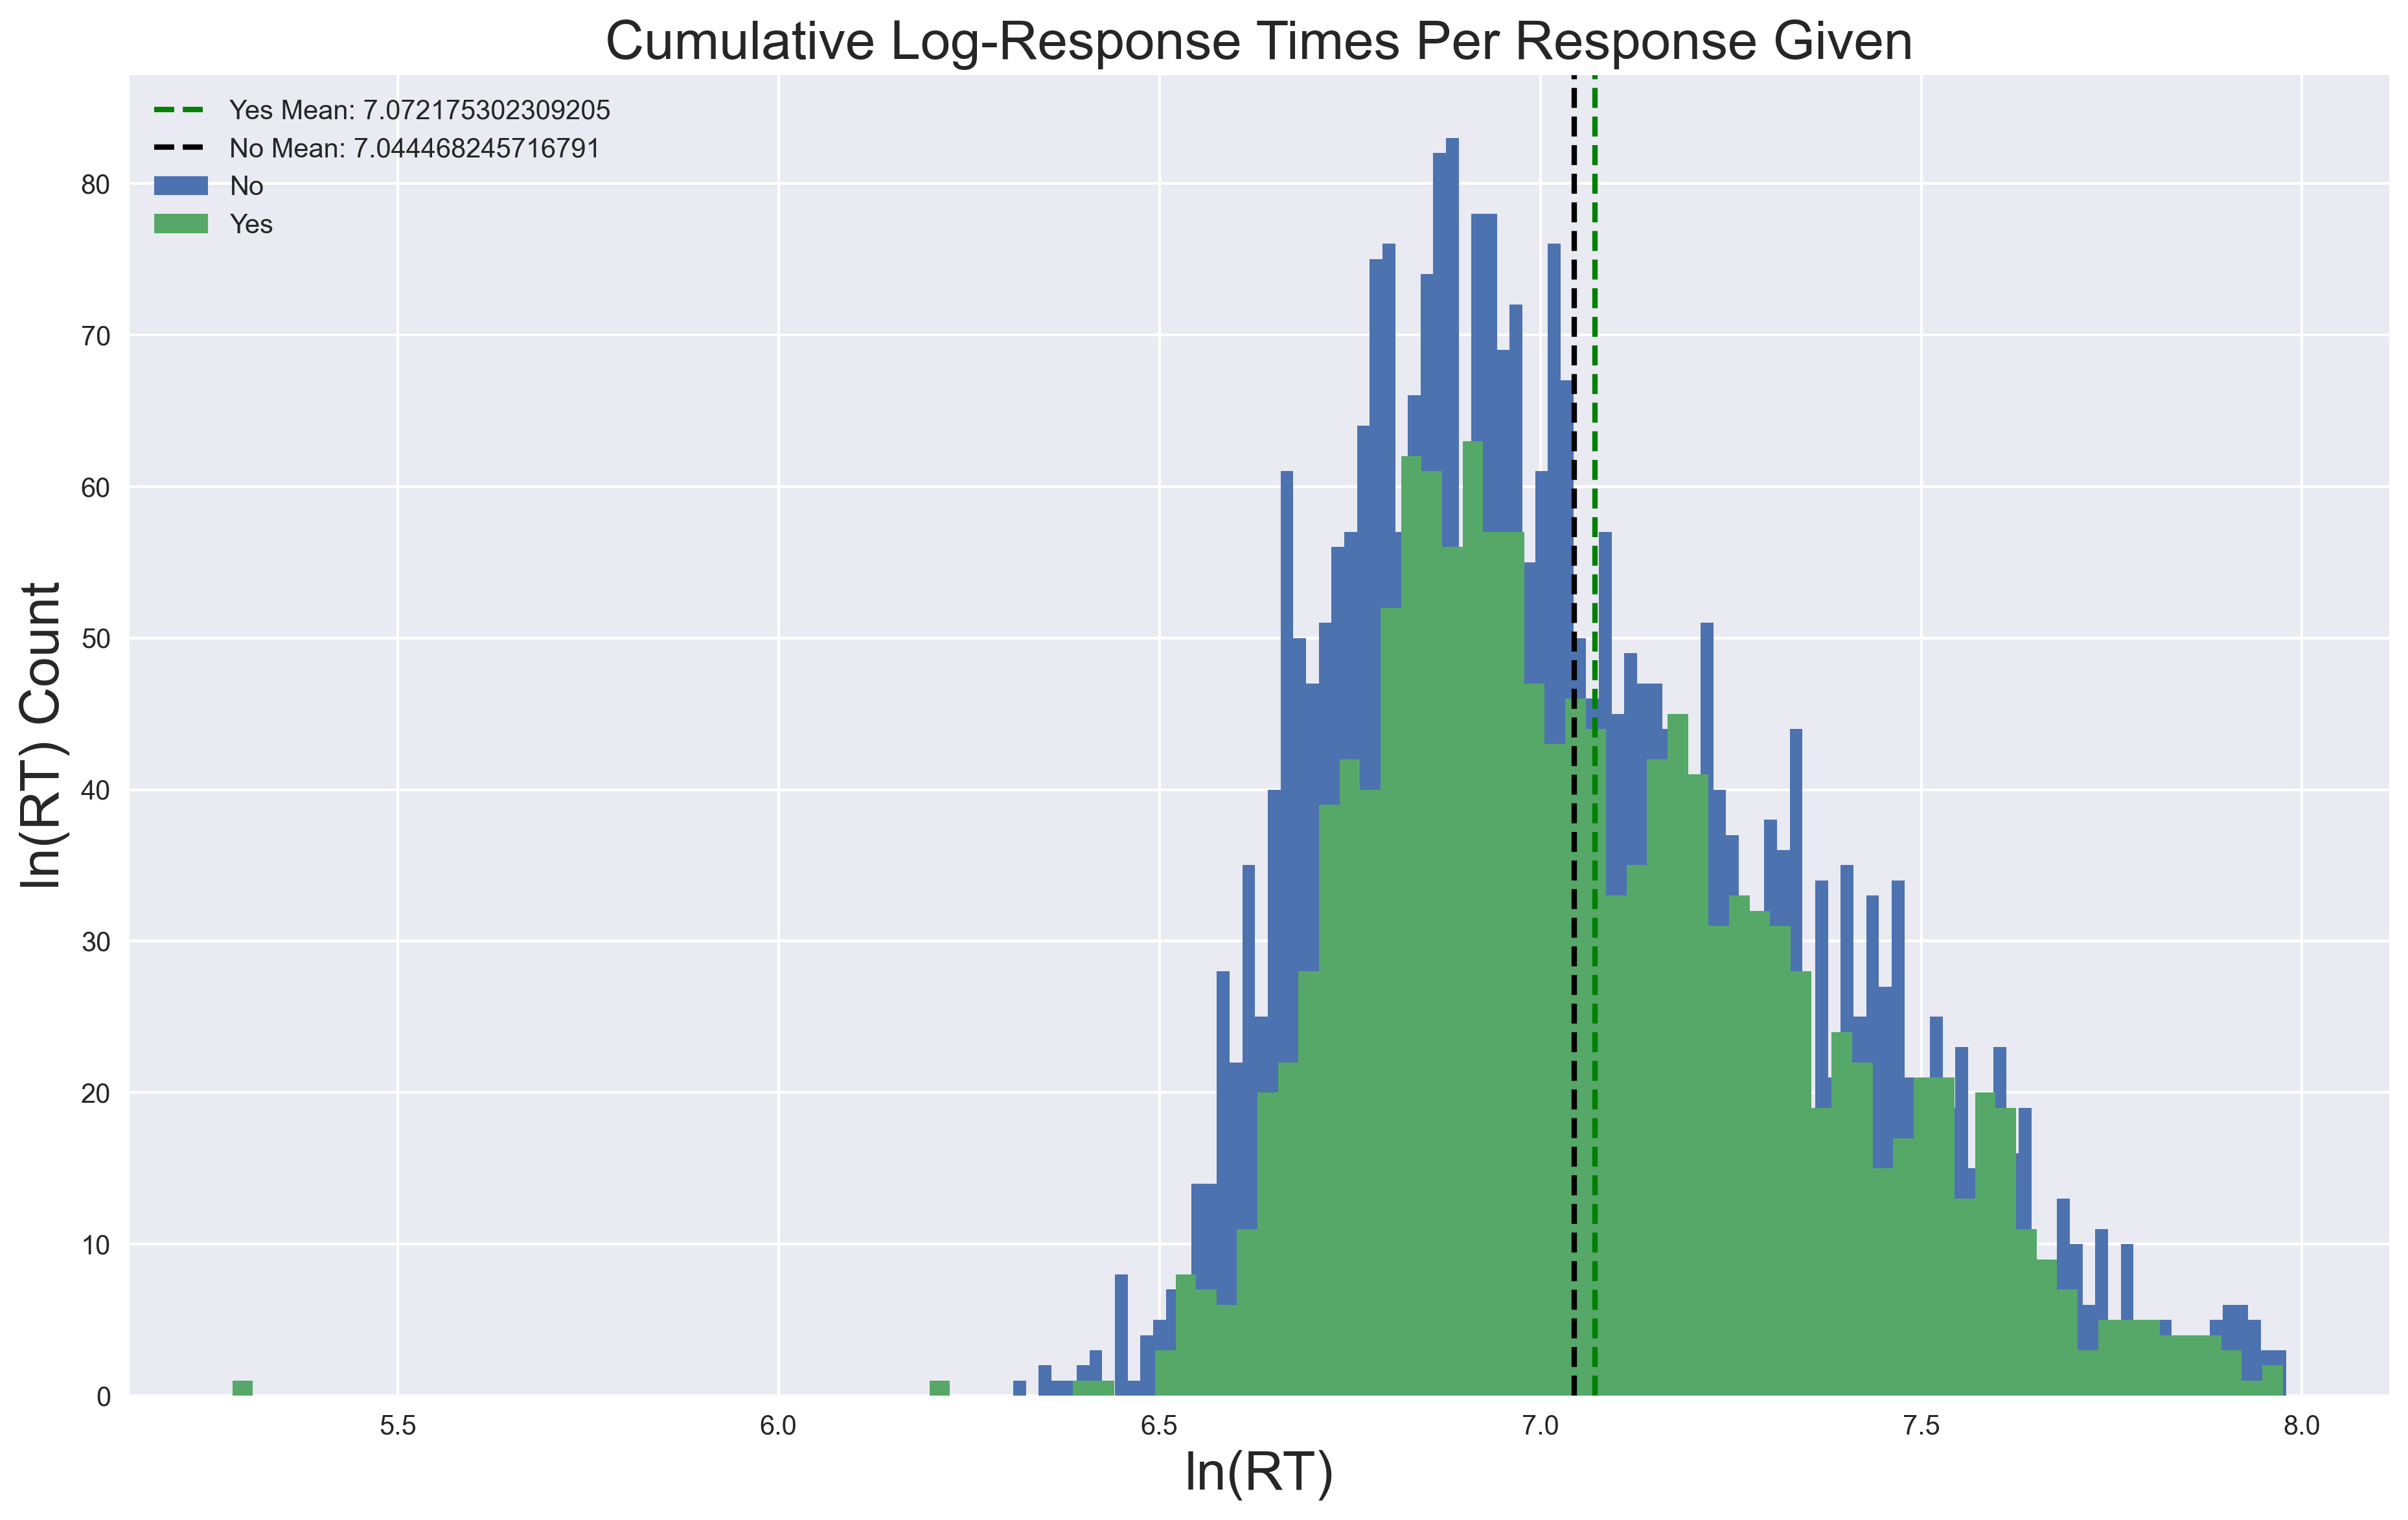

In [35]:
figure(figsize=(15, 9), dpi=300)
plt.hist(responses[responses.response=="No"].log_rt, bins=100, label="No");
plt.hist(responses[responses.response=="Yes"].log_rt, bins=100, label="Yes");
plt.title("Cumulative Log-Response Times Per Response Given",fontsize=20)
plt.xlabel("ln(RT)",fontsize=20)
plt.ylabel("ln(RT) Count",fontsize=20);
plt.axvline(responses[responses.response=="Yes"].log_rt.mean(),color="green",linestyle='dashed', linewidth=2, label="Yes Mean: "+str(responses[responses.response=="Yes"].log_rt.mean()))
plt.axvline(responses[responses.response=="No"].log_rt.mean(),color="black",linestyle='dashed', linewidth=2, label="No Mean: "+str(responses[responses.response=="No"].log_rt.mean()))
plt.legend(loc="upper left")

#### Log-Response Times Per Condition

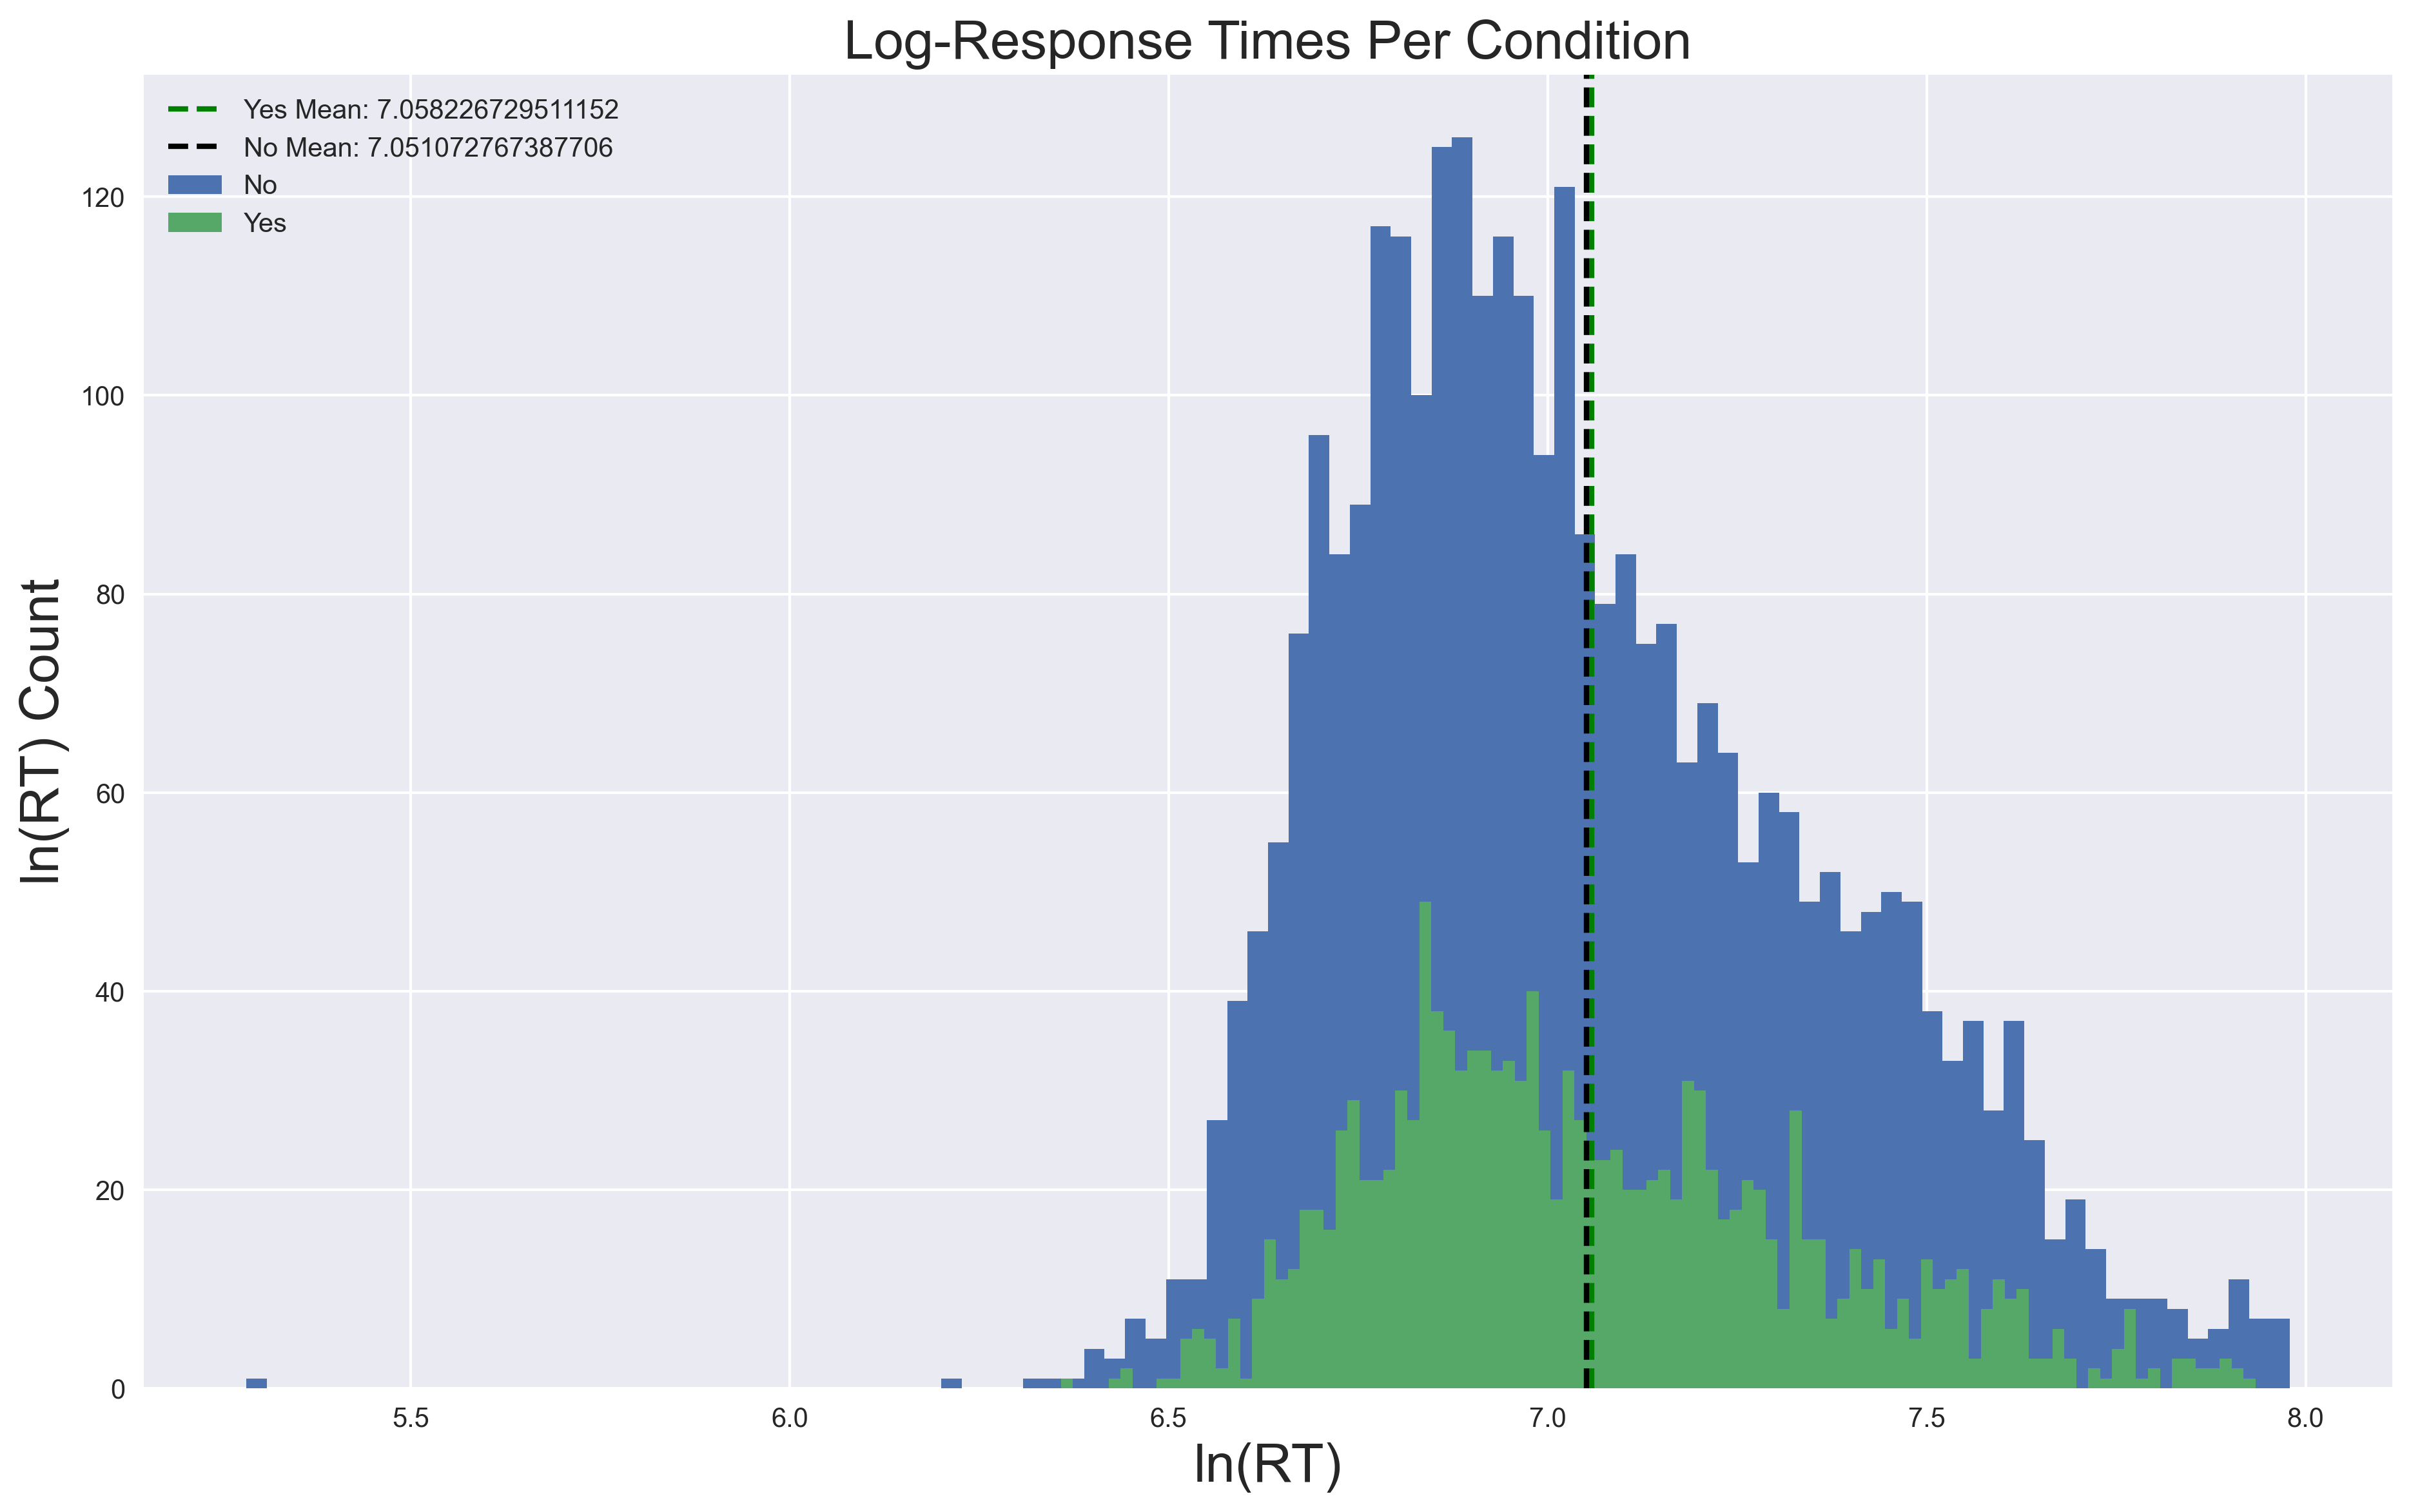

In [36]:
figure(figsize=(15, 9), dpi=300)
plt.hist(responses[responses.trial_condition=="No"].log_rt, bins=100, label="No");
plt.hist(responses[responses.trial_condition=="Yes"].log_rt, bins=100, label="Yes");
plt.title("Log-Response Times Per Condition",fontsize=20)
plt.xlabel("ln(RT)",fontsize=20)
plt.ylabel("ln(RT) Count",fontsize=20);
plt.axvline(responses[responses.trial_condition=="Yes"].log_rt.mean(),color="green",linestyle='dashed', linewidth=2, label="Yes Mean: "+str(responses[responses.trial_condition=="Yes"].log_rt.mean()))
plt.axvline(responses[responses.trial_condition=="No"].log_rt.mean(),color="black",linestyle='dashed', linewidth=2, label="No Mean: "+str(responses[responses.trial_condition=="No"].log_rt.mean()))
plt.legend(loc="upper left")

#### Log-RT For Correct/Incorrect Trials

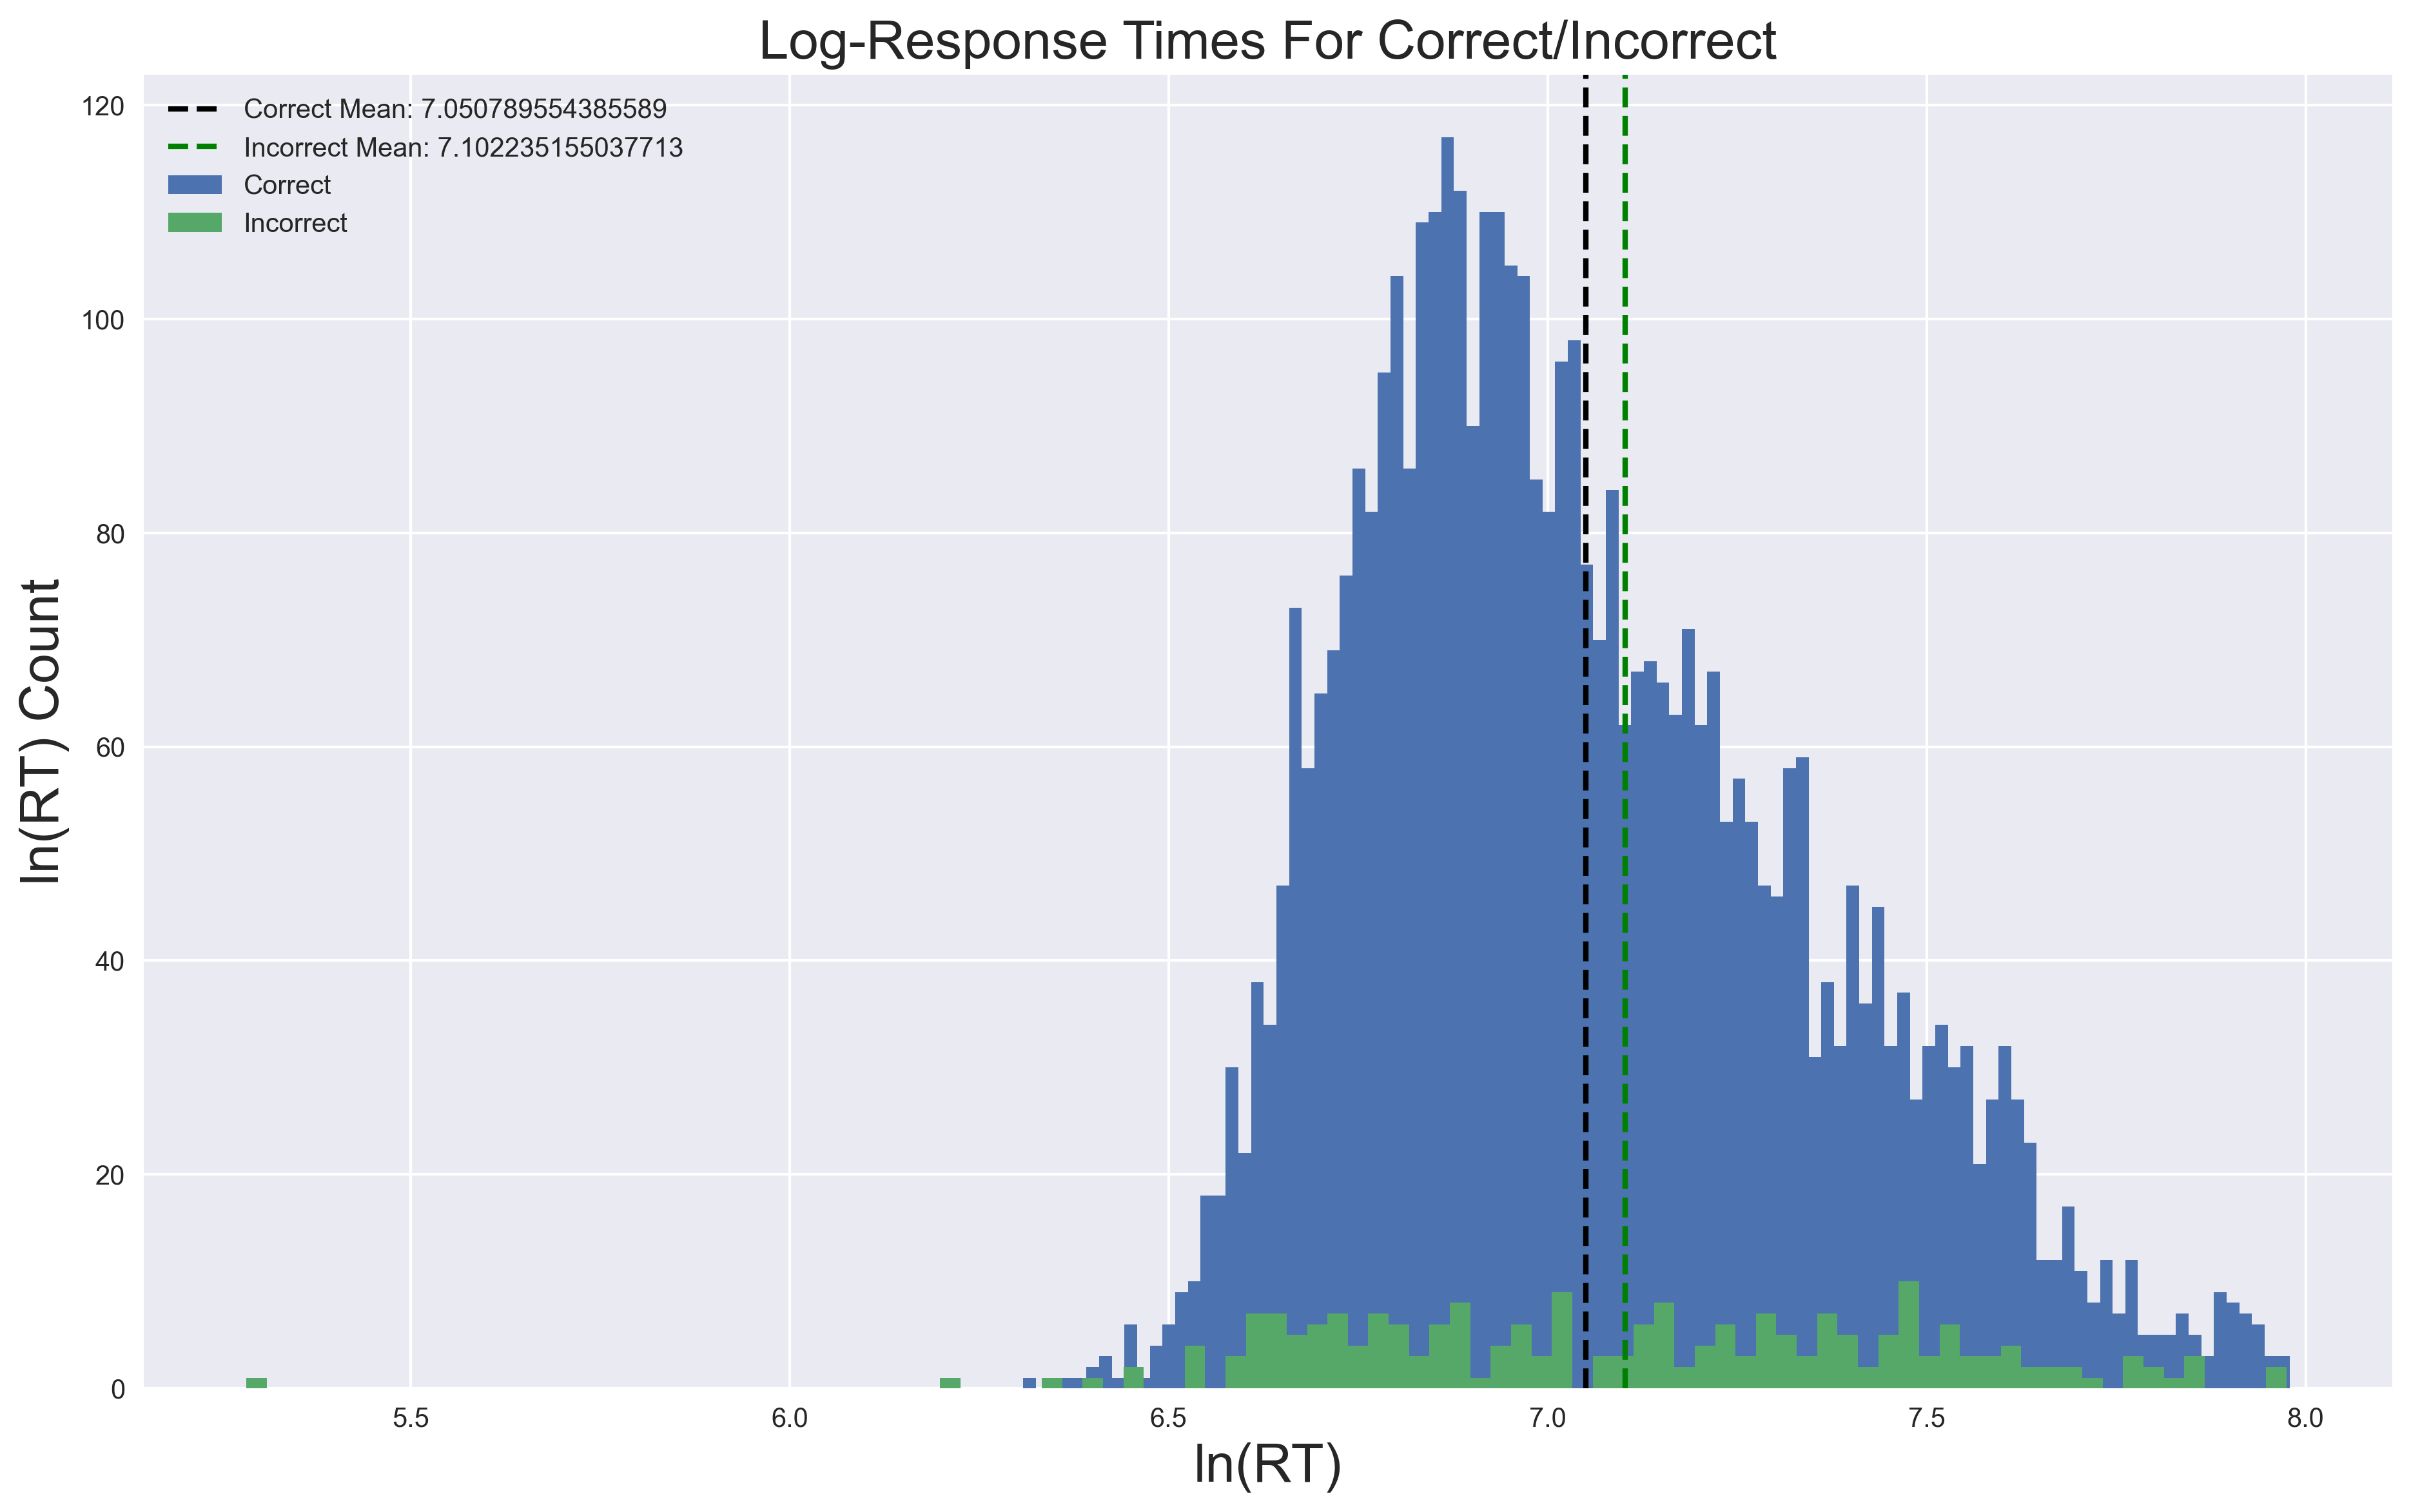

In [37]:
figure(figsize=(15, 9), dpi=300)
plt.hist(responses[responses.correct==True].log_rt, bins=100, label="Correct");
plt.hist(responses[responses.correct==False].log_rt, bins=100, label="Incorrect");
plt.title("Log-Response Times For Correct/Incorrect",fontsize=20)
plt.xlabel("ln(RT)",fontsize=20)
plt.ylabel("ln(RT) Count",fontsize=20);
plt.axvline(responses[responses.correct==True].log_rt.mean(),color="black",linestyle='dashed', linewidth=2, label="Correct Mean: "+str(responses[responses.correct==True].log_rt.mean()))
plt.axvline(responses[responses.correct==False].log_rt.mean(),color="green",linestyle='dashed', linewidth=2, label="Incorrect Mean: "+str(responses[responses.correct==False].log_rt.mean()))
plt.legend(loc="upper left")

### Model Predictions

In [62]:
distance = responses[responses.scene.isin(['scene_0','scene_1','scene_2'])]
no_distance = responses[responses.scene.isin(['scene_31','scene_33','scene_35'])]

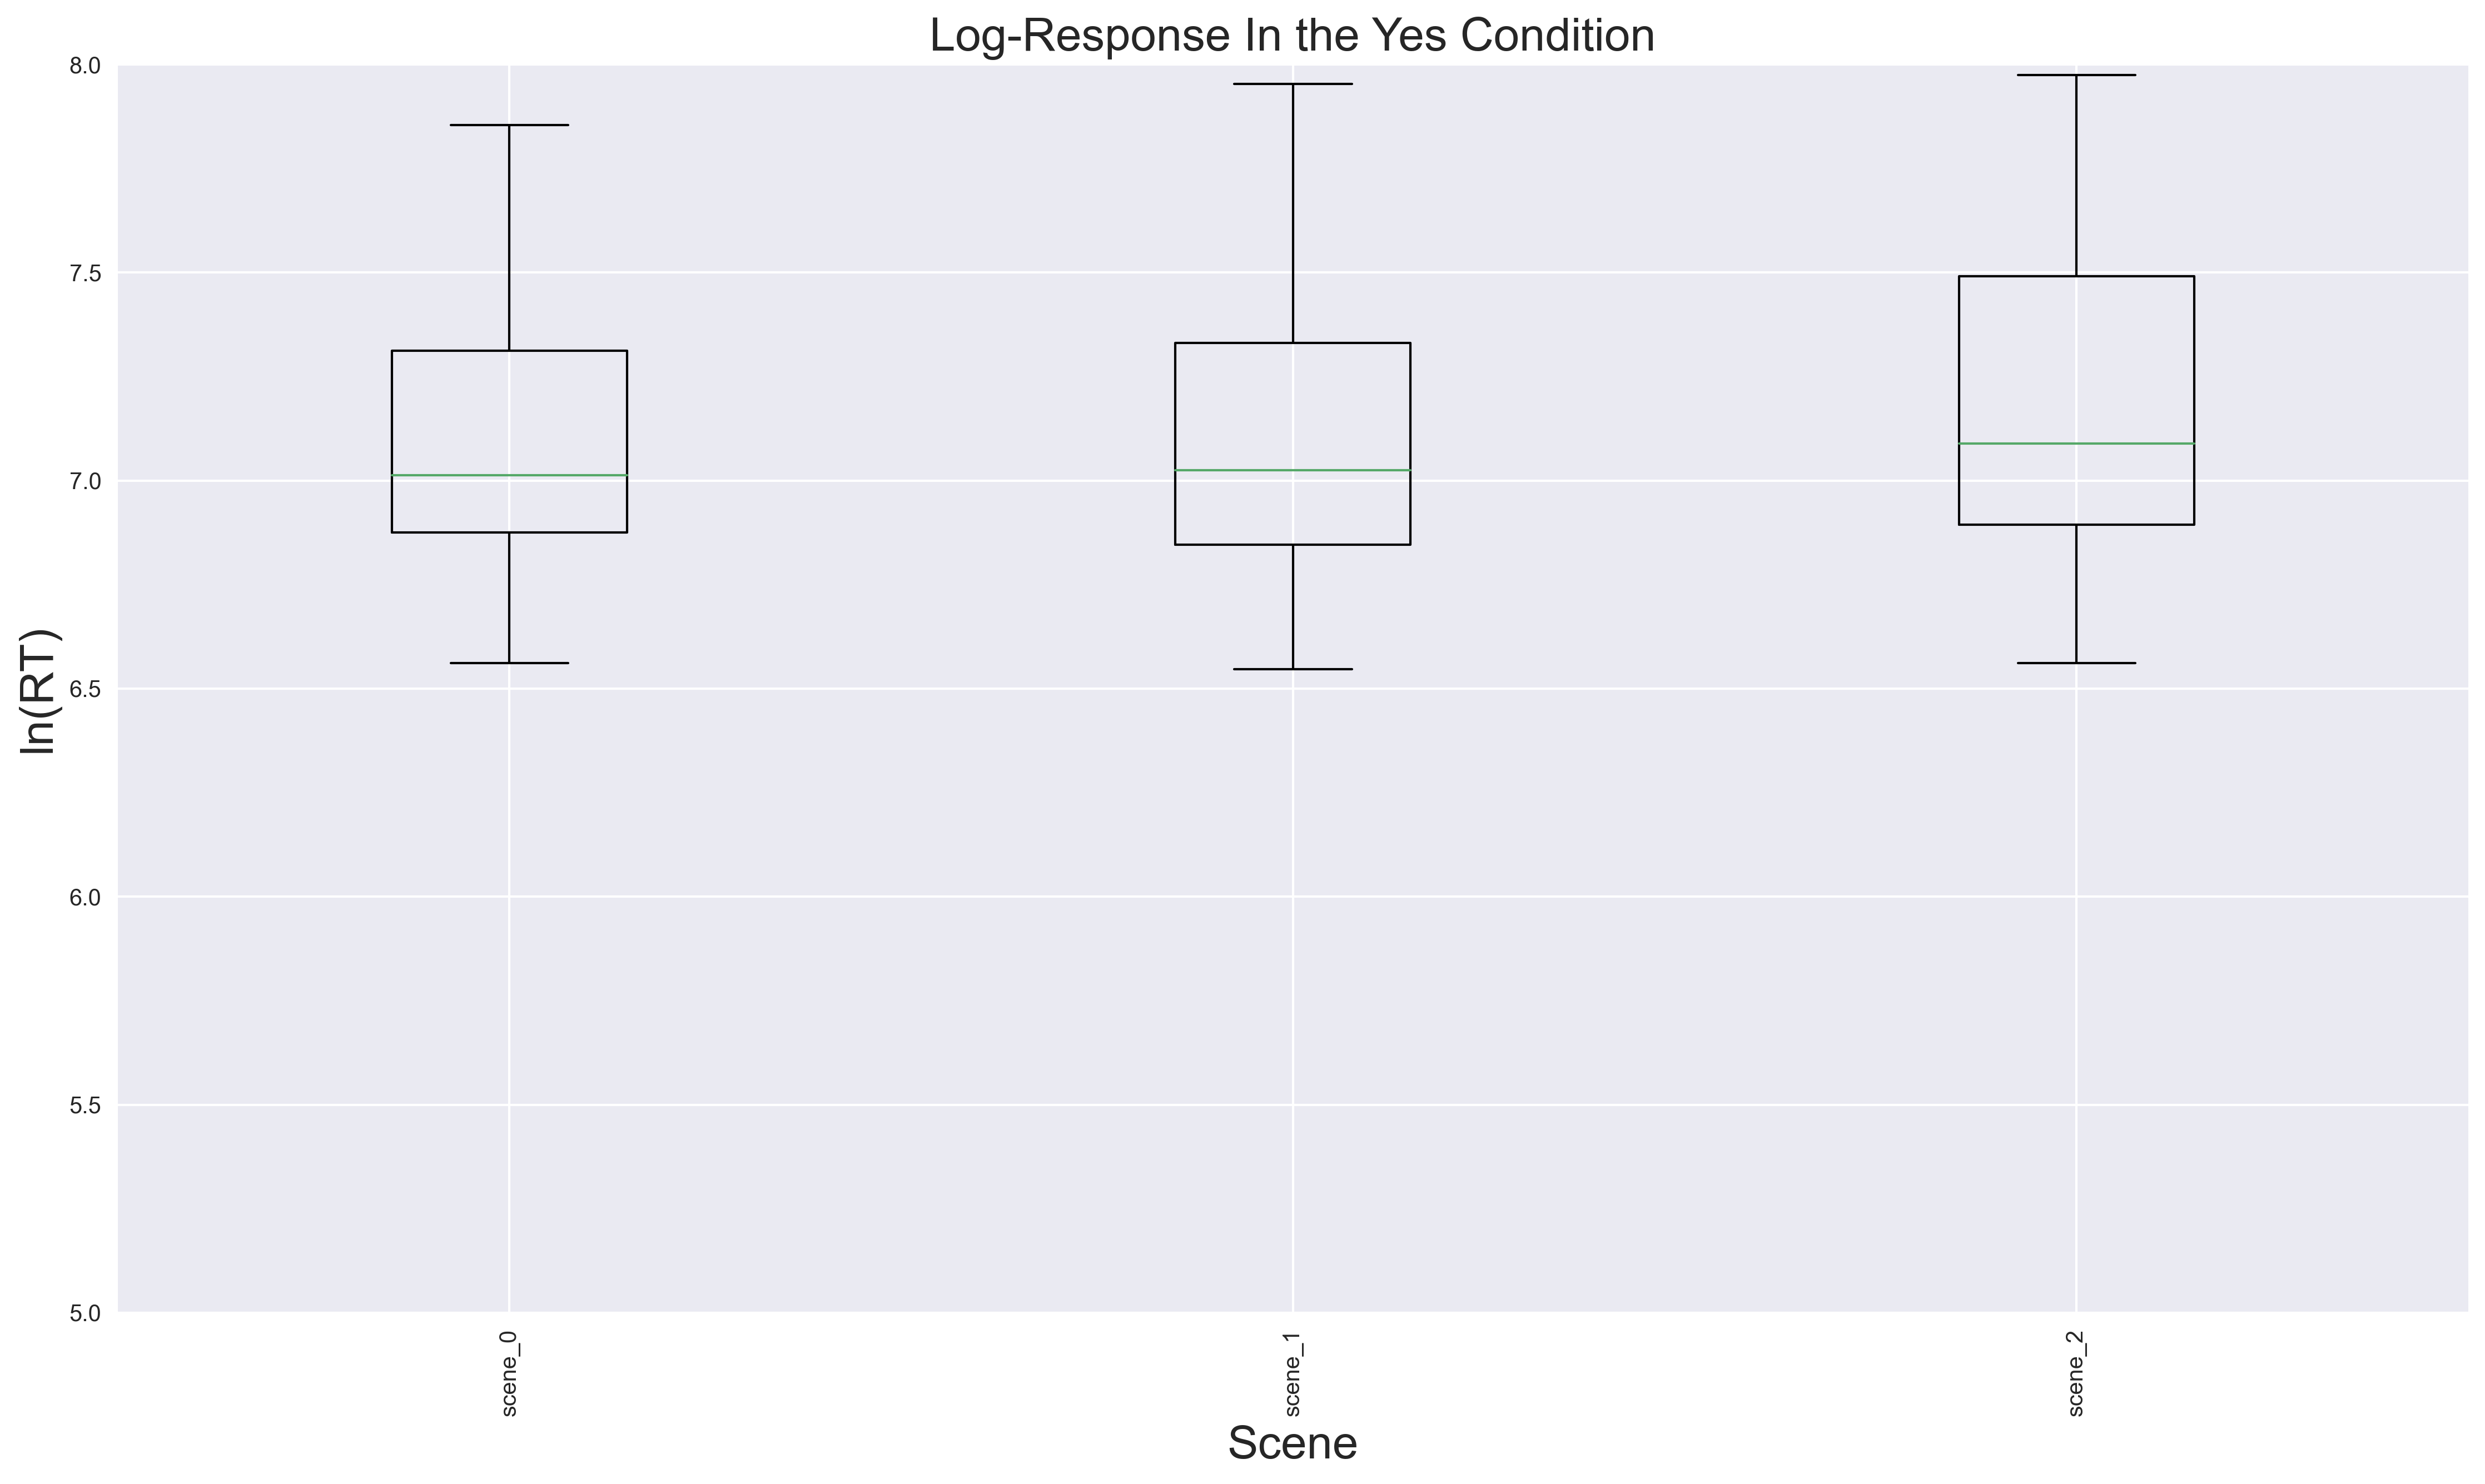

In [64]:
figure(figsize=(15, 9), dpi=300)

plt.boxplot(distance.groupby("scene").log_rt.apply(list))
plt.title("Log-Response In the Yes Condition",fontsize=20)
plt.ylabel("ln(RT)",fontsize=20)
plt.xlabel("Scene",fontsize=20)
plt.xticks(list(range(1,4)), 
           list(distance.groupby("scene").log_rt.apply(list).index), 
           rotation = 90)
plt.ylim(5,8)
plt.tight_layout()
plt.show()

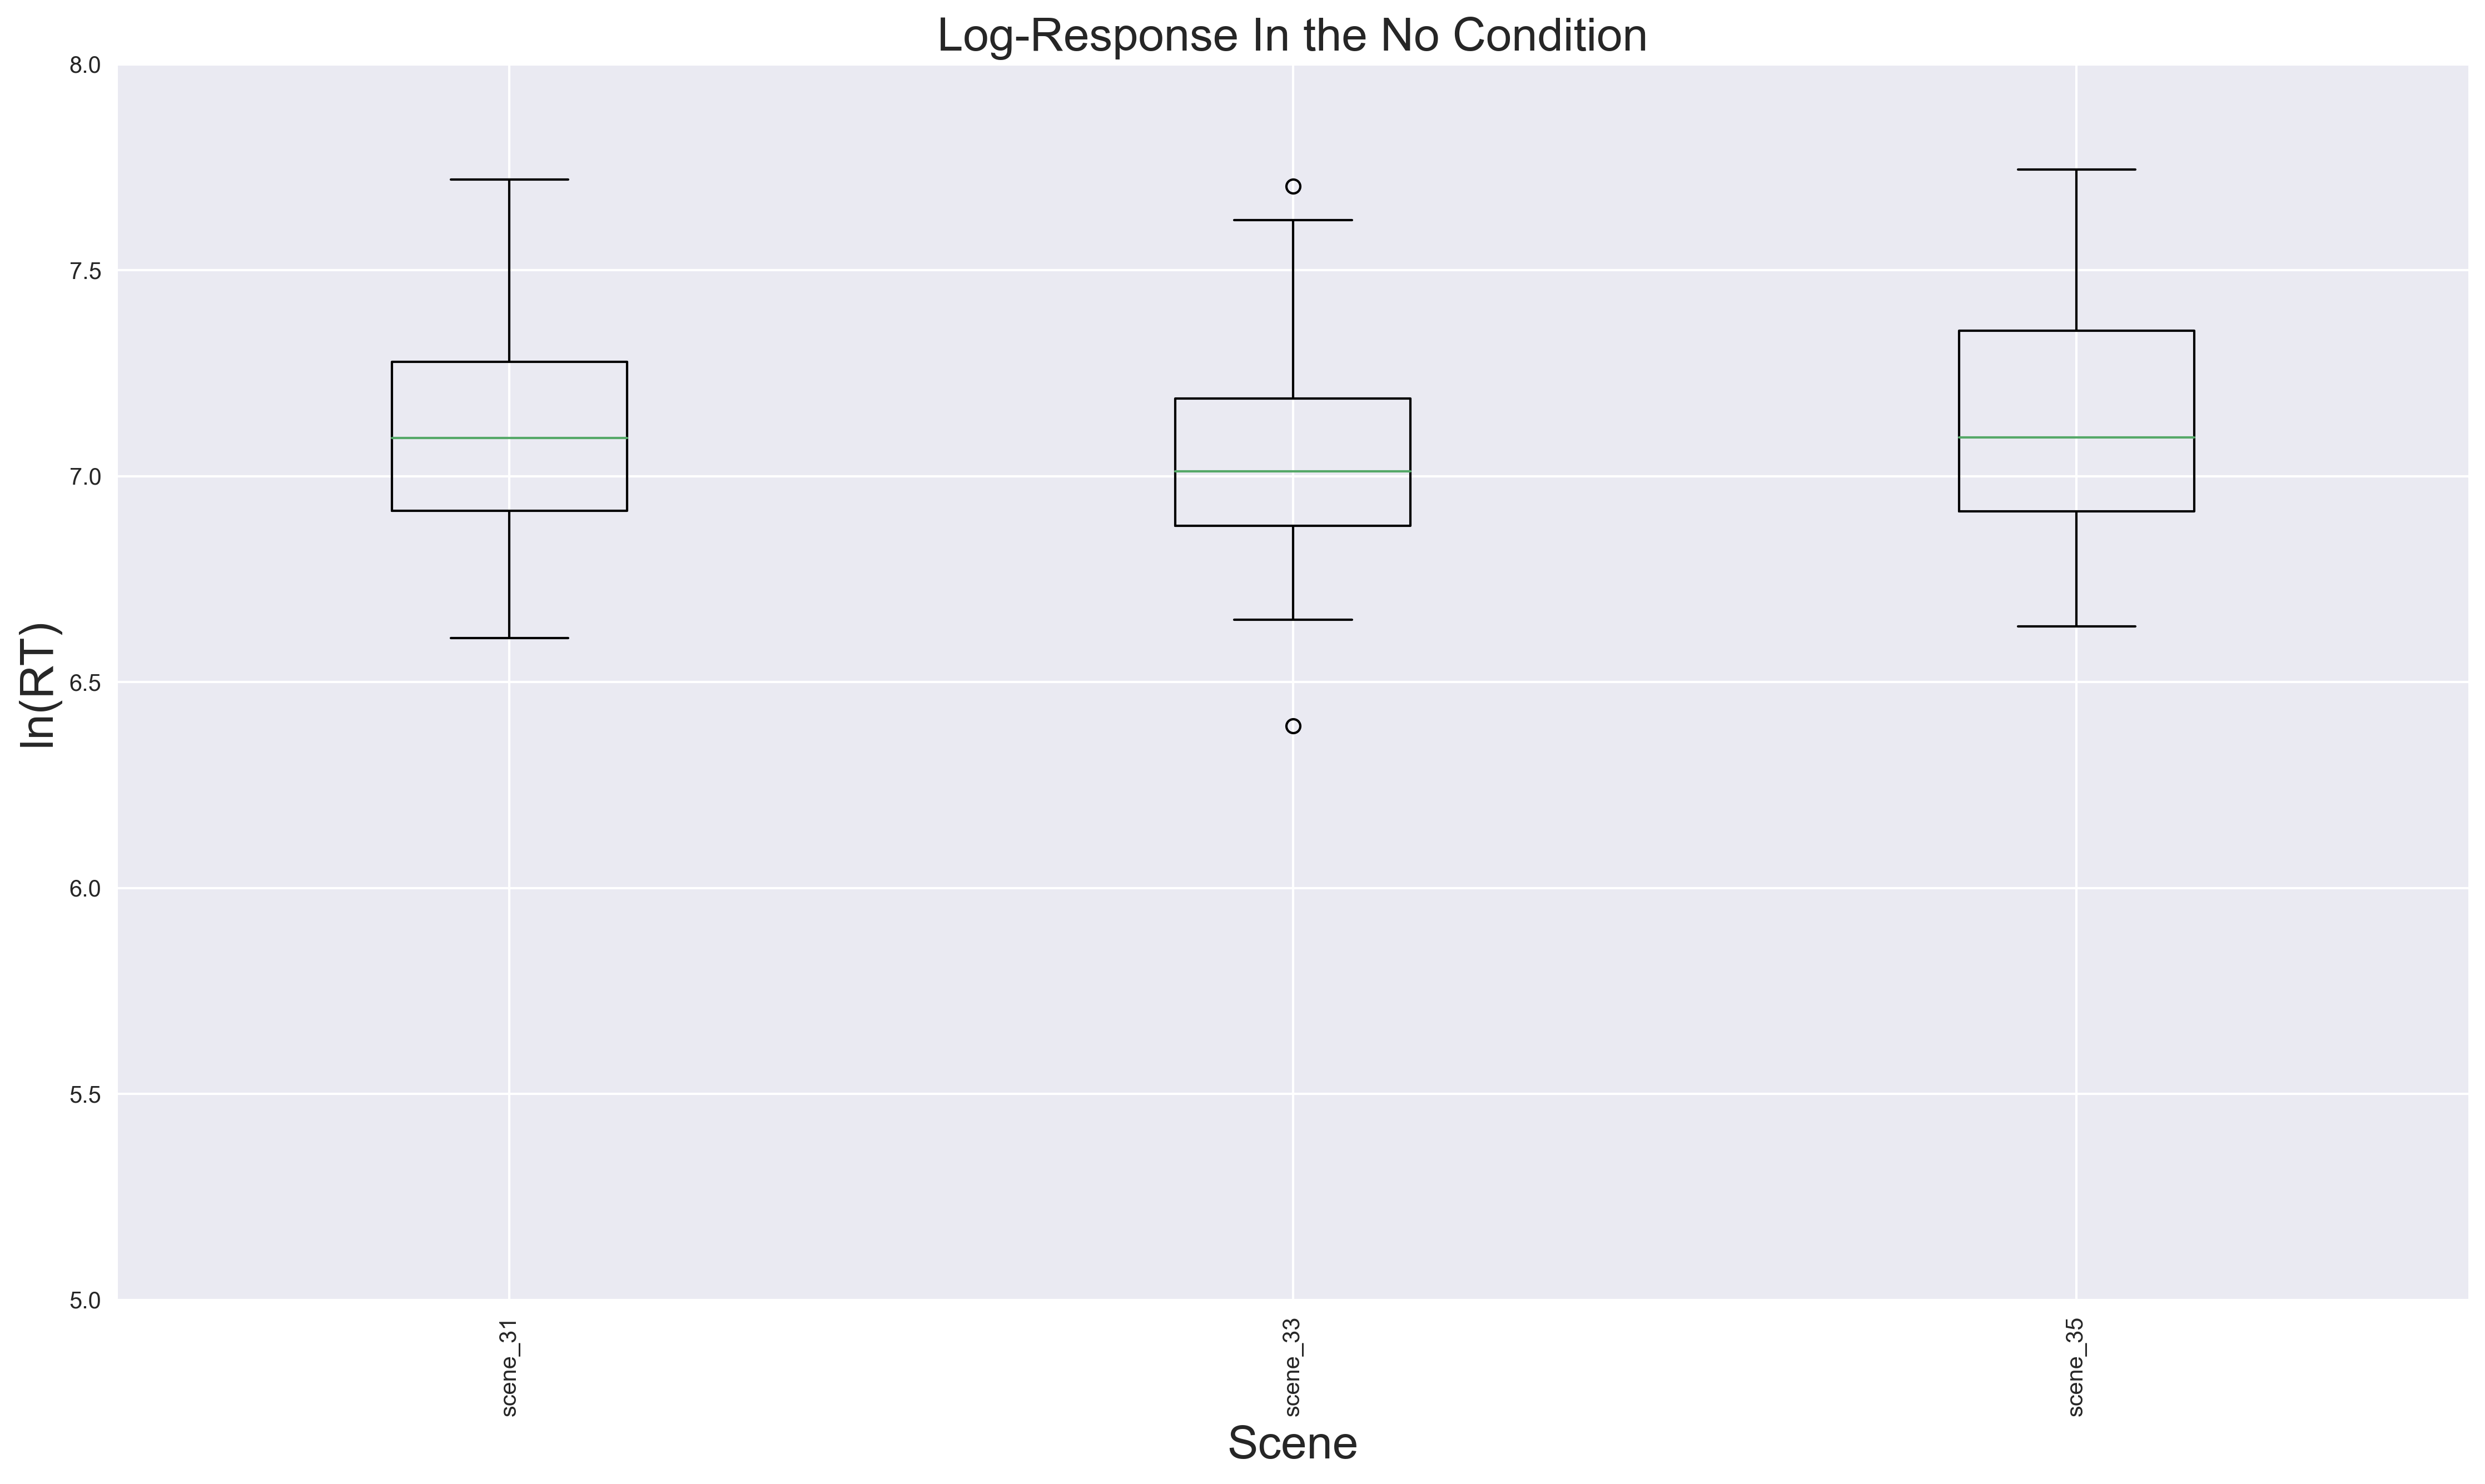

In [64]:
figure(figsize=(15, 9), dpi=300)

plt.boxplot(no_distance.groupby("scene").log_rt.apply(list))
plt.title("Log-Response In the No Condition",fontsize=20)
plt.ylabel("ln(RT)",fontsize=20)
plt.xlabel("Scene",fontsize=20)
plt.xticks(list(range(1,4)), 
           list(no_distance.groupby("scene").log_rt.apply(list).index), 
           rotation = 90)
plt.ylim(5,8)
plt.tight_layout()
plt.show()

In [67]:
responses.corr()

trial_index        rt    log_rt  participant_accuracy  \
trial_index              1.000000 -0.199881 -0.211047             -0.012384   
rt                      -0.199881  1.000000  0.981340             -0.279906   
log_rt                  -0.211047  0.981340  1.000000             -0.268231   
participant_accuracy    -0.012384 -0.279906 -0.268231              1.000000   
trial_accuracy           0.344884 -0.138517 -0.136814             -0.016862   
scene_accuracy          -0.014825 -0.068148 -0.077118             -0.004935   

                      trial_accuracy  scene_accuracy  
trial_index                 0.344884       -0.014825  
rt                         -0.138517       -0.068148  
log_rt                     -0.136814       -0.077118  
participant_accuracy       -0.016862       -0.004935  
trial_accuracy              1.000000       -0.002714  
scene_accuracy             -0.002714        1.000000

In [74]:
d_rt = responses.groupby('prediction').rt.apply(list)

In [115]:
responses['norm_rt'] = (responses.rt - responses.rt.mean())/responses.rt.std()
responses['norm_log_rt'] = (responses.log_rt - responses.log_rt.mean())/responses.log_rt.std()

In [122]:
df_ = responses[responses.scene.isin(['scene_0','scene_1','scene_2'])]
df_2 = responses[responses.scene.isin(['scene_31','scene_33','scene_35'])]

In [117]:
df = df.groupby('scene').norm_log_rt.describe()

In [130]:
df_[df_.scene=='scene_0'].norm_log_rt.mean()

0.18541856885389665

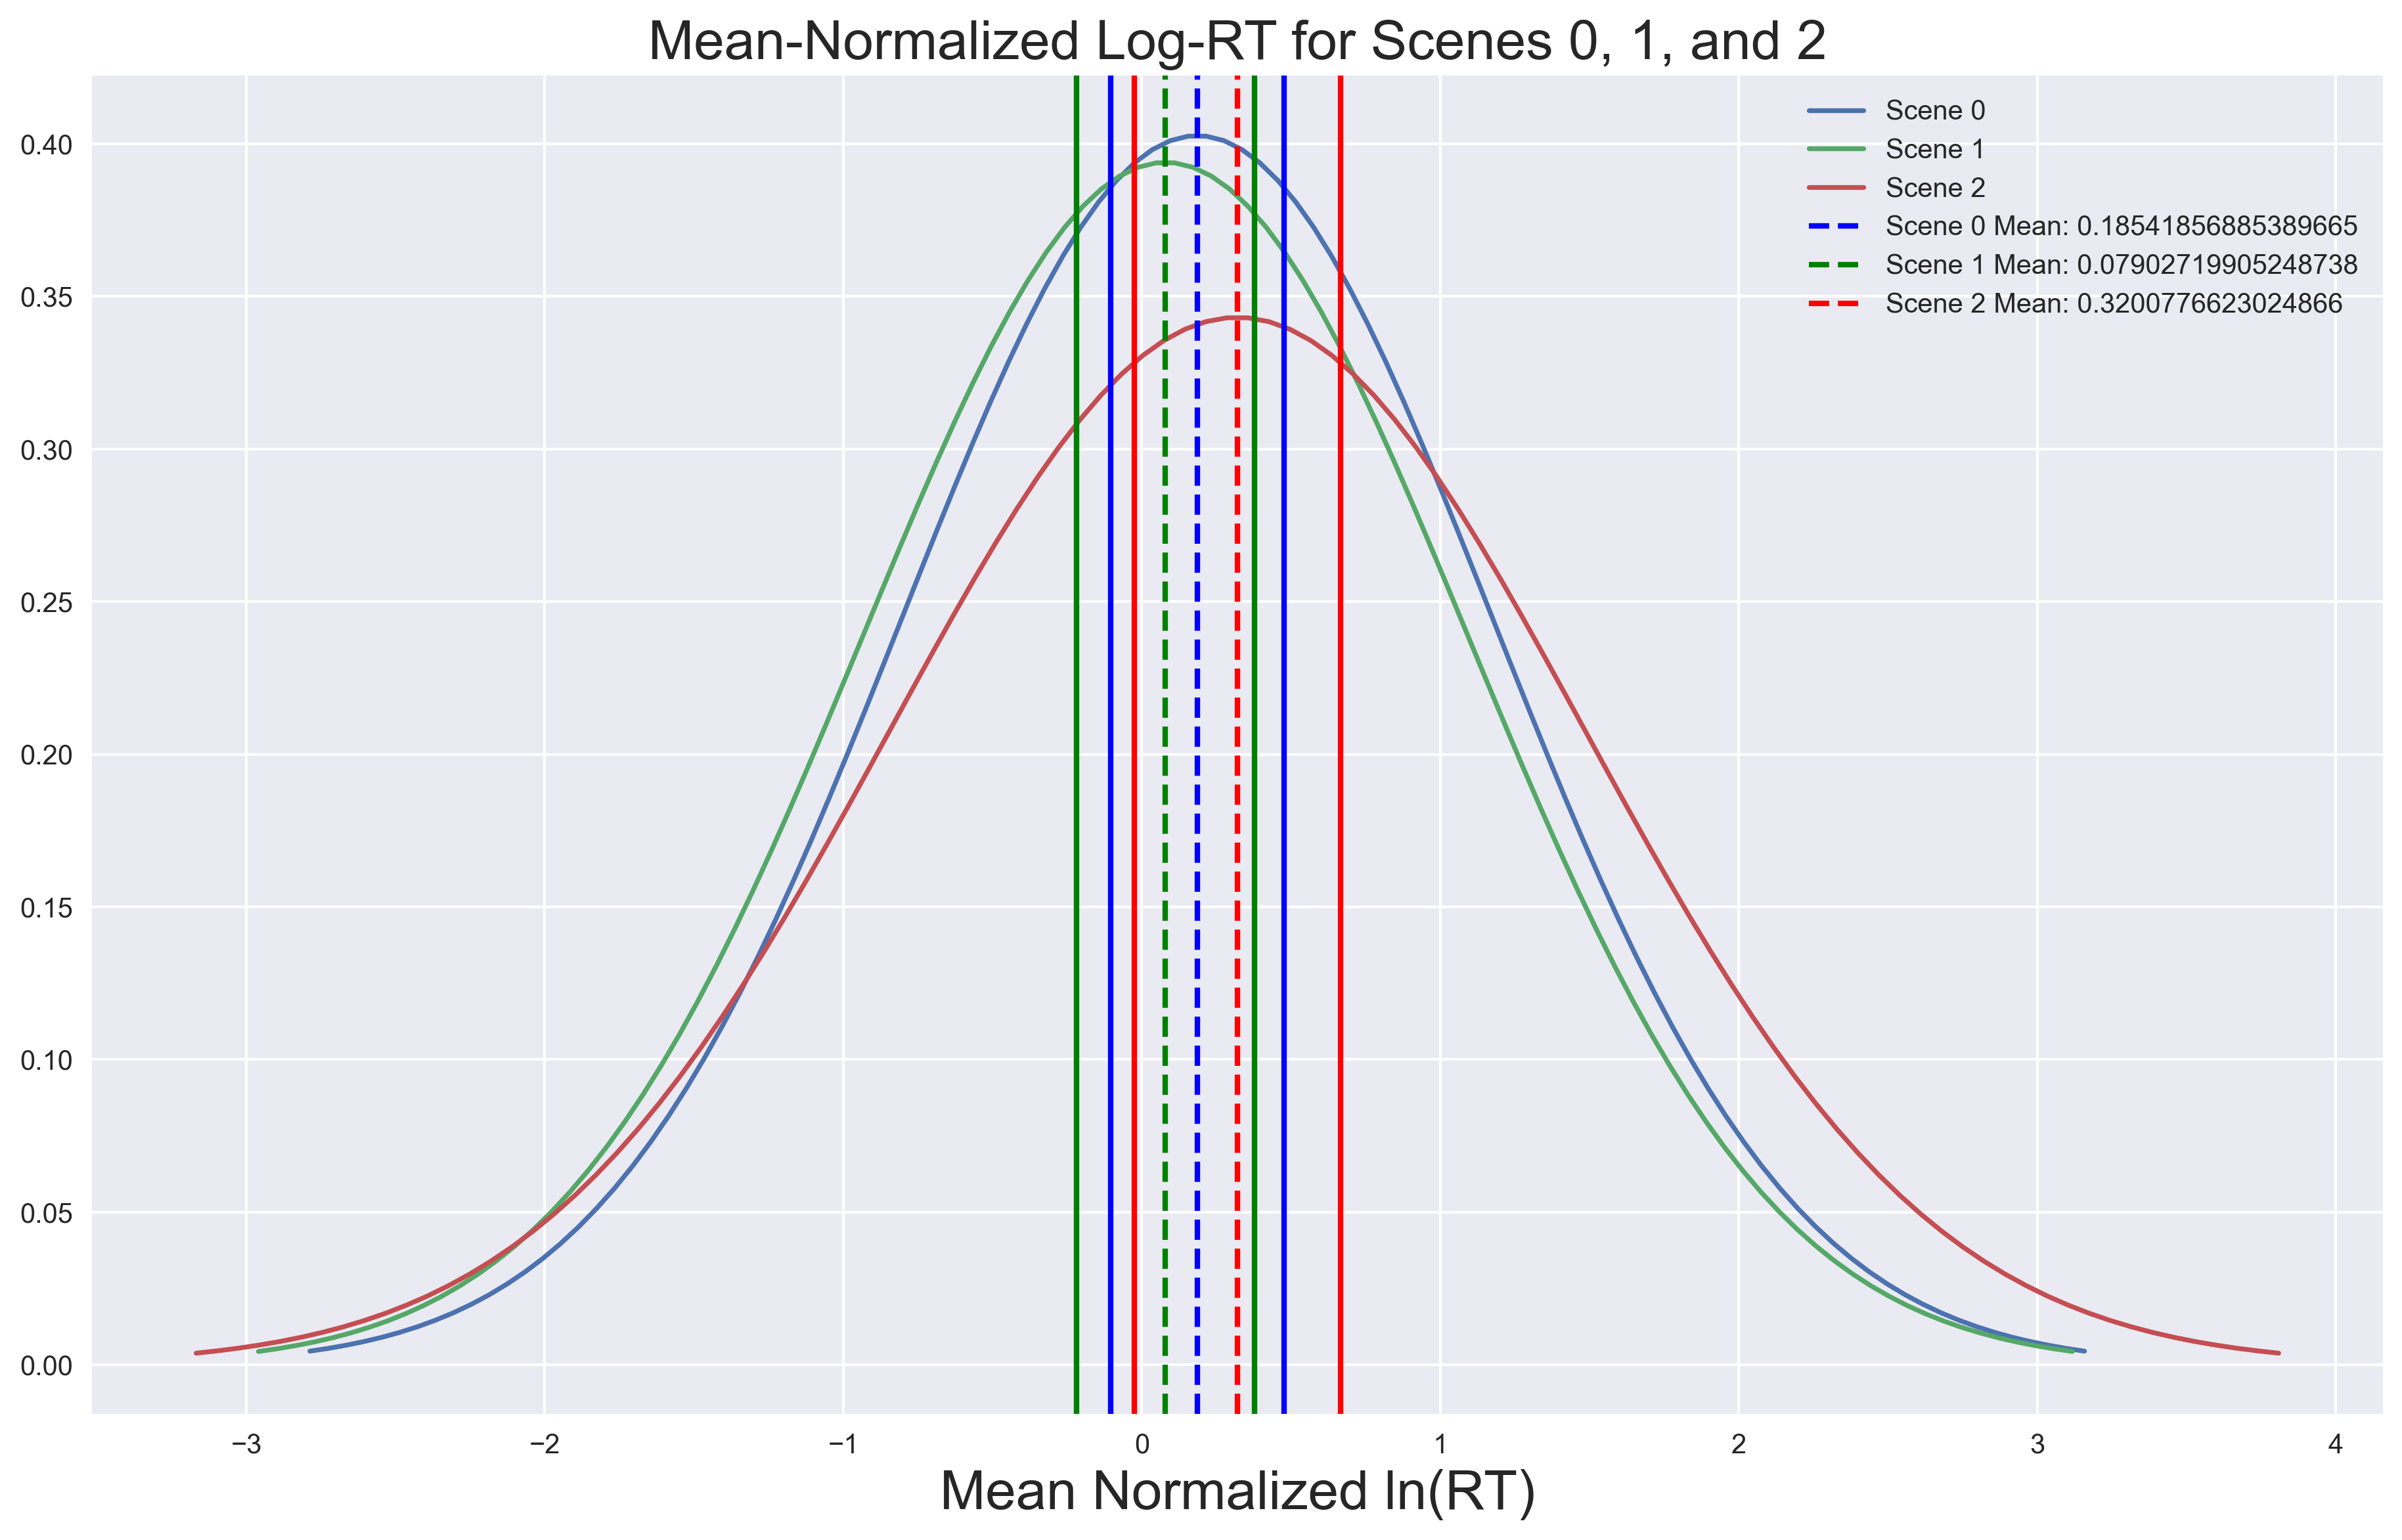

In [136]:
import scipy.stats as stats
x00,x01 = stats.t.interval(alpha=0.95, df=len(df_[df_.scene=='scene_0'].norm_log_rt)-1, 
                 loc=df_[df_.scene=='scene_0'].norm_log_rt.mean(), 
                 scale=stats.sem(df_[df_.scene=='scene_0'].norm_log_rt))
x10,x11 = stats.t.interval(alpha=0.95, df=len(df_[df_.scene=='scene_1'].norm_log_rt)-1, 
                 loc=df_[df_.scene=='scene_1'].norm_log_rt.mean(), 
                 scale=stats.sem(df_[df_.scene=='scene_1'].norm_log_rt))
x20,x21 = stats.t.interval(alpha=0.95, df=len(df_[df_.scene=='scene_2'].norm_log_rt)-1, 
                 loc=df_[df_.scene=='scene_2'].norm_log_rt.mean(), 
                 scale=stats.sem(df_[df_.scene=='scene_2'].norm_log_rt))

figure(figsize=(15, 9), dpi=300)

mu0 = df.loc[df.index[0]]['mean']
mu1= df.loc[df.index[1]]['mean']
mu2= df.loc[df.index[2]]['mean']
sigma0 = df.loc[df.index[0]]['std']
sigma1 = df.loc[df.index[1]]['std']
sigma2 = df.loc[df.index[2]]['std']
x0 = np.linspace(mu0 - 3*sigma0, mu0 + 3*sigma0, 100)
x1 = np.linspace(mu1 - 3*sigma1, mu1 + 3*sigma1, 100)
x2 = np.linspace(mu2 - 3*sigma2, mu2 + 3*sigma2, 100)
plt.plot(x0, stats.norm.pdf(x0, mu0, sigma0), label='Scene 0')
plt.plot(x1, stats.norm.pdf(x1, mu1, sigma1), label='Scene 1')
plt.plot(x2, stats.norm.pdf(x2, mu2, sigma2), label='Scene 2')

plt.axvline(x00,color="blue",linestyle='solid', linewidth=2)
plt.axvline(x01,color="blue",linestyle='solid', linewidth=2)
plt.axvline(x10,color="green",linestyle='solid', linewidth=2)
plt.axvline(x11,color="green",linestyle='solid', linewidth=2)
plt.axvline(x20,color="red",linestyle='solid', linewidth=2)
plt.axvline(x21,color="red",linestyle='solid', linewidth=2)

plt.axvline(df.loc[df.index[0]]['mean'],color="blue",linestyle='dashed', linewidth=2, label="Scene 0 Mean: "+str(df.loc[df.index[0]]['mean']))
plt.axvline(df.loc[df.index[1]]['mean'],color="green",linestyle='dashed', linewidth=2, label="Scene 1 Mean: "+str(df.loc[df.index[1]]['mean']))
plt.axvline(df.loc[df.index[2]]['mean'],color="red",linestyle='dashed', linewidth=2, label="Scene 2 Mean: "+str(df.loc[df.index[2]]['mean']))

plt.title("Mean-Normalized Log-RT for Scenes 0, 1, and 2",fontsize=20)
plt.xlabel("Mean Normalized ln(RT)",fontsize=20)
plt.legend()
plt.show()

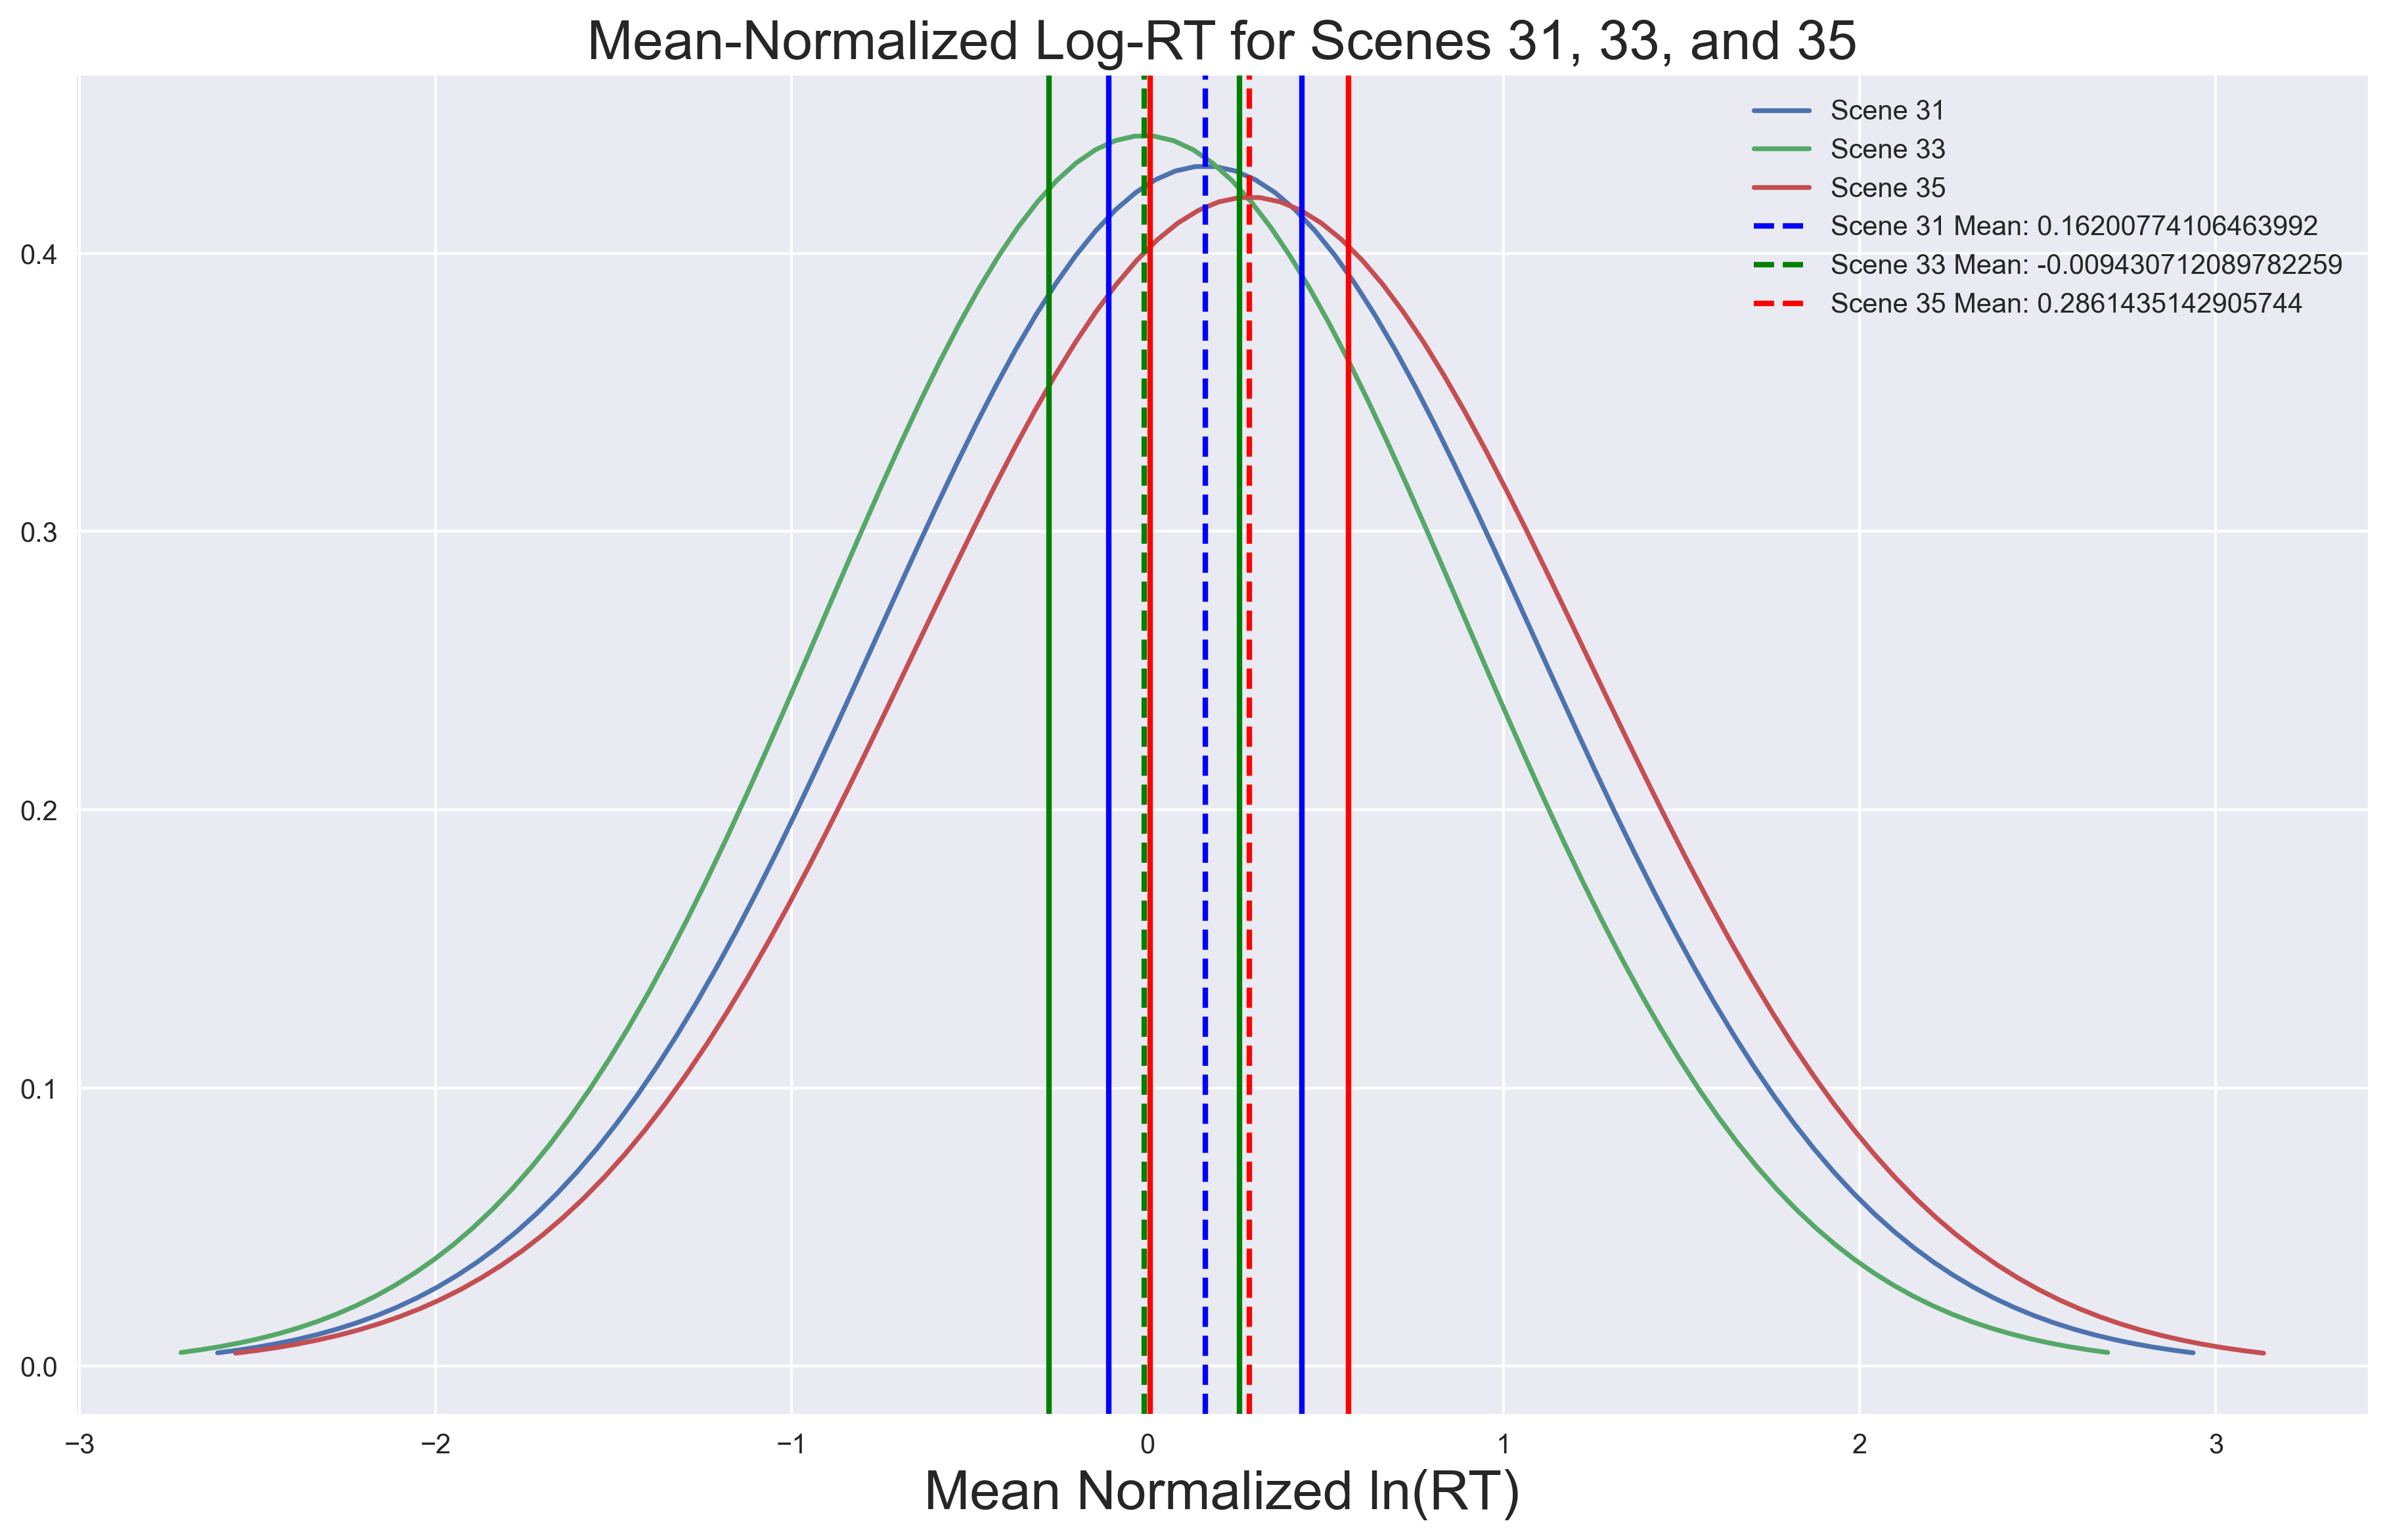

In [141]:
import scipy.stats as stats
x00,x01 = stats.t.interval(alpha=0.95, df=len(df_2[df_2.scene=='scene_31'].norm_log_rt)-1, 
                 loc=df_2[df_2.scene=='scene_31'].norm_log_rt.mean(), 
                 scale=stats.sem(df_2[df_2.scene=='scene_31'].norm_log_rt))
x10,x11 = stats.t.interval(alpha=0.95, df=len(df_2[df_2.scene=='scene_33'].norm_log_rt)-1, 
                 loc=df_2[df_2.scene=='scene_33'].norm_log_rt.mean(), 
                 scale=stats.sem(df_2[df_2.scene=='scene_33'].norm_log_rt))
x20,x21 = stats.t.interval(alpha=0.95, df=len(df_2[df_2.scene=='scene_35'].norm_log_rt)-1, 
                 loc=df_2[df_2.scene=='scene_35'].norm_log_rt.mean(), 
                 scale=stats.sem(df_2[df_2.scene=='scene_35'].norm_log_rt))

figure(figsize=(15, 9), dpi=300)

df =  df_2.groupby('scene').norm_log_rt.describe()
mu0 = df.loc[df.index[0]]['mean']
mu1= df.loc[df.index[1]]['mean']
mu2= df.loc[df.index[2]]['mean']
sigma0 = df.loc[df.index[0]]['std']
sigma1 = df.loc[df.index[1]]['std']
sigma2 = df.loc[df.index[2]]['std']
x0 = np.linspace(mu0 - 3*sigma0, mu0 + 3*sigma0, 100)
x1 = np.linspace(mu1 - 3*sigma1, mu1 + 3*sigma1, 100)
x2 = np.linspace(mu2 - 3*sigma2, mu2 + 3*sigma2, 100)
plt.plot(x0, stats.norm.pdf(x0, mu0, sigma0), label='Scene 31')
plt.plot(x1, stats.norm.pdf(x1, mu1, sigma1), label='Scene 33')
plt.plot(x2, stats.norm.pdf(x2, mu2, sigma2), label='Scene 35')

plt.axvline(x00,color="blue",linestyle='solid', linewidth=2)
plt.axvline(x01,color="blue",linestyle='solid', linewidth=2)
plt.axvline(x10,color="green",linestyle='solid', linewidth=2)
plt.axvline(x11,color="green",linestyle='solid', linewidth=2)
plt.axvline(x20,color="red",linestyle='solid', linewidth=2)
plt.axvline(x21,color="red",linestyle='solid', linewidth=2)

plt.axvline(df.loc[df.index[0]]['mean'],color="blue",linestyle='dashed', linewidth=2, label="Scene 31 Mean: "+str(df.loc[df.index[0]]['mean']))
plt.axvline(df.loc[df.index[1]]['mean'],color="green",linestyle='dashed', linewidth=2, label="Scene 33 Mean: "+str(df.loc[df.index[1]]['mean']))
plt.axvline(df.loc[df.index[2]]['mean'],color="red",linestyle='dashed', linewidth=2, label="Scene 35 Mean: "+str(df.loc[df.index[2]]['mean']))

plt.title("Mean-Normalized Log-RT for Scenes 31, 33, and 35",fontsize=20)
plt.xlabel("Mean Normalized ln(RT)",fontsize=20)
plt.legend()
plt.show()